In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'tune closeness reward  0.75'
Experiment_note = """
"""

In [5]:
gpuId = 3
control_dt=0.2
theta = np.array([-180,180])
vel_theta = np.array([-180,180])
random_vel = np.array([0,0.3])
radius=1.0
max_time = 10
action_max= 2
done_dist = 0.15
dist_distri_param =np.array([0,0.3])
couple_mode =  fl.COUPLE_MODE.TWO_WAY
ratio = 0.005/control_dt*(max_time/10)
use_com=False

import torch
torch.cuda.set_device(gpuId)

In [6]:
wr = 0.75*np.array([1.0,0.5])
wp = 1.0*np.array([0.0,1.0])
wa = 0.5
live_penality =0

In [7]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)

# num_train_steps= int(1e6)
# replay_buffer_capacity=int(1e6)
# num_seed_steps=int(100)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
seed=1

In [8]:

discount=0.99
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
batch_size=int(2048*ratio)
# batch_size = 256
gradient_steps=1
target_update_interval=1
ent_coef= "auto"
target_entropy= "auto" 

# critic settings
critic_net_arch= [256,256]
n_critics = 2
# actor settings
actor_net_arch= [256,256]
actor_log_std_bounds=[-20, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [9]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [10]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [11]:
fluid_json = json_folder+'fluid_param_test.json'
rigid_json = json_folder+'rigids_4_30_new.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_test.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_new.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [12]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [13]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [14]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer

## RL Begin

In [16]:
from sac.agent.sac import SACAgent
from sac.agent.critic import Critic
from sac.agent.actor import DiagGaussianActor

In [17]:
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,control_dt=control_dt,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
                   )
env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()

array([1., 0., 0.])

In [18]:
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_space = env.action_space

In [19]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [20]:
logger = Logger(tb_folder,save_tb=log_save_tb,
                             agent="sac")
critic_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)
critic_target_network = Critic(obs_dim, action_dim,net_arch=critic_net_arch,n_critics= n_critics)

actor_network = DiagGaussianActor( obs_dim, action_dim, actor_net_arch,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_space,device,critic_network,critic_target_network,actor_network,replay_buffer, 
                 discount,ent_coef,target_entropy,
                 alpha_lr,alpha_betas,actor_lr,actor_betas,critic_lr,critic_betas,critic_tau,
                 gradient_steps,target_update_interval,batch_size)


In [21]:
step = 0
next_eval_steps= eval_frequency

In [22]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                action = agent.predict(obs, deterministic=False)
            next_obs, reward, done, _ = env.step(action)
            action = agent.scale_action(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [23]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [24]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                action=agent.predict(obs, deterministic=True)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [25]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [26]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 30 | R: -49.3624 | D: 22.9 s | BR: -1.2748 | ALOSS: -3.2117 | CLOSS: 1.3536 | TLOSS: -0.0292 | TVAL: 0.9957 | AENT: -4.0000
| train | E: 2 | S: 79 | R: -95.7298 | D: 32.1 s | BR: -1.4299 | ALOSS: -3.7766 | CLOSS: 0.5895 | TLOSS: -0.1089 | TVAL: 0.9839 | AENT: -4.0000
| train | E: 3 | S: 103 | R: -41.0860 | D: 15.4 s | BR: -1.5974 | ALOSS: -3.6801 | CLOSS: 0.4507 | TLOSS: -0.1822 | TVAL: 0.9732 | AENT: -4.0000
| train | E: 4 | S: 140 | R: -63.9251 | D: 23.2 s | BR: -1.5830 | ALOSS: -3.7986 | CLOSS: 0.4494 | TLOSS: -0.2437 | TVAL: 0.9644 | AENT: -4.0000
| train | E: 5 | S: 167 | R: -32.8889 | D: 19.0 s | BR: -1.5760 | ALOSS: -3.8629 | CLOSS: 0.5160 | TLOSS: -0.3088 | TVAL: 0.9551 | AENT: -4.0000
| train | E: 6 | S: 190 | R: -36.2037 | D: 15.4 s | BR: -1.6533 | ALOSS: -3.8652 | CLOSS: 0.4603 | TLOSS: -0.3593 | TVAL: 0.9480 | AENT: -4.0000
| train | E: 7 | S: 240 | R: -65.1392 | D: 31.5 s | BR: -1.5091 | ALOSS: -4.0746 | CLOSS: 0.4148 | TLOSS: -0.4314 | TVAL: 0.9377 | A

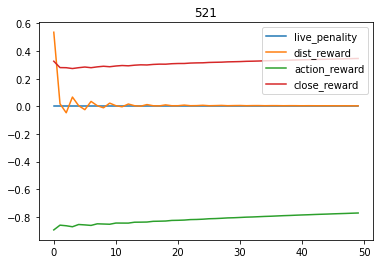

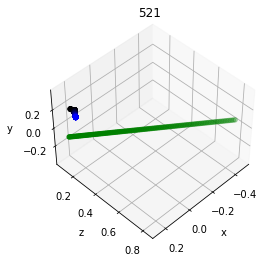

| eval  | E: 14 | S: 521 | R: -24.3090
| train | E: 15 | S: 521 | R: -37.1824 | D: 16.8 s | BR: -1.4491 | ALOSS: -4.7500 | CLOSS: 0.3565 | TLOSS: -1.0131 | TVAL: 0.8590 | AENT: -4.0000
| train | E: 16 | S: 554 | R: -47.7528 | D: 56.6 s | BR: -1.4750 | ALOSS: -4.7166 | CLOSS: 0.3905 | TLOSS: -1.0645 | TVAL: 0.8514 | AENT: -4.0000
| train | E: 17 | S: 604 | R: -40.8869 | D: 31.7 s | BR: -1.4615 | ALOSS: -4.8084 | CLOSS: 0.3760 | TLOSS: -1.1434 | TVAL: 0.8410 | AENT: -4.0000
| train | E: 18 | S: 640 | R: -53.2438 | D: 22.8 s | BR: -1.4157 | ALOSS: -5.0067 | CLOSS: 0.3798 | TLOSS: -1.2258 | TVAL: 0.8304 | AENT: -4.0000
| train | E: 19 | S: 664 | R: -37.3197 | D: 17.5 s | BR: -1.4383 | ALOSS: -4.9982 | CLOSS: 0.5007 | TLOSS: -1.2814 | TVAL: 0.8230 | AENT: -4.0000
| train | E: 20 | S: 714 | R: -52.9551 | D: 31.1 s | BR: -1.4002 | ALOSS: -5.1534 | CLOSS: 0.4692 | TLOSS: -1.3544 | TVAL: 0.8141 | AENT: -4.0000
| train | E: 21 | S: 744 | R: -43.4848 | D: 21.7 s | BR: -1.4056 | ALOSS: -5.1890 | C

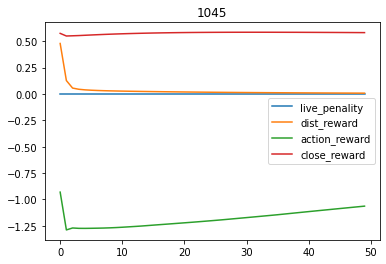

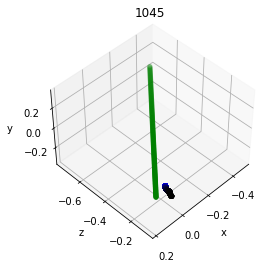

| eval  | E: 27 | S: 1045 | R: -28.8950
| train | E: 28 | S: 1045 | R: -46.5507 | D: 31.2 s | BR: -1.2898 | ALOSS: -5.9386 | CLOSS: 0.5723 | TLOSS: -1.9606 | TVAL: 0.7384 | AENT: -4.0000
| train | E: 29 | S: 1071 | R: -4.4714 | D: 47.9 s | BR: -1.2777 | ALOSS: -6.0769 | CLOSS: 0.6085 | TLOSS: -2.0119 | TVAL: 0.7302 | AENT: -4.0000
| train | E: 30 | S: 1121 | R: -53.2987 | D: 32.1 s | BR: -1.2284 | ALOSS: -6.2888 | CLOSS: 0.5254 | TLOSS: -2.0963 | TVAL: 0.7221 | AENT: -4.0000
| train | E: 31 | S: 1153 | R: -11.9793 | D: 22.5 s | BR: -1.2240 | ALOSS: -6.3516 | CLOSS: 0.5224 | TLOSS: -2.1570 | TVAL: 0.7135 | AENT: -4.0000
| train | E: 32 | S: 1203 | R: -35.3386 | D: 31.4 s | BR: -1.2251 | ALOSS: -6.2859 | CLOSS: 0.6720 | TLOSS: -2.2376 | TVAL: 0.7050 | AENT: -4.0000
| train | E: 33 | S: 1245 | R: -24.8616 | D: 29.6 s | BR: -1.1716 | ALOSS: -6.6768 | CLOSS: 0.5533 | TLOSS: -2.3121 | TVAL: 0.6956 | AENT: -4.0000
| train | E: 34 | S: 1295 | R: -32.3235 | D: 35.1 s | BR: -1.1627 | ALOSS: -6.6

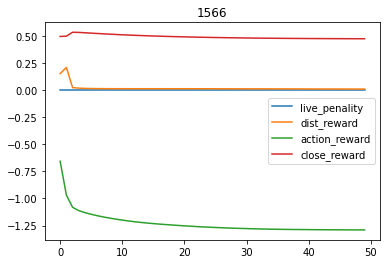

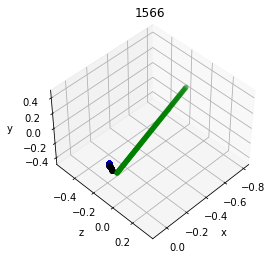

| eval  | E: 41 | S: 1566 | R: -35.9377
| train | E: 42 | S: 1566 | R: -6.9625 | D: 18.9 s | BR: -1.0653 | ALOSS: -7.5023 | CLOSS: 0.8503 | TLOSS: -2.8451 | TVAL: 0.6325 | AENT: -4.0000
| train | E: 43 | S: 1591 | R: -3.4402 | D: 52.5 s | BR: -1.0231 | ALOSS: -7.5442 | CLOSS: 0.7900 | TLOSS: -2.9283 | TVAL: 0.6275 | AENT: -4.0000
| train | E: 44 | S: 1621 | R: -3.3430 | D: 19.4 s | BR: -1.0918 | ALOSS: -7.4803 | CLOSS: 0.9253 | TLOSS: -2.9347 | TVAL: 0.6225 | AENT: -4.0000
| train | E: 45 | S: 1644 | R: 5.4353 | D: 15.6 s | BR: -1.0793 | ALOSS: -7.4181 | CLOSS: 1.0453 | TLOSS: -3.0076 | TVAL: 0.6177 | AENT: -4.0000
| train | E: 46 | S: 1694 | R: -52.5292 | D: 40.1 s | BR: -1.0032 | ALOSS: -7.6808 | CLOSS: 0.8467 | TLOSS: -3.0861 | TVAL: 0.6112 | AENT: -4.0000
| train | E: 47 | S: 1719 | R: -7.5641 | D: 17.2 s | BR: -1.0002 | ALOSS: -7.6877 | CLOSS: 1.0868 | TLOSS: -3.1194 | TVAL: 0.6045 | AENT: -4.0000
| train | E: 48 | S: 1750 | R: -5.4140 | D: 22.2 s | BR: -0.9716 | ALOSS: -7.8740 | 

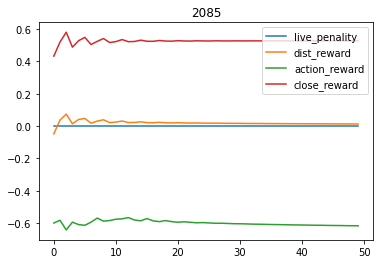

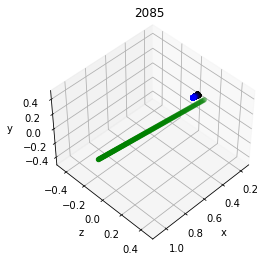

| eval  | E: 57 | S: 2085 | R: -2.7471
| train | E: 58 | S: 2085 | R: -37.8158 | D: 32.2 s | BR: -0.8672 | ALOSS: -8.6468 | CLOSS: 1.2810 | TLOSS: -3.6747 | TVAL: 0.5458 | AENT: -4.0000
| train | E: 59 | S: 2109 | R: -0.2776 | D: 51.2 s | BR: -0.9211 | ALOSS: -8.3790 | CLOSS: 1.5438 | TLOSS: -3.7187 | TVAL: 0.5400 | AENT: -4.0000
| train | E: 60 | S: 2136 | R: -1.3599 | D: 19.0 s | BR: -0.9046 | ALOSS: -8.3933 | CLOSS: 1.3777 | TLOSS: -3.7706 | TVAL: 0.5361 | AENT: -4.0000
| train | E: 61 | S: 2165 | R: -4.8040 | D: 18.4 s | BR: -0.9004 | ALOSS: -8.6392 | CLOSS: 1.1321 | TLOSS: -3.8366 | TVAL: 0.5318 | AENT: -4.0000
| train | E: 62 | S: 2205 | R: -19.3795 | D: 27.5 s | BR: -0.8715 | ALOSS: -8.7440 | CLOSS: 1.1861 | TLOSS: -3.8191 | TVAL: 0.5265 | AENT: -4.0000
| train | E: 63 | S: 2255 | R: -32.0409 | D: 32.0 s | BR: -0.8484 | ALOSS: -8.8523 | CLOSS: 1.2557 | TLOSS: -3.9329 | TVAL: 0.5198 | AENT: -4.0000
| train | E: 64 | S: 2305 | R: -33.5078 | D: 31.9 s | BR: -0.8112 | ALOSS: -9.0890

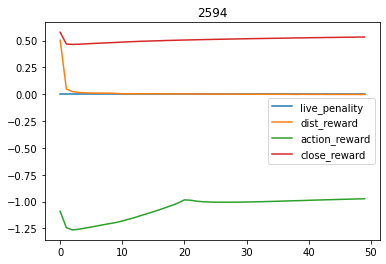

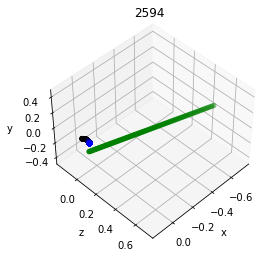

| eval  | E: 69 | S: 2594 | R: -26.9236
| train | E: 70 | S: 2594 | R: -29.2496 | D: 32.1 s | BR: -0.8202 | ALOSS: -9.2439 | CLOSS: 1.3196 | TLOSS: -4.4390 | TVAL: 0.4717 | AENT: -4.0000
| train | E: 71 | S: 2632 | R: -20.1287 | D: 64.2 s | BR: -0.8289 | ALOSS: -9.1962 | CLOSS: 1.2816 | TLOSS: -4.4965 | TVAL: 0.4658 | AENT: -4.0000
| train | E: 72 | S: 2677 | R: -11.1554 | D: 30.3 s | BR: -0.8023 | ALOSS: -9.3060 | CLOSS: 1.2894 | TLOSS: -4.5462 | TVAL: 0.4603 | AENT: -4.0000
| train | E: 73 | S: 2727 | R: -34.5338 | D: 31.3 s | BR: -0.8314 | ALOSS: -9.2250 | CLOSS: 1.3254 | TLOSS: -4.5364 | TVAL: 0.4541 | AENT: -4.0000
| train | E: 74 | S: 2771 | R: -21.4840 | D: 30.6 s | BR: -0.7865 | ALOSS: -9.4543 | CLOSS: 1.1955 | TLOSS: -4.6726 | TVAL: 0.4481 | AENT: -4.0000
| train | E: 75 | S: 2821 | R: -28.2814 | D: 31.3 s | BR: -0.7880 | ALOSS: -9.5136 | CLOSS: 1.2251 | TLOSS: -4.7111 | TVAL: 0.4422 | AENT: -4.0000
| train | E: 76 | S: 2843 | R: 0.3631 | D: 16.4 s | BR: -0.7967 | ALOSS: -9.71

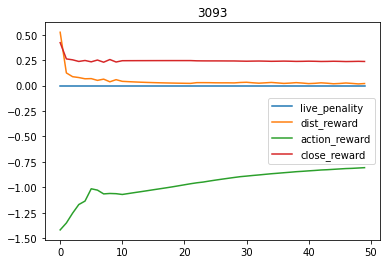

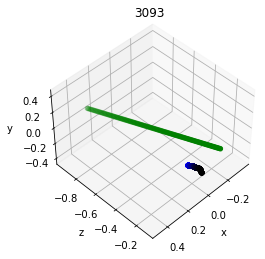

| eval  | E: 83 | S: 3093 | R: -33.5270
| train | E: 84 | S: 3093 | R: 5.3081 | D: 15.8 s | BR: -0.7875 | ALOSS: -9.5083 | CLOSS: 1.4428 | TLOSS: -5.0995 | TVAL: 0.4075 | AENT: -4.0000
| train | E: 85 | S: 3138 | R: -20.5627 | D: 60.0 s | BR: -0.7287 | ALOSS: -9.7780 | CLOSS: 1.3509 | TLOSS: -5.1370 | TVAL: 0.4037 | AENT: -4.0000
| train | E: 86 | S: 3165 | R: 1.7307 | D: 19.7 s | BR: -0.7286 | ALOSS: -9.8081 | CLOSS: 1.2144 | TLOSS: -5.2175 | TVAL: 0.3996 | AENT: -4.0000
| train | E: 87 | S: 3198 | R: -4.6928 | D: 23.5 s | BR: -0.7546 | ALOSS: -9.7531 | CLOSS: 1.2992 | TLOSS: -5.2868 | TVAL: 0.3962 | AENT: -4.0000
| train | E: 88 | S: 3246 | R: -20.2300 | D: 33.4 s | BR: -0.7588 | ALOSS: -9.5910 | CLOSS: 1.6258 | TLOSS: -5.2606 | TVAL: 0.3916 | AENT: -4.0000
| train | E: 89 | S: 3271 | R: -4.5981 | D: 17.9 s | BR: -0.7368 | ALOSS: -9.6439 | CLOSS: 1.1358 | TLOSS: -5.3650 | TVAL: 0.3876 | AENT: -4.0000
| train | E: 90 | S: 3313 | R: -10.2398 | D: 26.5 s | BR: -0.7289 | ALOSS: -9.7068 |

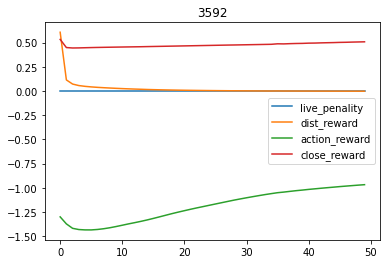

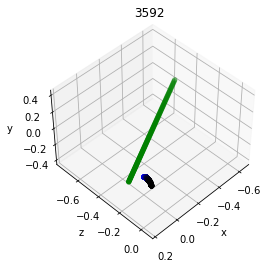

| eval  | E: 97 | S: 3592 | R: -34.5342
| train | E: 98 | S: 3592 | R: -1.0349 | D: 18.1 s | BR: -0.6674 | ALOSS: -10.0805 | CLOSS: 1.0221 | TLOSS: -5.8099 | TVAL: 0.3537 | AENT: -4.0000
| train | E: 99 | S: 3626 | R: -8.5147 | D: 52.1 s | BR: -0.6710 | ALOSS: -9.9864 | CLOSS: 1.0846 | TLOSS: -5.8316 | TVAL: 0.3507 | AENT: -4.0000
| train | E: 100 | S: 3655 | R: -3.5578 | D: 18.4 s | BR: -0.7081 | ALOSS: -9.8573 | CLOSS: 0.9227 | TLOSS: -5.8167 | TVAL: 0.3476 | AENT: -4.0000
| train | E: 101 | S: 3687 | R: -5.8054 | D: 20.8 s | BR: -0.6653 | ALOSS: -10.0425 | CLOSS: 1.1999 | TLOSS: -5.9772 | TVAL: 0.3446 | AENT: -4.0000
| train | E: 102 | S: 3732 | R: -22.7787 | D: 28.1 s | BR: -0.6725 | ALOSS: -9.8774 | CLOSS: 1.1561 | TLOSS: -6.0007 | TVAL: 0.3408 | AENT: -4.0000
| train | E: 103 | S: 3765 | R: -3.1190 | D: 20.8 s | BR: -0.6595 | ALOSS: -10.1510 | CLOSS: 1.0154 | TLOSS: -5.9707 | TVAL: 0.3370 | AENT: -4.0000
| train | E: 104 | S: 3814 | R: -21.7935 | D: 31.2 s | BR: -0.6599 | ALOSS: 

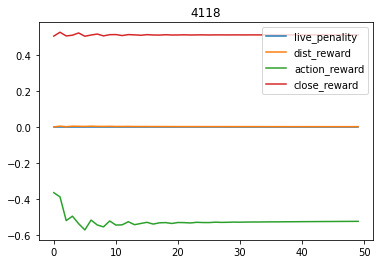

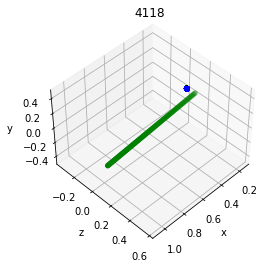

| eval  | E: 113 | S: 4118 | R: -0.7208
| train | E: 114 | S: 4118 | R: -17.5457 | D: 21.9 s | BR: -0.6522 | ALOSS: -9.6624 | CLOSS: 1.1272 | TLOSS: -6.5033 | TVAL: 0.3049 | AENT: -4.0000
| train | E: 115 | S: 4153 | R: -2.9008 | D: 54.8 s | BR: -0.5819 | ALOSS: -10.0035 | CLOSS: 0.9883 | TLOSS: -6.5207 | TVAL: 0.3018 | AENT: -4.0000
| train | E: 116 | S: 4201 | R: -18.5255 | D: 30.6 s | BR: -0.6212 | ALOSS: -9.8382 | CLOSS: 0.8662 | TLOSS: -6.6076 | TVAL: 0.2983 | AENT: -4.0000
| train | E: 117 | S: 4225 | R: -3.6484 | D: 15.7 s | BR: -0.6618 | ALOSS: -9.7919 | CLOSS: 0.9316 | TLOSS: -6.5145 | TVAL: 0.2952 | AENT: -4.0000
| train | E: 118 | S: 4255 | R: 1.6293 | D: 19.1 s | BR: -0.6216 | ALOSS: -9.7695 | CLOSS: 0.9441 | TLOSS: -6.6840 | TVAL: 0.2930 | AENT: -4.0000
| train | E: 119 | S: 4299 | R: -12.2646 | D: 27.7 s | BR: -0.6348 | ALOSS: -9.7050 | CLOSS: 0.9343 | TLOSS: -6.6612 | TVAL: 0.2899 | AENT: -4.0000
| train | E: 120 | S: 4332 | R: -4.2862 | D: 21.1 s | BR: -0.5962 | ALOSS: 

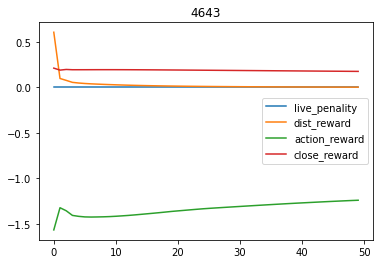

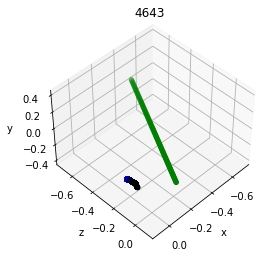

| eval  | E: 129 | S: 4643 | R: -56.2383
| train | E: 130 | S: 4643 | R: 0.7865 | D: 17.4 s | BR: -0.5689 | ALOSS: -9.5199 | CLOSS: 0.8330 | TLOSS: -7.0267 | TVAL: 0.2621 | AENT: -4.0000
| train | E: 131 | S: 4681 | R: -6.2686 | D: 58.0 s | BR: -0.5768 | ALOSS: -9.7325 | CLOSS: 0.8713 | TLOSS: -7.1728 | TVAL: 0.2597 | AENT: -4.0000
| train | E: 132 | S: 4707 | R: 7.0182 | D: 16.7 s | BR: -0.5655 | ALOSS: -9.4782 | CLOSS: 0.7893 | TLOSS: -7.0199 | TVAL: 0.2573 | AENT: -4.0000
| train | E: 133 | S: 4747 | R: -7.8642 | D: 25.0 s | BR: -0.5656 | ALOSS: -9.6650 | CLOSS: 0.6893 | TLOSS: -7.1509 | TVAL: 0.2550 | AENT: -4.0000
| train | E: 134 | S: 4785 | R: -12.3341 | D: 23.9 s | BR: -0.5553 | ALOSS: -9.7084 | CLOSS: 0.6289 | TLOSS: -7.2955 | TVAL: 0.2522 | AENT: -4.0000
| train | E: 135 | S: 4815 | R: -0.8615 | D: 20.0 s | BR: -0.5469 | ALOSS: -9.4817 | CLOSS: 0.7368 | TLOSS: -7.2622 | TVAL: 0.2497 | AENT: -4.0000
| train | E: 136 | S: 4852 | R: -16.8059 | D: 23.6 s | BR: -0.5555 | ALOSS: -9

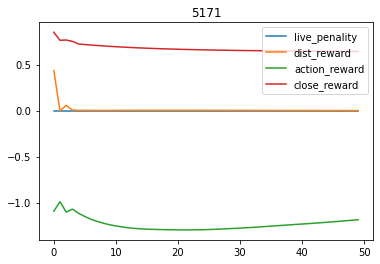

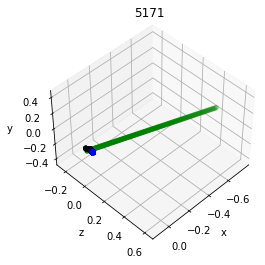

| eval  | E: 145 | S: 5171 | R: -27.4349
| train | E: 146 | S: 5171 | R: -0.3579 | D: 21.9 s | BR: -0.4987 | ALOSS: -9.2350 | CLOSS: 0.6395 | TLOSS: -7.8136 | TVAL: 0.2257 | AENT: -4.0000
| train | E: 147 | S: 5206 | R: -7.0944 | D: 52.4 s | BR: -0.5209 | ALOSS: -9.1630 | CLOSS: 0.5387 | TLOSS: -7.8117 | TVAL: 0.2235 | AENT: -4.0000
| train | E: 148 | S: 5231 | R: 2.0704 | D: 16.0 s | BR: -0.4950 | ALOSS: -9.4099 | CLOSS: 0.4458 | TLOSS: -7.8599 | TVAL: 0.2216 | AENT: -4.0000
| train | E: 149 | S: 5257 | R: 8.1143 | D: 18.6 s | BR: -0.5317 | ALOSS: -9.0282 | CLOSS: 0.6425 | TLOSS: -7.7263 | TVAL: 0.2200 | AENT: -4.0000
| train | E: 150 | S: 5299 | R: -12.7769 | D: 25.6 s | BR: -0.5186 | ALOSS: -9.1665 | CLOSS: 0.5572 | TLOSS: -7.8074 | TVAL: 0.2178 | AENT: -4.0000
| train | E: 151 | S: 5329 | R: -2.1538 | D: 19.4 s | BR: -0.5537 | ALOSS: -8.7244 | CLOSS: 0.5670 | TLOSS: -7.8820 | TVAL: 0.2156 | AENT: -4.0000
| train | E: 152 | S: 5356 | R: 1.8352 | D: 17.6 s | BR: -0.5240 | ALOSS: -8.8

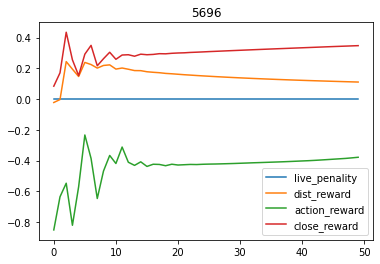

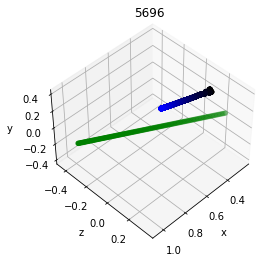

| eval  | E: 162 | S: 5696 | R: 0.6451
| train | E: 163 | S: 5696 | R: -0.2337 | D: 20.4 s | BR: -0.4962 | ALOSS: -8.3853 | CLOSS: 0.4958 | TLOSS: -8.3510 | TVAL: 0.1941 | AENT: -4.0000
| train | E: 164 | S: 5718 | R: 7.4347 | D: 45.6 s | BR: -0.4856 | ALOSS: -8.5383 | CLOSS: 0.4115 | TLOSS: -8.2193 | TVAL: 0.1927 | AENT: -4.0000
| train | E: 165 | S: 5746 | R: 0.7471 | D: 19.8 s | BR: -0.5004 | ALOSS: -8.5694 | CLOSS: 0.4793 | TLOSS: -8.4458 | TVAL: 0.1913 | AENT: -4.0000
| train | E: 166 | S: 5780 | R: -6.4008 | D: 21.4 s | BR: -0.4945 | ALOSS: -8.6188 | CLOSS: 0.5447 | TLOSS: -8.3216 | TVAL: 0.1896 | AENT: -4.0000
| train | E: 167 | S: 5811 | R: 3.5699 | D: 19.4 s | BR: -0.5112 | ALOSS: -8.5219 | CLOSS: 0.4057 | TLOSS: -8.4251 | TVAL: 0.1879 | AENT: -4.0000
| train | E: 168 | S: 5849 | R: -8.4071 | D: 23.5 s | BR: -0.5173 | ALOSS: -8.3229 | CLOSS: 0.4561 | TLOSS: -8.4860 | TVAL: 0.1860 | AENT: -4.0000
| train | E: 169 | S: 5882 | R: -6.5123 | D: 23.4 s | BR: -0.5106 | ALOSS: -8.2925

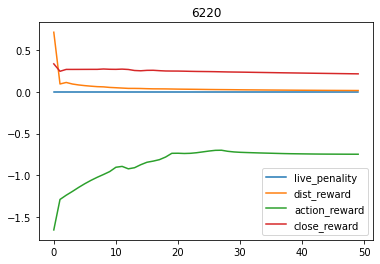

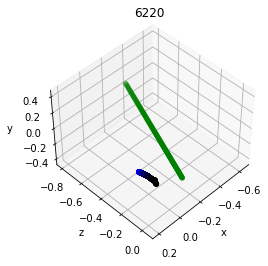

| eval  | E: 178 | S: 6220 | R: -27.3665
| train | E: 179 | S: 6220 | R: 8.2922 | D: 17.4 s | BR: -0.4864 | ALOSS: -7.8667 | CLOSS: 0.3429 | TLOSS: -8.8920 | TVAL: 0.1670 | AENT: -4.0000
| train | E: 180 | S: 6244 | R: 3.9461 | D: 49.6 s | BR: -0.4543 | ALOSS: -7.9097 | CLOSS: 0.3673 | TLOSS: -8.8465 | TVAL: 0.1658 | AENT: -4.0000
| train | E: 181 | S: 6279 | R: -10.0385 | D: 23.9 s | BR: -0.4518 | ALOSS: -7.8034 | CLOSS: 0.3454 | TLOSS: -9.0360 | TVAL: 0.1644 | AENT: -4.0000
| train | E: 182 | S: 6304 | R: 7.3625 | D: 16.4 s | BR: -0.4418 | ALOSS: -7.9621 | CLOSS: 0.3924 | TLOSS: -8.8238 | TVAL: 0.1629 | AENT: -4.0000
| train | E: 183 | S: 6335 | R: 0.1174 | D: 22.0 s | BR: -0.4596 | ALOSS: -7.7041 | CLOSS: 0.3705 | TLOSS: -8.9922 | TVAL: 0.1616 | AENT: -4.0000
| train | E: 184 | S: 6363 | R: 6.5089 | D: 17.8 s | BR: -0.4396 | ALOSS: -7.6437 | CLOSS: 0.4028 | TLOSS: -9.0461 | TVAL: 0.1603 | AENT: -4.0000
| train | E: 185 | S: 6391 | R: 5.9825 | D: 19.7 s | BR: -0.4632 | ALOSS: -7.6101

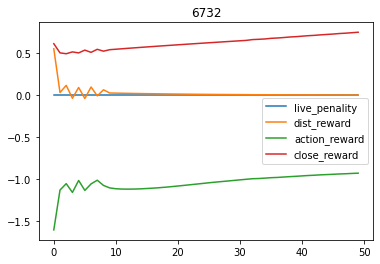

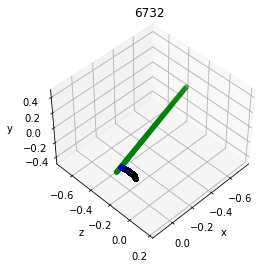

| eval  | E: 194 | S: 6732 | R: -20.2937
| train | E: 195 | S: 6732 | R: -1.8567 | D: 21.6 s | BR: -0.4527 | ALOSS: -7.2859 | CLOSS: 0.3354 | TLOSS: -9.2882 | TVAL: 0.1444 | AENT: -4.0000
| train | E: 196 | S: 6761 | R: 7.8838 | D: 52.1 s | BR: -0.4757 | ALOSS: -6.8344 | CLOSS: 0.3463 | TLOSS: -9.1563 | TVAL: 0.1432 | AENT: -4.0000
| train | E: 197 | S: 6783 | R: 7.4455 | D: 14.6 s | BR: -0.4141 | ALOSS: -6.8853 | CLOSS: 0.3517 | TLOSS: -9.1890 | TVAL: 0.1422 | AENT: -4.0000
| train | E: 198 | S: 6807 | R: 2.6364 | D: 17.0 s | BR: -0.3862 | ALOSS: -7.2053 | CLOSS: 0.3583 | TLOSS: -9.3125 | TVAL: 0.1413 | AENT: -4.0000
| train | E: 199 | S: 6857 | R: -30.6075 | D: 31.2 s | BR: -0.4526 | ALOSS: -6.9916 | CLOSS: 0.3020 | TLOSS: -9.1874 | TVAL: 0.1398 | AENT: -4.0000
| train | E: 200 | S: 6888 | R: 0.2976 | D: 22.3 s | BR: -0.4302 | ALOSS: -6.9244 | CLOSS: 0.3663 | TLOSS: -9.4258 | TVAL: 0.1382 | AENT: -4.0000
| train | E: 201 | S: 6932 | R: -6.9083 | D: 27.8 s | BR: -0.4257 | ALOSS: -6.93

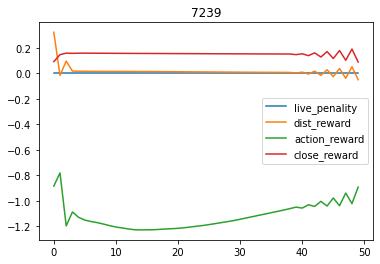

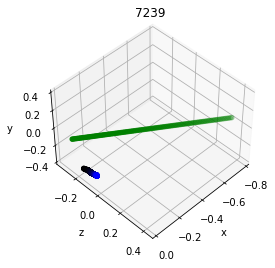

| eval  | E: 210 | S: 7239 | R: -47.7580
| train | E: 211 | S: 7239 | R: -8.3048 | D: 24.5 s | BR: -0.3899 | ALOSS: -6.4024 | CLOSS: 0.2971 | TLOSS: -9.3774 | TVAL: 0.1254 | AENT: -4.0000
| train | E: 212 | S: 7267 | R: -2.7625 | D: 48.9 s | BR: -0.4262 | ALOSS: -6.5109 | CLOSS: 0.3791 | TLOSS: -9.4672 | TVAL: 0.1242 | AENT: -4.0000
| train | E: 213 | S: 7295 | R: 0.2738 | D: 17.8 s | BR: -0.4232 | ALOSS: -6.3546 | CLOSS: 0.2943 | TLOSS: -9.5488 | TVAL: 0.1233 | AENT: -4.0000
| train | E: 214 | S: 7328 | R: 1.0916 | D: 22.8 s | BR: -0.3900 | ALOSS: -6.3741 | CLOSS: 0.2517 | TLOSS: -9.6464 | TVAL: 0.1222 | AENT: -4.0000
| train | E: 215 | S: 7353 | R: 8.1369 | D: 16.3 s | BR: -0.3930 | ALOSS: -6.0702 | CLOSS: 0.3500 | TLOSS: -9.4821 | TVAL: 0.1212 | AENT: -4.0000
| train | E: 216 | S: 7377 | R: 10.6641 | D: 16.0 s | BR: -0.4152 | ALOSS: -6.3647 | CLOSS: 0.2992 | TLOSS: -9.2262 | TVAL: 0.1204 | AENT: -4.0000
| train | E: 217 | S: 7400 | R: 7.1360 | D: 15.2 s | BR: -0.3873 | ALOSS: -6.299

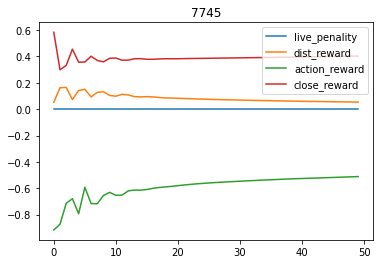

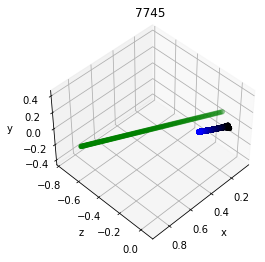

| eval  | E: 227 | S: 7745 | R: -6.0300
| train | E: 228 | S: 7745 | R: -3.4798 | D: 26.8 s | BR: -0.3685 | ALOSS: -5.9625 | CLOSS: 0.2611 | TLOSS: -9.3434 | TVAL: 0.1091 | AENT: -4.0000
| train | E: 229 | S: 7777 | R: 3.5492 | D: 53.3 s | BR: -0.3952 | ALOSS: -5.7260 | CLOSS: 0.2467 | TLOSS: -9.4445 | TVAL: 0.1080 | AENT: -4.0000
| train | E: 230 | S: 7801 | R: 0.9859 | D: 15.3 s | BR: -0.3652 | ALOSS: -5.9440 | CLOSS: 0.2506 | TLOSS: -9.6689 | TVAL: 0.1072 | AENT: -4.0000
| train | E: 231 | S: 7842 | R: -6.7606 | D: 26.2 s | BR: -0.3989 | ALOSS: -5.7528 | CLOSS: 0.2480 | TLOSS: -9.3660 | TVAL: 0.1063 | AENT: -4.0000
| train | E: 232 | S: 7884 | R: -8.0314 | D: 26.1 s | BR: -0.3735 | ALOSS: -5.6147 | CLOSS: 0.2693 | TLOSS: -9.5130 | TVAL: 0.1051 | AENT: -4.0000
| train | E: 233 | S: 7918 | R: -0.5996 | D: 21.6 s | BR: -0.3588 | ALOSS: -5.6778 | CLOSS: 0.2536 | TLOSS: -9.4155 | TVAL: 0.1040 | AENT: -4.0000
| train | E: 234 | S: 7943 | R: 5.1993 | D: 17.3 s | BR: -0.3544 | ALOSS: -5.490

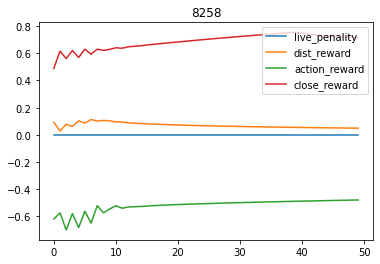

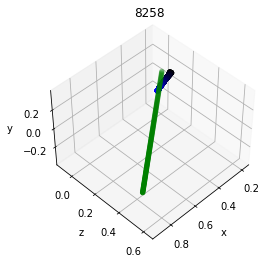

| eval  | E: 244 | S: 8258 | R: 11.6607
| train | E: 245 | S: 8258 | R: -9.4850 | D: 25.2 s | BR: -0.3443 | ALOSS: -5.1842 | CLOSS: 0.2495 | TLOSS: -9.6694 | TVAL: 0.0949 | AENT: -4.0000
| train | E: 246 | S: 8278 | R: 7.6683 | D: 45.2 s | BR: -0.3313 | ALOSS: -5.1670 | CLOSS: 0.2538 | TLOSS: -9.7064 | TVAL: 0.0942 | AENT: -4.0000
| train | E: 247 | S: 8307 | R: 7.6425 | D: 19.1 s | BR: -0.3488 | ALOSS: -5.1509 | CLOSS: 0.2842 | TLOSS: -9.5620 | TVAL: 0.0935 | AENT: -4.0000
| train | E: 248 | S: 8332 | R: 2.2121 | D: 16.7 s | BR: -0.3474 | ALOSS: -5.1056 | CLOSS: 0.2472 | TLOSS: -9.6213 | TVAL: 0.0929 | AENT: -4.0000
| train | E: 249 | S: 8362 | R: -1.3068 | D: 21.2 s | BR: -0.3726 | ALOSS: -4.9796 | CLOSS: 0.2423 | TLOSS: -9.4136 | TVAL: 0.0922 | AENT: -4.0000
| train | E: 250 | S: 8385 | R: 7.6079 | D: 14.8 s | BR: -0.3095 | ALOSS: -5.1413 | CLOSS: 0.2198 | TLOSS: -9.6731 | TVAL: 0.0915 | AENT: -4.0000
| train | E: 251 | S: 8418 | R: 6.4567 | D: 20.7 s | BR: -0.3395 | ALOSS: -5.1479 

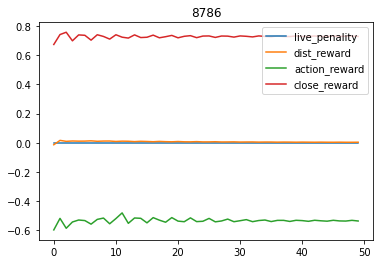

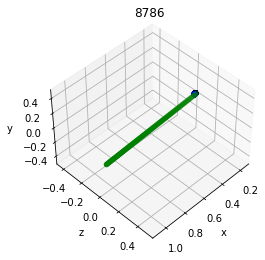

| eval  | E: 263 | S: 8786 | R: 10.0288
| train | E: 264 | S: 8786 | R: 2.2647 | D: 19.9 s | BR: -0.3248 | ALOSS: -4.7845 | CLOSS: 0.2380 | TLOSS: -9.2816 | TVAL: 0.0823 | AENT: -4.0000
| train | E: 265 | S: 8808 | R: 9.9595 | D: 49.5 s | BR: -0.3141 | ALOSS: -4.6945 | CLOSS: 0.2328 | TLOSS: -9.6156 | TVAL: 0.0817 | AENT: -4.0000
| train | E: 266 | S: 8836 | R: 11.7767 | D: 17.4 s | BR: -0.3213 | ALOSS: -4.6059 | CLOSS: 0.2159 | TLOSS: -9.1372 | TVAL: 0.0812 | AENT: -4.0000
| train | E: 267 | S: 8863 | R: 7.8351 | D: 17.5 s | BR: -0.3362 | ALOSS: -4.6094 | CLOSS: 0.2200 | TLOSS: -9.0942 | TVAL: 0.0806 | AENT: -4.0000
| train | E: 268 | S: 8895 | R: 1.8083 | D: 20.0 s | BR: -0.3167 | ALOSS: -4.6364 | CLOSS: 0.2332 | TLOSS: -9.6071 | TVAL: 0.0800 | AENT: -4.0000
| train | E: 269 | S: 8921 | R: 10.5394 | D: 17.6 s | BR: -0.3010 | ALOSS: -4.5592 | CLOSS: 0.2086 | TLOSS: -9.1853 | TVAL: 0.0794 | AENT: -4.0000
| train | E: 270 | S: 8953 | R: -4.9482 | D: 22.8 s | BR: -0.3289 | ALOSS: -4.5367

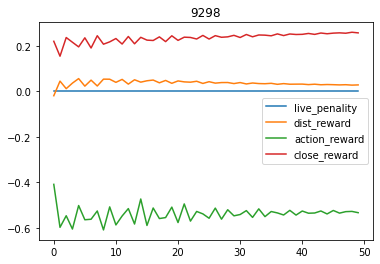

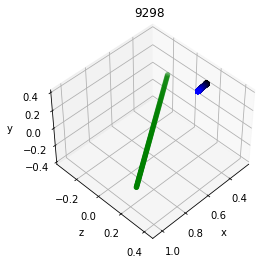

| eval  | E: 280 | S: 9298 | R: -13.2756
| train | E: 281 | S: 9298 | R: 12.5032 | D: 12.9 s | BR: -0.3034 | ALOSS: -4.3506 | CLOSS: 0.1801 | TLOSS: -9.4347 | TVAL: 0.0718 | AENT: -4.0000
| train | E: 282 | S: 9319 | R: 6.3141 | D: 49.4 s | BR: -0.3028 | ALOSS: -4.3583 | CLOSS: 0.2067 | TLOSS: -9.6794 | TVAL: 0.0714 | AENT: -4.0000
| train | E: 283 | S: 9344 | R: 10.0127 | D: 18.0 s | BR: -0.3105 | ALOSS: -4.4691 | CLOSS: 0.1987 | TLOSS: -9.3841 | TVAL: 0.0709 | AENT: -4.0000
| train | E: 284 | S: 9387 | R: -14.8567 | D: 26.8 s | BR: -0.2779 | ALOSS: -4.3059 | CLOSS: 0.2434 | TLOSS: -9.1369 | TVAL: 0.0703 | AENT: -4.0000
| train | E: 285 | S: 9407 | R: 8.8802 | D: 15.2 s | BR: -0.3327 | ALOSS: -4.3448 | CLOSS: 0.2589 | TLOSS: -9.2050 | TVAL: 0.0697 | AENT: -4.0000
| train | E: 286 | S: 9433 | R: 6.5822 | D: 17.6 s | BR: -0.2549 | ALOSS: -4.3089 | CLOSS: 0.2137 | TLOSS: -9.1024 | TVAL: 0.0693 | AENT: -4.0000
| train | E: 287 | S: 9458 | R: 2.6335 | D: 17.4 s | BR: -0.2717 | ALOSS: -4.24

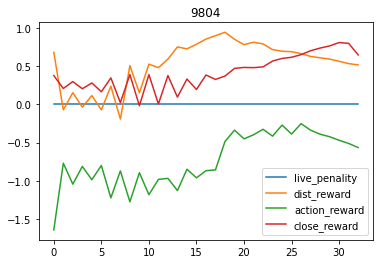

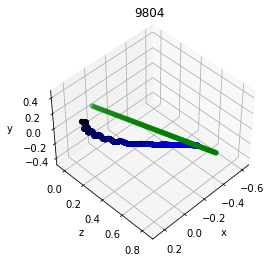

| eval  | E: 300 | S: 9804 | R: 6.8219
| train | E: 301 | S: 9804 | R: 8.6821 | D: 17.4 s | BR: -0.2443 | ALOSS: -4.1014 | CLOSS: 0.1979 | TLOSS: -8.8973 | TVAL: 0.0629 | AENT: -4.0000
| train | E: 302 | S: 9824 | R: 8.5725 | D: 36.2 s | BR: -0.3097 | ALOSS: -3.8605 | CLOSS: 0.2177 | TLOSS: -8.3518 | TVAL: 0.0626 | AENT: -4.0000
| train | E: 303 | S: 9846 | R: 11.1917 | D: 14.5 s | BR: -0.2524 | ALOSS: -4.1167 | CLOSS: 0.2187 | TLOSS: -9.3021 | TVAL: 0.0622 | AENT: -4.0000
| train | E: 304 | S: 9873 | R: 7.5607 | D: 19.3 s | BR: -0.2856 | ALOSS: -4.0197 | CLOSS: 0.1695 | TLOSS: -8.7220 | TVAL: 0.0618 | AENT: -4.0000
| train | E: 305 | S: 9899 | R: 13.2001 | D: 16.3 s | BR: -0.2217 | ALOSS: -4.0724 | CLOSS: 0.2395 | TLOSS: -8.9866 | TVAL: 0.0614 | AENT: -4.0000
| train | E: 306 | S: 9922 | R: -2.0903 | D: 15.3 s | BR: -0.2780 | ALOSS: -3.9653 | CLOSS: 0.2291 | TLOSS: -8.9251 | TVAL: 0.0610 | AENT: -4.0000
| train | E: 307 | S: 9945 | R: 10.0200 | D: 15.1 s | BR: -0.2614 | ALOSS: -3.9845

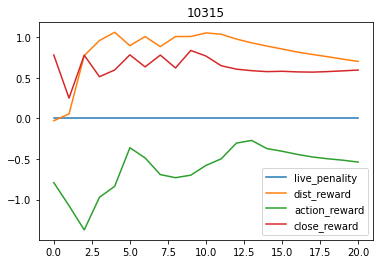

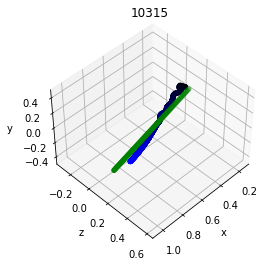

| eval  | E: 321 | S: 10315 | R: 17.5168
| train | E: 322 | S: 10315 | R: -0.1420 | D: 15.7 s | BR: -0.2436 | ALOSS: -3.9120 | CLOSS: 0.1808 | TLOSS: -8.2996 | TVAL: 0.0553 | AENT: -4.0000
| train | E: 323 | S: 10333 | R: 9.0872 | D: 28.0 s | BR: -0.2518 | ALOSS: -3.7524 | CLOSS: 0.2106 | TLOSS: -8.5661 | TVAL: 0.0551 | AENT: -4.0000
| train | E: 324 | S: 10355 | R: 1.3527 | D: 14.7 s | BR: -0.2055 | ALOSS: -4.0405 | CLOSS: 0.1979 | TLOSS: -8.5169 | TVAL: 0.0548 | AENT: -4.0000
| train | E: 325 | S: 10378 | R: 9.0180 | D: 15.0 s | BR: -0.2173 | ALOSS: -3.8417 | CLOSS: 0.1600 | TLOSS: -8.5998 | TVAL: 0.0545 | AENT: -4.0000
| train | E: 326 | S: 10402 | R: 4.3748 | D: 16.0 s | BR: -0.2129 | ALOSS: -3.8800 | CLOSS: 0.2077 | TLOSS: -8.1311 | TVAL: 0.0541 | AENT: -4.0000
| train | E: 327 | S: 10422 | R: 8.4140 | D: 15.2 s | BR: -0.2364 | ALOSS: -3.7435 | CLOSS: 0.1784 | TLOSS: -8.3175 | TVAL: 0.0539 | AENT: -4.0000
| train | E: 328 | S: 10444 | R: 9.7180 | D: 15.7 s | BR: -0.2362 | ALOSS: -

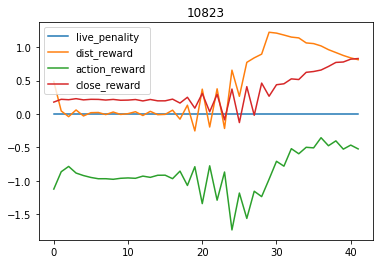

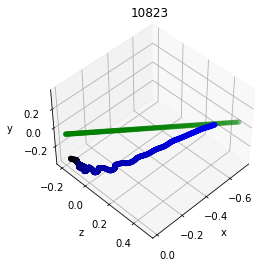

| eval  | E: 345 | S: 10823 | R: -5.6760
| train | E: 346 | S: 10823 | R: 1.6286 | D: 14.0 s | BR: -0.1963 | ALOSS: -3.8374 | CLOSS: 0.1600 | TLOSS: -7.3398 | TVAL: 0.0489 | AENT: -4.0000
| train | E: 347 | S: 10843 | R: 8.3307 | D: 39.7 s | BR: -0.1780 | ALOSS: -3.8987 | CLOSS: 0.2144 | TLOSS: -7.4570 | TVAL: 0.0486 | AENT: -4.0000
| train | E: 348 | S: 10867 | R: -2.2740 | D: 15.8 s | BR: -0.2174 | ALOSS: -3.9221 | CLOSS: 0.2205 | TLOSS: -7.2768 | TVAL: 0.0484 | AENT: -4.0000
| train | E: 349 | S: 10882 | R: 9.0654 | D: 10.9 s | BR: -0.2107 | ALOSS: -3.9801 | CLOSS: 0.1681 | TLOSS: -7.8883 | TVAL: 0.0482 | AENT: -4.0000
| train | E: 350 | S: 10899 | R: 12.0991 | D: 11.4 s | BR: -0.2403 | ALOSS: -3.8570 | CLOSS: 0.1684 | TLOSS: -6.9724 | TVAL: 0.0480 | AENT: -4.0000
| train | E: 351 | S: 10915 | R: 12.3165 | D: 11.3 s | BR: -0.2303 | ALOSS: -3.9089 | CLOSS: 0.1602 | TLOSS: -7.3892 | TVAL: 0.0478 | AENT: -4.0000
| train | E: 352 | S: 10932 | R: 10.6147 | D: 12.1 s | BR: -0.1923 | ALOSS

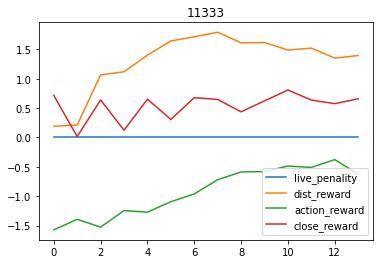

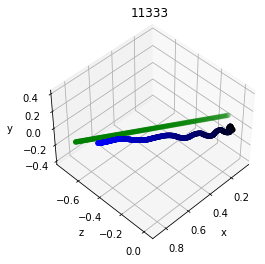

| eval  | E: 371 | S: 11333 | R: 12.6426
| train | E: 372 | S: 11333 | R: 3.6681 | D: 16.2 s | BR: -0.2047 | ALOSS: -3.9899 | CLOSS: 0.2234 | TLOSS: -6.9501 | TVAL: 0.0436 | AENT: -4.0000
| train | E: 373 | S: 11361 | R: -8.2974 | D: 28.8 s | BR: -0.1775 | ALOSS: -3.9877 | CLOSS: 0.1802 | TLOSS: -6.2591 | TVAL: 0.0433 | AENT: -4.0000
| train | E: 374 | S: 11385 | R: -0.9235 | D: 16.9 s | BR: -0.1936 | ALOSS: -3.8024 | CLOSS: 0.1848 | TLOSS: -6.4117 | TVAL: 0.0431 | AENT: -4.0000
| train | E: 375 | S: 11399 | R: 14.7698 | D: 10.2 s | BR: -0.1831 | ALOSS: -4.0273 | CLOSS: 0.1657 | TLOSS: -6.3819 | TVAL: 0.0429 | AENT: -4.0000
| train | E: 376 | S: 11414 | R: 12.8781 | D: 11.2 s | BR: -0.2163 | ALOSS: -3.9514 | CLOSS: 0.1740 | TLOSS: -6.7553 | TVAL: 0.0428 | AENT: -4.0000
| train | E: 377 | S: 11434 | R: 6.3538 | D: 13.5 s | BR: -0.2305 | ALOSS: -3.9618 | CLOSS: 0.2634 | TLOSS: -6.5852 | TVAL: 0.0426 | AENT: -4.0000
| train | E: 378 | S: 11459 | R: 2.7626 | D: 17.7 s | BR: -0.2017 | ALOSS

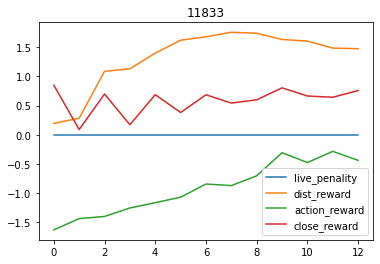

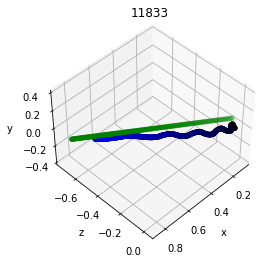

| eval  | E: 396 | S: 11833 | R: 12.7599
| train | E: 397 | S: 11833 | R: 8.4068 | D: 15.4 s | BR: -0.1968 | ALOSS: -3.9748 | CLOSS: 0.2174 | TLOSS: -6.0244 | TVAL: 0.0393 | AENT: -4.0000
| train | E: 398 | S: 11848 | R: 13.0981 | D: 21.3 s | BR: -0.1609 | ALOSS: -4.3167 | CLOSS: 0.1817 | TLOSS: -4.2873 | TVAL: 0.0391 | AENT: -4.0000
| train | E: 399 | S: 11863 | R: 11.2098 | D: 11.7 s | BR: -0.1364 | ALOSS: -4.2233 | CLOSS: 0.1767 | TLOSS: -5.1241 | TVAL: 0.0390 | AENT: -4.0000
| train | E: 400 | S: 11877 | R: 6.0057 | D: 09.8 s | BR: -0.1344 | ALOSS: -4.1470 | CLOSS: 0.2649 | TLOSS: -5.5451 | TVAL: 0.0389 | AENT: -4.0000
| train | E: 401 | S: 11891 | R: 14.5499 | D: 09.9 s | BR: -0.2394 | ALOSS: -3.9927 | CLOSS: 0.2990 | TLOSS: -5.4296 | TVAL: 0.0388 | AENT: -4.0000
| train | E: 402 | S: 11907 | R: 10.1501 | D: 11.2 s | BR: -0.2042 | ALOSS: -3.9088 | CLOSS: 0.2099 | TLOSS: -5.0866 | TVAL: 0.0387 | AENT: -4.0000
| train | E: 403 | S: 11922 | R: 9.4279 | D: 10.5 s | BR: -0.1402 | ALOSS

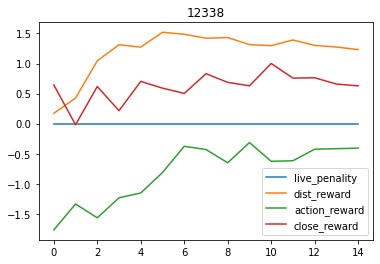

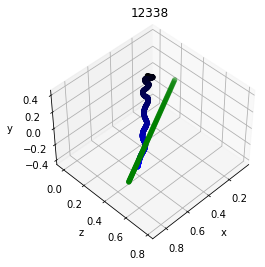

| eval  | E: 425 | S: 12338 | R: 14.9563
| train | E: 426 | S: 12338 | R: 2.3779 | D: 17.4 s | BR: -0.1464 | ALOSS: -4.3725 | CLOSS: 0.2351 | TLOSS: -4.4507 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 427 | S: 12355 | R: 13.1691 | D: 21.6 s | BR: -0.1268 | ALOSS: -4.4772 | CLOSS: 0.3298 | TLOSS: -3.9840 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 428 | S: 12378 | R: 3.6199 | D: 15.6 s | BR: -0.1332 | ALOSS: -4.6347 | CLOSS: 0.1899 | TLOSS: -4.7453 | TVAL: 0.0354 | AENT: -4.0000
| train | E: 429 | S: 12397 | R: 3.8917 | D: 14.1 s | BR: -0.1279 | ALOSS: -4.4079 | CLOSS: 0.2612 | TLOSS: -4.2792 | TVAL: 0.0353 | AENT: -4.0000
| train | E: 430 | S: 12414 | R: 13.3775 | D: 12.2 s | BR: -0.1557 | ALOSS: -4.2351 | CLOSS: 0.2271 | TLOSS: -4.3075 | TVAL: 0.0352 | AENT: -4.0000
| train | E: 431 | S: 12435 | R: 3.2525 | D: 14.1 s | BR: -0.1070 | ALOSS: -4.7814 | CLOSS: 0.2019 | TLOSS: -4.0597 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 432 | S: 12451 | R: 12.4245 | D: 11.2 s | BR: -0.1719 | ALOSS:

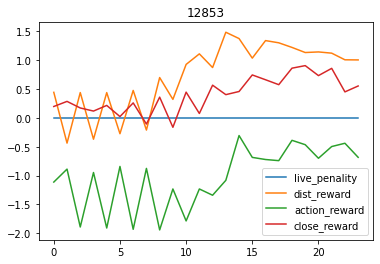

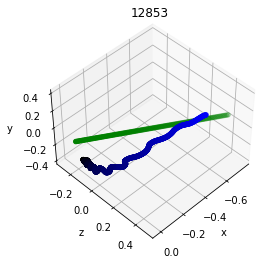

| eval  | E: 454 | S: 12853 | R: 2.6472
| train | E: 455 | S: 12853 | R: 5.4941 | D: 14.6 s | BR: -0.0951 | ALOSS: -4.7908 | CLOSS: 0.2312 | TLOSS: -3.6821 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 456 | S: 12869 | R: 14.6376 | D: 28.5 s | BR: -0.1279 | ALOSS: -4.9097 | CLOSS: 0.2107 | TLOSS: -3.8993 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 457 | S: 12889 | R: 5.1855 | D: 13.6 s | BR: -0.0847 | ALOSS: -4.7261 | CLOSS: 0.1791 | TLOSS: -3.6375 | TVAL: 0.0323 | AENT: -4.0000
| train | E: 458 | S: 12913 | R: 4.1317 | D: 17.8 s | BR: -0.1238 | ALOSS: -4.8715 | CLOSS: 0.1842 | TLOSS: -2.7174 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 459 | S: 12930 | R: 8.5898 | D: 11.6 s | BR: -0.1631 | ALOSS: -4.7772 | CLOSS: 0.2502 | TLOSS: -3.6740 | TVAL: 0.0321 | AENT: -4.0000
| train | E: 460 | S: 12946 | R: 12.0599 | D: 12.1 s | BR: -0.0873 | ALOSS: -4.7527 | CLOSS: 0.2550 | TLOSS: -4.0823 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 461 | S: 12963 | R: 14.2233 | D: 11.4 s | BR: -0.1080 | ALOSS: 

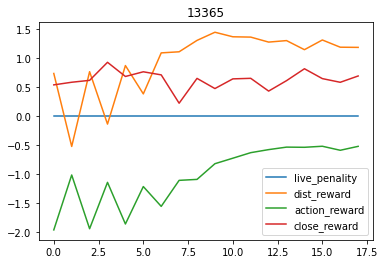

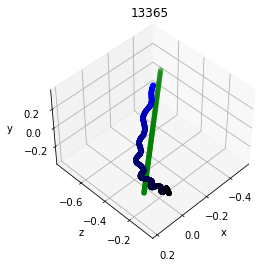

| eval  | E: 482 | S: 13365 | R: 10.1898
| train | E: 483 | S: 13365 | R: 9.5437 | D: 16.0 s | BR: -0.1560 | ALOSS: -5.0171 | CLOSS: 0.2237 | TLOSS: -2.4519 | TVAL: 0.0299 | AENT: -4.0000
| train | E: 484 | S: 13381 | R: 13.4080 | D: 23.8 s | BR: -0.1109 | ALOSS: -5.0028 | CLOSS: 0.1900 | TLOSS: -3.6614 | TVAL: 0.0298 | AENT: -4.0000
| train | E: 485 | S: 13396 | R: 8.9453 | D: 10.4 s | BR: -0.0610 | ALOSS: -5.3000 | CLOSS: 0.1893 | TLOSS: -2.8218 | TVAL: 0.0298 | AENT: -4.0000
| train | E: 486 | S: 13413 | R: 9.4406 | D: 12.0 s | BR: -0.1049 | ALOSS: -5.1386 | CLOSS: 0.2188 | TLOSS: -3.0449 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 487 | S: 13433 | R: 0.1501 | D: 14.3 s | BR: -0.0619 | ALOSS: -5.0787 | CLOSS: 0.2173 | TLOSS: -3.2334 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 488 | S: 13453 | R: 8.4291 | D: 13.0 s | BR: -0.0666 | ALOSS: -5.4335 | CLOSS: 0.2546 | TLOSS: -2.6632 | TVAL: 0.0295 | AENT: -4.0000
| train | E: 489 | S: 13470 | R: 12.1991 | D: 11.2 s | BR: -0.0728 | ALOSS: 

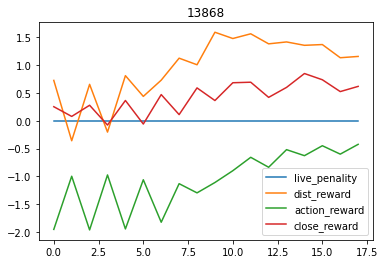

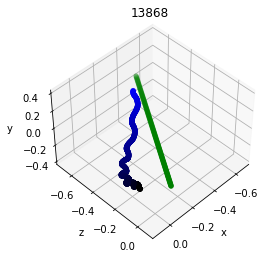

| eval  | E: 509 | S: 13868 | R: 5.5865
| train | E: 510 | S: 13868 | R: 13.9165 | D: 11.2 s | BR: -0.0753 | ALOSS: -5.5031 | CLOSS: 0.2075 | TLOSS: -2.0712 | TVAL: 0.0278 | AENT: -4.0000
| train | E: 511 | S: 13886 | R: 8.8263 | D: 26.9 s | BR: -0.0259 | ALOSS: -5.4581 | CLOSS: 0.1783 | TLOSS: -2.1524 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 512 | S: 13905 | R: 3.2512 | D: 13.3 s | BR: -0.0233 | ALOSS: -5.4103 | CLOSS: 0.1791 | TLOSS: -1.1223 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 513 | S: 13920 | R: 13.8435 | D: 11.1 s | BR: -0.1014 | ALOSS: -5.4498 | CLOSS: 0.1671 | TLOSS: -1.7592 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 514 | S: 13937 | R: 12.7886 | D: 11.5 s | BR: -0.0657 | ALOSS: -5.7228 | CLOSS: 0.1464 | TLOSS: -2.6531 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 515 | S: 13955 | R: 13.1160 | D: 12.0 s | BR: -0.1051 | ALOSS: -5.4646 | CLOSS: 0.2177 | TLOSS: -1.9955 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 516 | S: 13978 | R: 1.4062 | D: 14.6 s | BR: -0.1108 | ALOSS:

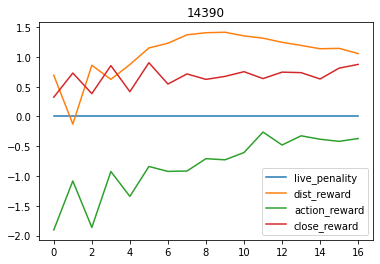

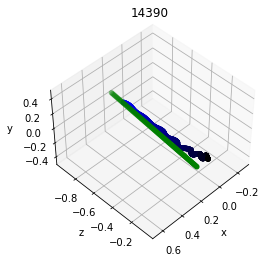

| eval  | E: 538 | S: 14390 | R: 15.1893
| train | E: 539 | S: 14390 | R: -1.4838 | D: 17.4 s | BR: -0.0576 | ALOSS: -5.6102 | CLOSS: 0.1870 | TLOSS: -0.9896 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 540 | S: 14411 | R: 8.9534 | D: 25.3 s | BR: -0.0270 | ALOSS: -5.7910 | CLOSS: 0.1619 | TLOSS: -2.0342 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 541 | S: 14432 | R: 9.9832 | D: 14.1 s | BR: -0.0290 | ALOSS: -5.7257 | CLOSS: 0.1690 | TLOSS: -1.3915 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 542 | S: 14449 | R: 8.0150 | D: 11.7 s | BR: -0.0676 | ALOSS: -5.7777 | CLOSS: 0.1893 | TLOSS: -1.6728 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 543 | S: 14466 | R: 12.2576 | D: 11.5 s | BR: -0.0211 | ALOSS: -5.7699 | CLOSS: 0.1745 | TLOSS: -1.3496 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 544 | S: 14481 | R: 12.4169 | D: 10.5 s | BR: -0.1243 | ALOSS: -5.6395 | CLOSS: 0.1924 | TLOSS: -1.8510 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 545 | S: 14499 | R: 9.4491 | D: 13.5 s | BR: -0.0308 | ALOSS:

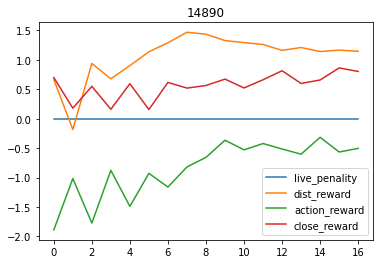

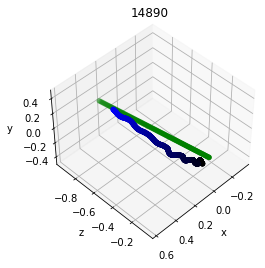

| eval  | E: 565 | S: 14890 | R: 13.2278
| train | E: 566 | S: 14890 | R: 13.6764 | D: 12.0 s | BR: -0.0425 | ALOSS: -6.0016 | CLOSS: 0.1837 | TLOSS: -1.7716 | TVAL: 0.0246 | AENT: -4.0000
| train | E: 567 | S: 14912 | R: 9.3342 | D: 26.4 s | BR: 0.0089 | ALOSS: -6.0409 | CLOSS: 0.1588 | TLOSS: -1.1755 | TVAL: 0.0245 | AENT: -4.0000
| train | E: 568 | S: 14929 | R: 12.8345 | D: 13.6 s | BR: -0.0137 | ALOSS: -5.9163 | CLOSS: 0.1418 | TLOSS: -0.6240 | TVAL: 0.0245 | AENT: -4.0000
| train | E: 569 | S: 14947 | R: 12.6264 | D: 13.0 s | BR: -0.0173 | ALOSS: -6.2439 | CLOSS: 0.1632 | TLOSS: -0.8018 | TVAL: 0.0245 | AENT: -4.0000
| train | E: 570 | S: 14967 | R: 6.7267 | D: 16.2 s | BR: -0.0816 | ALOSS: -5.8658 | CLOSS: 0.1831 | TLOSS: -0.8207 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 571 | S: 14984 | R: 13.4332 | D: 11.7 s | BR: -0.0827 | ALOSS: -5.9675 | CLOSS: 0.1720 | TLOSS: -0.7638 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 572 | S: 15000 | R: 14.1835 | D: 10.8 s | BR: -0.0132 | ALOSS

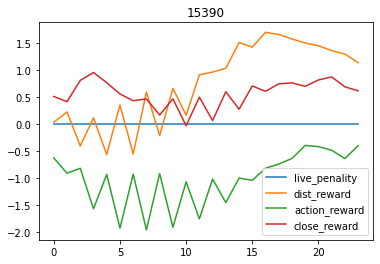

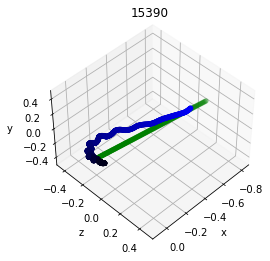

| eval  | E: 592 | S: 15390 | R: 7.1920
| train | E: 593 | S: 15390 | R: 9.7951 | D: 12.3 s | BR: 0.0099 | ALOSS: -6.1356 | CLOSS: 0.1438 | TLOSS: -1.0797 | TVAL: 0.0236 | AENT: -4.0000
| train | E: 594 | S: 15405 | R: 15.3237 | D: 27.0 s | BR: 0.0172 | ALOSS: -6.4319 | CLOSS: 0.1798 | TLOSS: -0.4319 | TVAL: 0.0236 | AENT: -4.0000
| train | E: 595 | S: 15429 | R: 1.3957 | D: 15.7 s | BR: -0.0324 | ALOSS: -6.1722 | CLOSS: 0.1358 | TLOSS: -1.2009 | TVAL: 0.0235 | AENT: -4.0000
| train | E: 596 | S: 15448 | R: 14.1818 | D: 12.3 s | BR: -0.0161 | ALOSS: -6.0764 | CLOSS: 0.1538 | TLOSS: -0.8320 | TVAL: 0.0235 | AENT: -4.0000
| train | E: 597 | S: 15467 | R: 11.8761 | D: 13.4 s | BR: -0.0171 | ALOSS: -5.9650 | CLOSS: 0.1829 | TLOSS: -0.6252 | TVAL: 0.0234 | AENT: -4.0000
| train | E: 598 | S: 15488 | R: 10.9440 | D: 16.1 s | BR: -0.0708 | ALOSS: -6.2737 | CLOSS: 0.2116 | TLOSS: -0.9031 | TVAL: 0.0234 | AENT: -4.0000
| train | E: 599 | S: 15514 | R: 4.6635 | D: 16.8 s | BR: -0.0105 | ALOSS: -

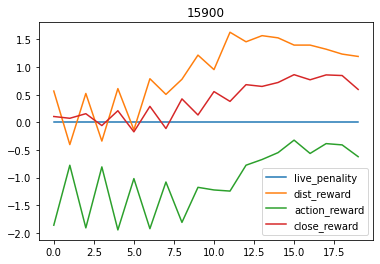

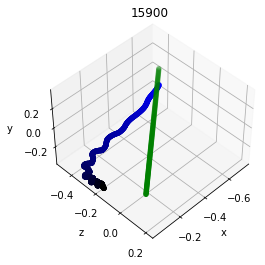

| eval  | E: 618 | S: 15900 | R: 4.7013
| train | E: 619 | S: 15900 | R: 9.0064 | D: 16.3 s | BR: -0.0026 | ALOSS: -6.2746 | CLOSS: 0.1415 | TLOSS: 0.1880 | TVAL: 0.0229 | AENT: -4.0000
| train | E: 620 | S: 15926 | R: 6.2385 | D: 31.3 s | BR: 0.0062 | ALOSS: -6.2029 | CLOSS: 0.1656 | TLOSS: -0.5665 | TVAL: 0.0228 | AENT: -4.0000
| train | E: 621 | S: 15942 | R: 14.5926 | D: 10.9 s | BR: 0.0549 | ALOSS: -6.4713 | CLOSS: 0.1419 | TLOSS: -1.0939 | TVAL: 0.0228 | AENT: -4.0000
| train | E: 622 | S: 15970 | R: 6.0691 | D: 19.6 s | BR: -0.0034 | ALOSS: -6.3851 | CLOSS: 0.1593 | TLOSS: -0.5113 | TVAL: 0.0228 | AENT: -4.0000
| train | E: 623 | S: 15987 | R: 9.6778 | D: 11.4 s | BR: 0.0030 | ALOSS: -6.1727 | CLOSS: 0.1353 | TLOSS: -0.1059 | TVAL: 0.0227 | AENT: -4.0000
| train | E: 624 | S: 16005 | R: 11.4706 | D: 12.0 s | BR: 0.0123 | ALOSS: -6.3545 | CLOSS: 0.1268 | TLOSS: -0.7762 | TVAL: 0.0227 | AENT: -4.0000
| train | E: 625 | S: 16027 | R: 8.5785 | D: 15.3 s | BR: -0.0095 | ALOSS: -6.410

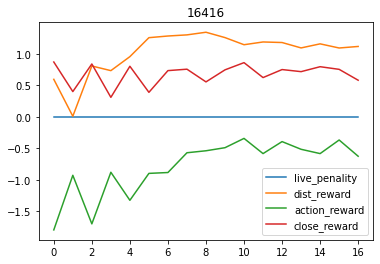

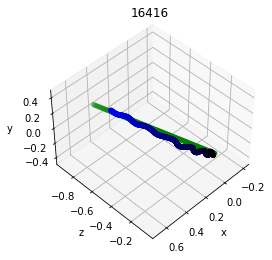

| eval  | E: 645 | S: 16416 | R: 15.5330
| train | E: 646 | S: 16416 | R: 10.5005 | D: 15.1 s | BR: 0.0260 | ALOSS: -6.4855 | CLOSS: 0.1578 | TLOSS: -0.2738 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 647 | S: 16436 | R: 15.2385 | D: 26.4 s | BR: -0.0171 | ALOSS: -6.5160 | CLOSS: 0.1250 | TLOSS: 0.2511 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 648 | S: 16452 | R: 8.8516 | D: 11.3 s | BR: 0.0839 | ALOSS: -6.3240 | CLOSS: 0.1681 | TLOSS: 0.4724 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 649 | S: 16468 | R: 14.1826 | D: 11.5 s | BR: 0.0283 | ALOSS: -6.4576 | CLOSS: 0.1164 | TLOSS: -0.0958 | TVAL: 0.0226 | AENT: -4.0000
| train | E: 650 | S: 16487 | R: 14.0106 | D: 13.8 s | BR: 0.0542 | ALOSS: -6.3789 | CLOSS: 0.1326 | TLOSS: -0.6141 | TVAL: 0.0226 | AENT: -4.0000
| train | E: 651 | S: 16507 | R: 7.2935 | D: 14.0 s | BR: 0.0220 | ALOSS: -6.2703 | CLOSS: 0.1369 | TLOSS: 0.3922 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 652 | S: 16524 | R: 14.5232 | D: 11.6 s | BR: 0.0524 | ALOSS: -6.532

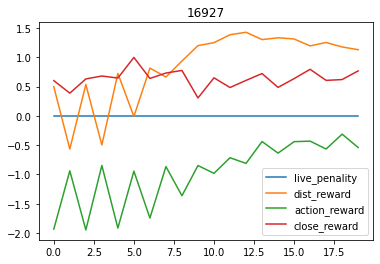

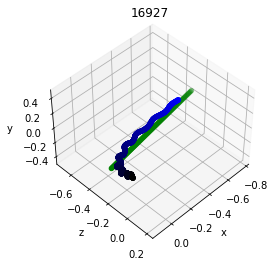

| eval  | E: 672 | S: 16927 | R: 10.6333
| train | E: 673 | S: 16927 | R: 7.4518 | D: 12.2 s | BR: 0.0576 | ALOSS: -6.4404 | CLOSS: 0.1352 | TLOSS: -0.5554 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 674 | S: 16946 | R: 15.3557 | D: 28.2 s | BR: 0.0916 | ALOSS: -6.4386 | CLOSS: 0.1329 | TLOSS: -0.0211 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 675 | S: 16967 | R: 3.4505 | D: 16.4 s | BR: 0.0421 | ALOSS: -6.4017 | CLOSS: 0.1971 | TLOSS: 0.4647 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 676 | S: 16985 | R: 15.1243 | D: 12.3 s | BR: 0.0637 | ALOSS: -6.4161 | CLOSS: 0.1698 | TLOSS: -0.1434 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 677 | S: 17002 | R: 13.8313 | D: 12.9 s | BR: 0.0554 | ALOSS: -6.6222 | CLOSS: 0.1274 | TLOSS: 0.5595 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 678 | S: 17018 | R: 13.3621 | D: 11.5 s | BR: 0.0184 | ALOSS: -6.4410 | CLOSS: 0.1314 | TLOSS: 0.4055 | TVAL: 0.0224 | AENT: -4.0000
| train | E: 679 | S: 17035 | R: 10.9952 | D: 12.9 s | BR: 0.0726 | ALOSS: -6.5199

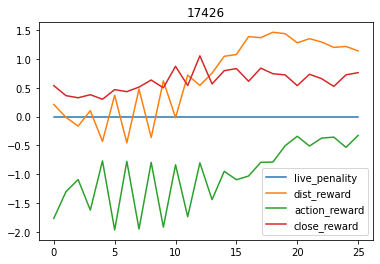

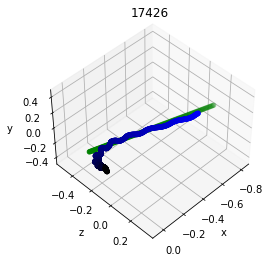

| eval  | E: 700 | S: 17426 | R: 7.2649
| train | E: 701 | S: 17426 | R: 14.7119 | D: 12.3 s | BR: 0.0848 | ALOSS: -6.5282 | CLOSS: 0.1189 | TLOSS: -0.0052 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 702 | S: 17441 | R: 13.9799 | D: 28.4 s | BR: 0.0107 | ALOSS: -6.4154 | CLOSS: 0.1475 | TLOSS: -0.1484 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 703 | S: 17465 | R: 9.1538 | D: 16.5 s | BR: 0.0582 | ALOSS: -6.5523 | CLOSS: 0.1601 | TLOSS: 0.0332 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 704 | S: 17486 | R: 9.2628 | D: 15.4 s | BR: 0.0692 | ALOSS: -6.7658 | CLOSS: 0.1402 | TLOSS: -0.0379 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 705 | S: 17502 | R: 14.9139 | D: 11.8 s | BR: 0.1163 | ALOSS: -6.8215 | CLOSS: 0.2066 | TLOSS: 0.6031 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 706 | S: 17521 | R: 12.6155 | D: 13.5 s | BR: 0.0528 | ALOSS: -6.7112 | CLOSS: 0.1435 | TLOSS: -0.1751 | TVAL: 0.0225 | AENT: -4.0000
| train | E: 707 | S: 17541 | R: 17.4028 | D: 13.0 s | BR: 0.0169 | ALOSS: -6.4352

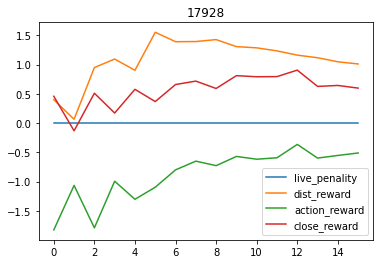

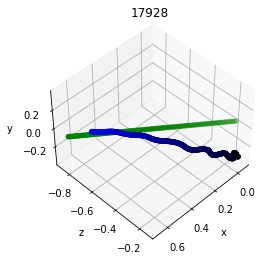

| eval  | E: 728 | S: 17928 | R: 12.3923
| train | E: 729 | S: 17928 | R: 15.6301 | D: 10.1 s | BR: 0.0597 | ALOSS: -6.9043 | CLOSS: 0.1798 | TLOSS: -0.4604 | TVAL: 0.0227 | AENT: -4.0000
| train | E: 730 | S: 17944 | R: 16.0307 | D: 23.0 s | BR: 0.0923 | ALOSS: -6.6677 | CLOSS: 0.1251 | TLOSS: 0.1377 | TVAL: 0.0227 | AENT: -4.0000
| train | E: 731 | S: 17961 | R: 13.0158 | D: 12.9 s | BR: 0.1418 | ALOSS: -6.9447 | CLOSS: 0.1129 | TLOSS: -0.4624 | TVAL: 0.0227 | AENT: -4.0000
| train | E: 732 | S: 17982 | R: 5.2016 | D: 14.2 s | BR: 0.0705 | ALOSS: -6.5242 | CLOSS: 0.1482 | TLOSS: -0.3235 | TVAL: 0.0226 | AENT: -4.0000
| train | E: 733 | S: 18004 | R: 12.4177 | D: 14.6 s | BR: 0.0816 | ALOSS: -6.5173 | CLOSS: 0.1316 | TLOSS: 1.1621 | TVAL: 0.0226 | AENT: -4.0000
| train | E: 734 | S: 18025 | R: 4.1293 | D: 14.0 s | BR: 0.0580 | ALOSS: -6.6008 | CLOSS: 0.1276 | TLOSS: 0.9666 | TVAL: 0.0227 | AENT: -4.0000
| train | E: 735 | S: 18045 | R: 11.4439 | D: 14.4 s | BR: 0.0933 | ALOSS: -6.7030

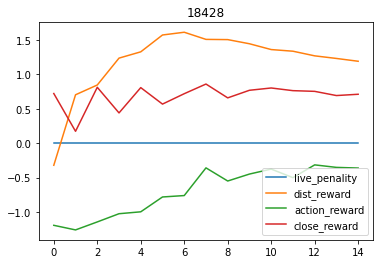

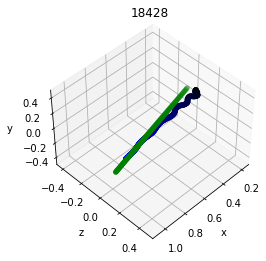

| eval  | E: 754 | S: 18428 | R: 17.6091
| train | E: 755 | S: 18428 | R: 7.7159 | D: 14.6 s | BR: 0.0902 | ALOSS: -6.8831 | CLOSS: 0.1233 | TLOSS: 0.4283 | TVAL: 0.0231 | AENT: -4.0000
| train | E: 756 | S: 18449 | R: 6.2674 | D: 25.5 s | BR: 0.0966 | ALOSS: -6.5450 | CLOSS: 0.1425 | TLOSS: 0.5248 | TVAL: 0.0231 | AENT: -4.0000
| train | E: 757 | S: 18466 | R: 12.8280 | D: 12.7 s | BR: 0.1037 | ALOSS: -6.7952 | CLOSS: 0.1100 | TLOSS: 0.1750 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 758 | S: 18482 | R: 11.0346 | D: 10.9 s | BR: 0.1190 | ALOSS: -6.9157 | CLOSS: 0.1270 | TLOSS: -0.1344 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 759 | S: 18501 | R: 13.8731 | D: 14.1 s | BR: 0.1456 | ALOSS: -6.8063 | CLOSS: 0.1257 | TLOSS: 0.5663 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 760 | S: 18525 | R: 6.0746 | D: 15.6 s | BR: 0.0805 | ALOSS: -6.6686 | CLOSS: 0.1228 | TLOSS: -0.0003 | TVAL: 0.0232 | AENT: -4.0000
| train | E: 761 | S: 18549 | R: 11.6704 | D: 16.8 s | BR: 0.0983 | ALOSS: -6.7551 |

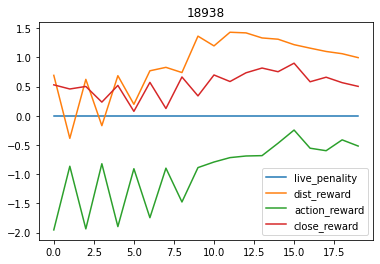

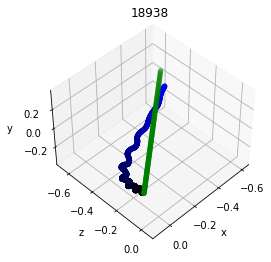

| eval  | E: 781 | S: 18938 | R: 9.3363
| train | E: 782 | S: 18938 | R: 15.8860 | D: 11.4 s | BR: 0.1080 | ALOSS: -6.8581 | CLOSS: 0.1141 | TLOSS: -0.2368 | TVAL: 0.0238 | AENT: -4.0000
| train | E: 783 | S: 18953 | R: 15.3536 | D: 25.3 s | BR: 0.0933 | ALOSS: -6.8854 | CLOSS: 0.1110 | TLOSS: 0.3088 | TVAL: 0.0238 | AENT: -4.0000
| train | E: 784 | S: 18971 | R: 14.1424 | D: 12.9 s | BR: 0.0720 | ALOSS: -6.6609 | CLOSS: 0.1658 | TLOSS: 0.3450 | TVAL: 0.0238 | AENT: -4.0000
| train | E: 785 | S: 19002 | R: 4.0791 | D: 19.2 s | BR: 0.1133 | ALOSS: -6.7220 | CLOSS: 0.1441 | TLOSS: 0.0768 | TVAL: 0.0238 | AENT: -4.0000
| train | E: 786 | S: 19021 | R: 10.9101 | D: 14.0 s | BR: 0.0269 | ALOSS: -6.8631 | CLOSS: 0.1677 | TLOSS: 0.0381 | TVAL: 0.0239 | AENT: -4.0000
| train | E: 787 | S: 19037 | R: 10.1507 | D: 11.1 s | BR: 0.0990 | ALOSS: -6.6732 | CLOSS: 0.1169 | TLOSS: -0.3139 | TVAL: 0.0238 | AENT: -4.0000
| train | E: 788 | S: 19056 | R: 14.3238 | D: 13.8 s | BR: 0.1598 | ALOSS: -6.6596 

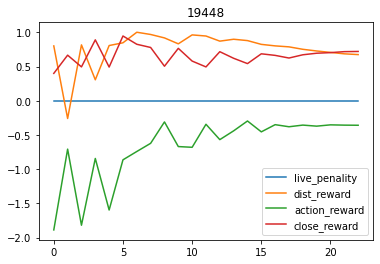

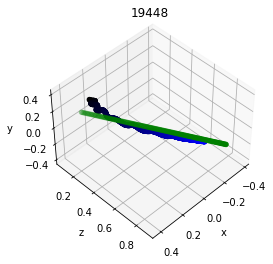

| eval  | E: 808 | S: 19448 | R: 17.4648
| train | E: 809 | S: 19448 | R: 11.4025 | D: 11.6 s | BR: 0.1996 | ALOSS: -6.9637 | CLOSS: 0.1340 | TLOSS: 0.1441 | TVAL: 0.0241 | AENT: -4.0000
| train | E: 810 | S: 19467 | R: 15.5204 | D: 27.7 s | BR: 0.1380 | ALOSS: -7.0470 | CLOSS: 0.1085 | TLOSS: 0.6977 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 811 | S: 19484 | R: 7.5633 | D: 11.8 s | BR: 0.1037 | ALOSS: -7.0175 | CLOSS: 0.1142 | TLOSS: -0.0090 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 812 | S: 19508 | R: 10.4156 | D: 15.3 s | BR: 0.1214 | ALOSS: -6.7969 | CLOSS: 0.1210 | TLOSS: -0.0410 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 813 | S: 19533 | R: 11.4300 | D: 16.3 s | BR: 0.1238 | ALOSS: -6.7367 | CLOSS: 0.1286 | TLOSS: 0.4142 | TVAL: 0.0242 | AENT: -4.0000
| train | E: 814 | S: 19557 | R: 8.7754 | D: 15.5 s | BR: 0.1392 | ALOSS: -6.9873 | CLOSS: 0.1169 | TLOSS: -0.1372 | TVAL: 0.0243 | AENT: -4.0000
| train | E: 815 | S: 19580 | R: 12.5143 | D: 15.6 s | BR: 0.1283 | ALOSS: -6.8560

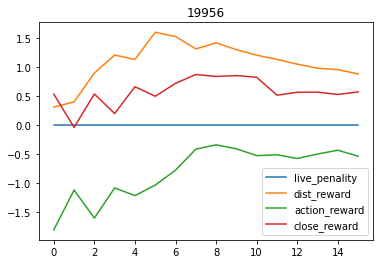

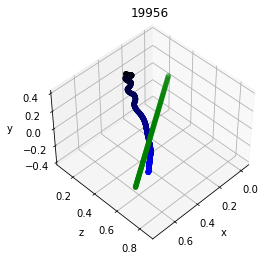

| eval  | E: 834 | S: 19956 | R: 13.7285
| train | E: 835 | S: 19956 | R: 7.4018 | D: 15.3 s | BR: 0.1475 | ALOSS: -6.6761 | CLOSS: 0.1161 | TLOSS: 0.3080 | TVAL: 0.0243 | AENT: -4.0000
| train | E: 836 | S: 19971 | R: 13.5381 | D: 22.9 s | BR: 0.1718 | ALOSS: -7.0525 | CLOSS: 0.1037 | TLOSS: 0.4222 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 837 | S: 19995 | R: 6.9127 | D: 15.6 s | BR: 0.2041 | ALOSS: -6.9557 | CLOSS: 0.1011 | TLOSS: -0.3518 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 838 | S: 20013 | R: 13.0561 | D: 12.0 s | BR: 0.1565 | ALOSS: -6.7210 | CLOSS: 0.1023 | TLOSS: 0.3525 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 839 | S: 20030 | R: 12.0726 | D: 11.5 s | BR: 0.1827 | ALOSS: -6.7831 | CLOSS: 0.1104 | TLOSS: 0.2688 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 840 | S: 20045 | R: 14.6637 | D: 10.5 s | BR: 0.1788 | ALOSS: -6.9779 | CLOSS: 0.1287 | TLOSS: 0.1978 | TVAL: 0.0244 | AENT: -4.0000
| train | E: 841 | S: 20063 | R: 12.3304 | D: 12.2 s | BR: 0.1148 | ALOSS: -6.8440 |

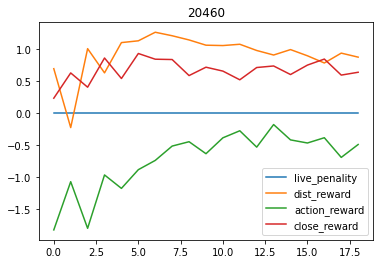

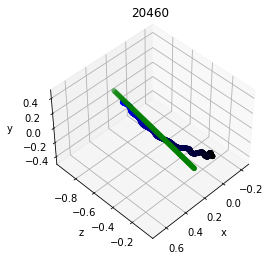

| eval  | E: 861 | S: 20460 | R: 16.2081
| train | E: 862 | S: 20460 | R: 6.1788 | D: 12.6 s | BR: 0.1496 | ALOSS: -6.9677 | CLOSS: 0.1055 | TLOSS: -0.1294 | TVAL: 0.0248 | AENT: -4.0000
| train | E: 863 | S: 20481 | R: 13.0918 | D: 28.2 s | BR: 0.1302 | ALOSS: -7.0733 | CLOSS: 0.1075 | TLOSS: -0.3559 | TVAL: 0.0248 | AENT: -4.0000
| train | E: 864 | S: 20504 | R: 9.4812 | D: 14.9 s | BR: 0.1629 | ALOSS: -6.8467 | CLOSS: 0.1214 | TLOSS: -0.2450 | TVAL: 0.0247 | AENT: -4.0000
| train | E: 865 | S: 20523 | R: 10.7468 | D: 14.2 s | BR: 0.0691 | ALOSS: -6.9254 | CLOSS: 0.1147 | TLOSS: 0.4757 | TVAL: 0.0247 | AENT: -4.0000
| train | E: 866 | S: 20541 | R: 13.9056 | D: 12.0 s | BR: 0.1005 | ALOSS: -6.9604 | CLOSS: 0.1411 | TLOSS: 0.8665 | TVAL: 0.0248 | AENT: -4.0000
| train | E: 867 | S: 20558 | R: 14.7558 | D: 13.0 s | BR: 0.1393 | ALOSS: -6.9089 | CLOSS: 0.1242 | TLOSS: 0.4223 | TVAL: 0.0248 | AENT: -4.0000
| train | E: 868 | S: 20581 | R: 10.8024 | D: 16.0 s | BR: 0.1586 | ALOSS: -6.7741

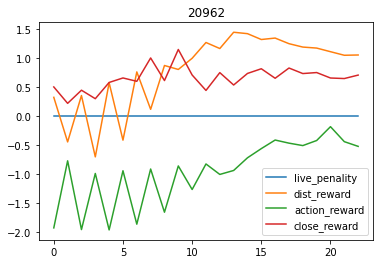

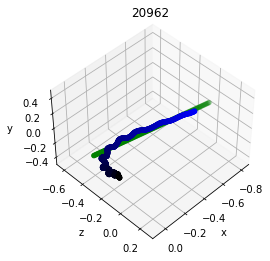

| eval  | E: 887 | S: 20962 | R: 10.6250
| train | E: 888 | S: 20962 | R: 14.0624 | D: 10.9 s | BR: 0.1468 | ALOSS: -6.9810 | CLOSS: 0.1126 | TLOSS: -0.0485 | TVAL: 0.0249 | AENT: -4.0000
| train | E: 889 | S: 20977 | R: 13.8565 | D: 25.7 s | BR: 0.1838 | ALOSS: -7.0662 | CLOSS: 0.1061 | TLOSS: -0.2846 | TVAL: 0.0249 | AENT: -4.0000
| train | E: 890 | S: 20994 | R: 15.6155 | D: 11.6 s | BR: 0.2029 | ALOSS: -7.0242 | CLOSS: 0.0982 | TLOSS: -0.2558 | TVAL: 0.0249 | AENT: -4.0000
| train | E: 891 | S: 21017 | R: 9.3708 | D: 14.9 s | BR: 0.0845 | ALOSS: -7.0711 | CLOSS: 0.1791 | TLOSS: 0.2123 | TVAL: 0.0249 | AENT: -4.0000
| train | E: 892 | S: 21034 | R: 13.7640 | D: 11.8 s | BR: 0.1642 | ALOSS: -7.1119 | CLOSS: 0.1088 | TLOSS: 0.1520 | TVAL: 0.0249 | AENT: -4.0000
| train | E: 893 | S: 21054 | R: 10.2755 | D: 13.5 s | BR: 0.1826 | ALOSS: -6.8874 | CLOSS: 0.1110 | TLOSS: -0.1713 | TVAL: 0.0249 | AENT: -4.0000
| train | E: 894 | S: 21079 | R: 8.5359 | D: 16.9 s | BR: 0.1623 | ALOSS: -6.775

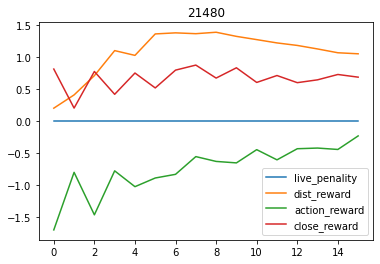

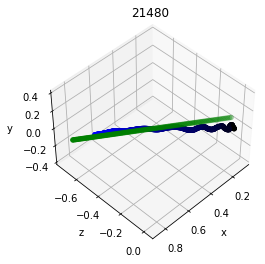

| eval  | E: 914 | S: 21480 | R: 16.1480
| train | E: 915 | S: 21480 | R: 15.6403 | D: 16.9 s | BR: 0.1653 | ALOSS: -6.9883 | CLOSS: 0.1210 | TLOSS: -0.1265 | TVAL: 0.0252 | AENT: -4.0000
| train | E: 916 | S: 21499 | R: 14.3519 | D: 25.2 s | BR: 0.1555 | ALOSS: -6.9555 | CLOSS: 0.1061 | TLOSS: 0.2931 | TVAL: 0.0252 | AENT: -4.0000
| train | E: 917 | S: 21519 | R: 15.2842 | D: 13.7 s | BR: 0.1493 | ALOSS: -6.9042 | CLOSS: 0.0849 | TLOSS: -0.0385 | TVAL: 0.0252 | AENT: -4.0000
| train | E: 918 | S: 21539 | R: 10.9203 | D: 13.3 s | BR: 0.1247 | ALOSS: -7.3083 | CLOSS: 0.0946 | TLOSS: 0.6042 | TVAL: 0.0252 | AENT: -4.0000
| train | E: 919 | S: 21558 | R: 15.2595 | D: 13.2 s | BR: 0.1364 | ALOSS: -7.0631 | CLOSS: 0.1754 | TLOSS: 0.6247 | TVAL: 0.0253 | AENT: -4.0000
| train | E: 920 | S: 21582 | R: 11.1108 | D: 16.0 s | BR: 0.1478 | ALOSS: -7.0628 | CLOSS: 0.1227 | TLOSS: 0.4988 | TVAL: 0.0254 | AENT: -4.0000
| train | E: 921 | S: 21602 | R: 9.3534 | D: 13.2 s | BR: 0.1783 | ALOSS: -7.0211

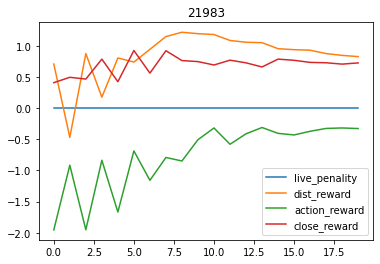

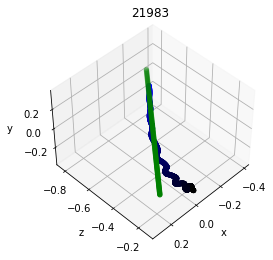

| eval  | E: 940 | S: 21983 | R: 15.9481
| train | E: 941 | S: 21983 | R: 13.9963 | D: 11.2 s | BR: 0.2029 | ALOSS: -7.0787 | CLOSS: 0.1107 | TLOSS: 0.0283 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 942 | S: 22002 | R: 15.4068 | D: 26.1 s | BR: 0.1612 | ALOSS: -6.9454 | CLOSS: 0.1239 | TLOSS: 0.1721 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 943 | S: 22023 | R: 17.1131 | D: 13.6 s | BR: 0.1528 | ALOSS: -7.0288 | CLOSS: 0.1039 | TLOSS: -1.0070 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 944 | S: 22043 | R: 8.0180 | D: 13.8 s | BR: 0.1834 | ALOSS: -7.0897 | CLOSS: 0.1193 | TLOSS: -0.0389 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 945 | S: 22061 | R: 7.6002 | D: 13.2 s | BR: 0.1518 | ALOSS: -7.0814 | CLOSS: 0.1115 | TLOSS: 0.2041 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 946 | S: 22078 | R: 12.7989 | D: 12.1 s | BR: 0.1675 | ALOSS: -7.1220 | CLOSS: 0.1010 | TLOSS: -0.2015 | TVAL: 0.0257 | AENT: -4.0000
| train | E: 947 | S: 22095 | R: 14.6939 | D: 13.0 s | BR: 0.1945 | ALOSS: -7.0204

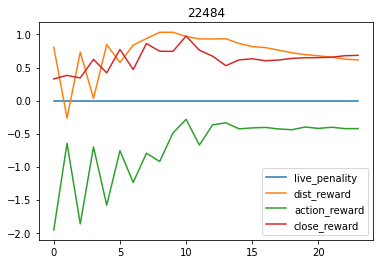

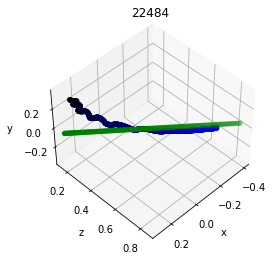

| eval  | E: 966 | S: 22484 | R: 15.8086
| train | E: 967 | S: 22484 | R: 10.0510 | D: 15.8 s | BR: 0.1819 | ALOSS: -7.2607 | CLOSS: 0.1631 | TLOSS: -0.4624 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 968 | S: 22503 | R: 11.5254 | D: 31.2 s | BR: 0.1334 | ALOSS: -7.3112 | CLOSS: 0.1282 | TLOSS: 0.9061 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 969 | S: 22526 | R: 12.8566 | D: 15.6 s | BR: 0.1333 | ALOSS: -7.1656 | CLOSS: 0.0990 | TLOSS: 0.1357 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 970 | S: 22545 | R: 9.3174 | D: 15.1 s | BR: 0.1826 | ALOSS: -7.1904 | CLOSS: 0.1035 | TLOSS: -0.3541 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 971 | S: 22565 | R: 12.2079 | D: 17.2 s | BR: 0.1990 | ALOSS: -7.1323 | CLOSS: 0.0902 | TLOSS: -0.3101 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 972 | S: 22583 | R: 14.3842 | D: 14.1 s | BR: 0.1993 | ALOSS: -7.2890 | CLOSS: 0.1237 | TLOSS: 0.6316 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 973 | S: 22602 | R: 7.0295 | D: 13.1 s | BR: 0.2039 | ALOSS: -7.1544

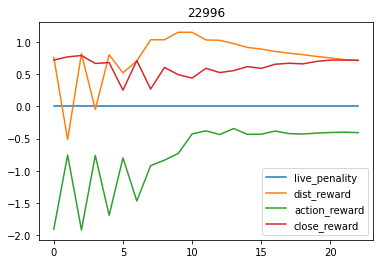

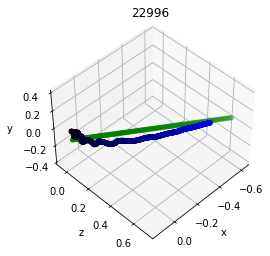

| eval  | E: 993 | S: 22996 | R: 14.6974
| train | E: 994 | S: 22996 | R: 15.0957 | D: 13.6 s | BR: 0.2124 | ALOSS: -7.1452 | CLOSS: 0.0910 | TLOSS: -0.1306 | TVAL: 0.0260 | AENT: -4.0000
| train | E: 995 | S: 23014 | R: 12.7962 | D: 27.7 s | BR: 0.2060 | ALOSS: -7.0963 | CLOSS: 0.1541 | TLOSS: -0.1330 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 996 | S: 23034 | R: 12.4824 | D: 13.5 s | BR: 0.1816 | ALOSS: -7.1688 | CLOSS: 0.0879 | TLOSS: -0.4510 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 997 | S: 23051 | R: 11.9753 | D: 12.3 s | BR: 0.1882 | ALOSS: -7.2300 | CLOSS: 0.1290 | TLOSS: 0.2197 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 998 | S: 23067 | R: 12.8305 | D: 12.2 s | BR: 0.1607 | ALOSS: -7.3426 | CLOSS: 0.1039 | TLOSS: 0.2415 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 999 | S: 23085 | R: 14.3628 | D: 14.1 s | BR: 0.1632 | ALOSS: -7.2328 | CLOSS: 0.0971 | TLOSS: 0.4615 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 1000 | S: 23104 | R: 12.4458 | D: 13.6 s | BR: 0.2063 | ALOSS: -7.2

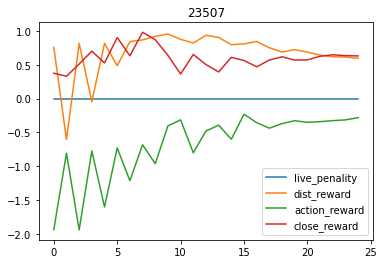

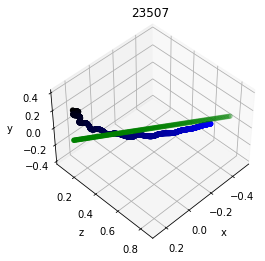

| eval  | E: 1019 | S: 23507 | R: 14.9986
| train | E: 1020 | S: 23507 | R: 13.8571 | D: 12.4 s | BR: 0.2479 | ALOSS: -7.2150 | CLOSS: 0.0919 | TLOSS: -0.0357 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 1021 | S: 23528 | R: 16.6183 | D: 31.5 s | BR: 0.2011 | ALOSS: -7.3368 | CLOSS: 0.1042 | TLOSS: 0.0519 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 1022 | S: 23544 | R: 13.8882 | D: 14.2 s | BR: 0.1874 | ALOSS: -7.1303 | CLOSS: 0.1086 | TLOSS: 0.5135 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 1023 | S: 23567 | R: 13.7369 | D: 15.7 s | BR: 0.2060 | ALOSS: -7.0073 | CLOSS: 0.0886 | TLOSS: 0.1094 | TVAL: 0.0258 | AENT: -4.0000
| train | E: 1024 | S: 23589 | R: 14.4804 | D: 14.7 s | BR: 0.1999 | ALOSS: -7.1232 | CLOSS: 0.0938 | TLOSS: 0.0389 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 1025 | S: 23607 | R: 15.7471 | D: 12.4 s | BR: 0.2644 | ALOSS: -7.1670 | CLOSS: 0.0925 | TLOSS: -0.1998 | TVAL: 0.0259 | AENT: -4.0000
| train | E: 1026 | S: 23636 | R: 7.0065 | D: 18.7 s | BR: 0.1733 | ALOSS:

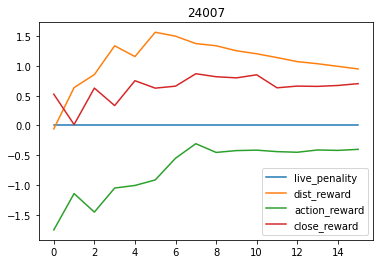

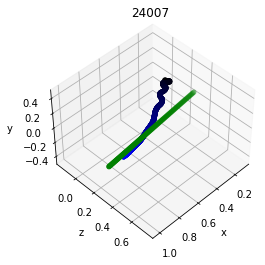

| eval  | E: 1044 | S: 24007 | R: 15.9962
| train | E: 1045 | S: 24007 | R: 16.4441 | D: 12.8 s | BR: 0.2559 | ALOSS: -7.0032 | CLOSS: 0.0889 | TLOSS: 0.5450 | TVAL: 0.0262 | AENT: -4.0000
| train | E: 1046 | S: 24030 | R: 11.3774 | D: 27.3 s | BR: 0.1857 | ALOSS: -7.0755 | CLOSS: 0.1013 | TLOSS: 0.6946 | TVAL: 0.0263 | AENT: -4.0000
| train | E: 1047 | S: 24049 | R: 13.2470 | D: 13.1 s | BR: 0.1595 | ALOSS: -7.1989 | CLOSS: 0.1693 | TLOSS: 0.1664 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1048 | S: 24066 | R: 13.5218 | D: 11.6 s | BR: 0.2256 | ALOSS: -7.3333 | CLOSS: 0.0936 | TLOSS: 0.6463 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1049 | S: 24085 | R: 13.6423 | D: 13.4 s | BR: 0.2862 | ALOSS: -7.1466 | CLOSS: 0.0871 | TLOSS: 0.4289 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 1050 | S: 24101 | R: 14.2871 | D: 12.2 s | BR: 0.2383 | ALOSS: -7.1081 | CLOSS: 0.0909 | TLOSS: 0.4852 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 1051 | S: 24116 | R: 15.7239 | D: 10.9 s | BR: 0.1871 | ALOSS: 

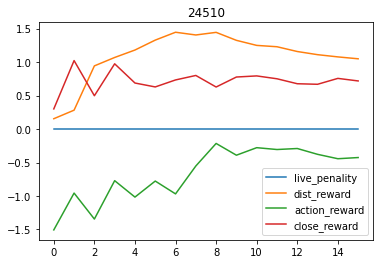

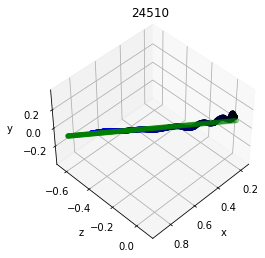

| eval  | E: 1070 | S: 24510 | R: 18.2462
| train | E: 1071 | S: 24510 | R: 15.3852 | D: 15.2 s | BR: 0.2337 | ALOSS: -7.2617 | CLOSS: 0.1086 | TLOSS: 0.3169 | TVAL: 0.0266 | AENT: -4.0000
| train | E: 1072 | S: 24528 | R: 17.2877 | D: 27.2 s | BR: 0.2555 | ALOSS: -7.0644 | CLOSS: 0.0857 | TLOSS: 0.0279 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 1073 | S: 24550 | R: 17.2890 | D: 17.2 s | BR: 0.2696 | ALOSS: -7.2394 | CLOSS: 0.0901 | TLOSS: 0.2303 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 1074 | S: 24569 | R: 7.4199 | D: 15.2 s | BR: 0.2322 | ALOSS: -7.2951 | CLOSS: 0.0924 | TLOSS: -0.2042 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 1075 | S: 24588 | R: 4.8450 | D: 15.1 s | BR: 0.2017 | ALOSS: -7.2677 | CLOSS: 0.1253 | TLOSS: -0.0262 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 1076 | S: 24606 | R: 14.7289 | D: 14.3 s | BR: 0.2052 | ALOSS: -7.4717 | CLOSS: 0.0857 | TLOSS: 0.1703 | TVAL: 0.0267 | AENT: -4.0000
| train | E: 1077 | S: 24624 | R: 15.7053 | D: 14.8 s | BR: 0.2405 | ALOSS: 

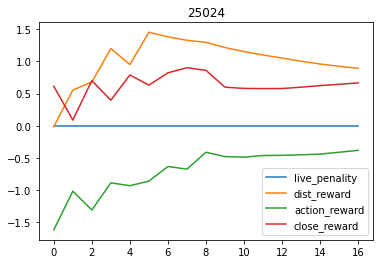

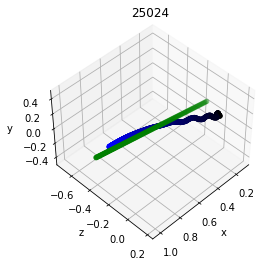

| eval  | E: 1096 | S: 25024 | R: 15.8425
| train | E: 1097 | S: 25024 | R: 8.8447 | D: 17.2 s | BR: 0.2369 | ALOSS: -7.3150 | CLOSS: 0.0789 | TLOSS: -0.9337 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1098 | S: 25045 | R: 16.3325 | D: 28.2 s | BR: 0.2351 | ALOSS: -7.2726 | CLOSS: 0.0898 | TLOSS: 0.7994 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1099 | S: 25062 | R: 15.5789 | D: 12.0 s | BR: 0.2323 | ALOSS: -7.4290 | CLOSS: 0.0892 | TLOSS: -0.0823 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1100 | S: 25085 | R: 10.9277 | D: 16.9 s | BR: 0.2747 | ALOSS: -7.1252 | CLOSS: 0.0744 | TLOSS: -0.0653 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1101 | S: 25107 | R: 5.3772 | D: 15.7 s | BR: 0.2611 | ALOSS: -7.3351 | CLOSS: 0.0857 | TLOSS: 0.5281 | TVAL: 0.0264 | AENT: -4.0000
| train | E: 1102 | S: 25126 | R: 9.9905 | D: 13.6 s | BR: 0.2170 | ALOSS: -7.4227 | CLOSS: 0.0894 | TLOSS: -0.0585 | TVAL: 0.0265 | AENT: -4.0000
| train | E: 1103 | S: 25146 | R: 12.5458 | D: 13.3 s | BR: 0.2485 | ALOSS:

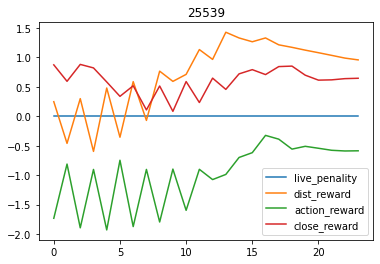

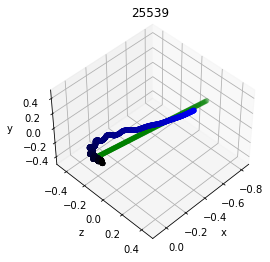

| eval  | E: 1123 | S: 25539 | R: 8.1296
| train | E: 1124 | S: 25539 | R: 5.8021 | D: 14.2 s | BR: 0.2770 | ALOSS: -6.9457 | CLOSS: 0.0987 | TLOSS: -0.0682 | TVAL: 0.0268 | AENT: -4.0000
| train | E: 1125 | S: 25563 | R: 12.4955 | D: 34.6 s | BR: 0.1992 | ALOSS: -7.1745 | CLOSS: 0.0740 | TLOSS: 0.1663 | TVAL: 0.0268 | AENT: -4.0000
| train | E: 1126 | S: 25584 | R: 1.5869 | D: 14.6 s | BR: 0.2547 | ALOSS: -7.3723 | CLOSS: 0.0852 | TLOSS: -0.3149 | TVAL: 0.0268 | AENT: -4.0000
| train | E: 1127 | S: 25604 | R: 6.7343 | D: 15.5 s | BR: 0.2230 | ALOSS: -7.2601 | CLOSS: 0.0781 | TLOSS: 0.3558 | TVAL: 0.0268 | AENT: -4.0000
| train | E: 1128 | S: 25626 | R: 5.3314 | D: 14.8 s | BR: 0.2358 | ALOSS: -6.9833 | CLOSS: 0.1612 | TLOSS: 0.4941 | TVAL: 0.0268 | AENT: -4.0000
| train | E: 1129 | S: 25645 | R: 15.3819 | D: 14.1 s | BR: 0.2792 | ALOSS: -7.2598 | CLOSS: 0.0834 | TLOSS: 0.0686 | TVAL: 0.0269 | AENT: -4.0000
| train | E: 1130 | S: 25662 | R: 14.0940 | D: 11.9 s | BR: 0.2738 | ALOSS: -7.

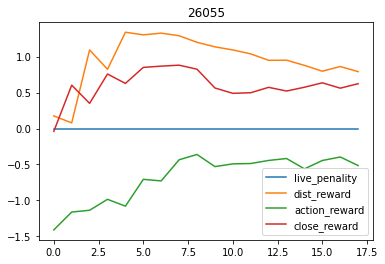

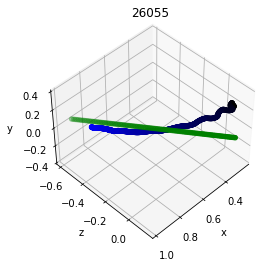

| eval  | E: 1149 | S: 26055 | R: 15.5794
| train | E: 1150 | S: 26055 | R: 1.0819 | D: 18.7 s | BR: 0.2517 | ALOSS: -7.2486 | CLOSS: 0.0810 | TLOSS: 0.3848 | TVAL: 0.0272 | AENT: -4.0000
| train | E: 1151 | S: 26073 | R: 14.4151 | D: 26.8 s | BR: 0.2505 | ALOSS: -7.3168 | CLOSS: 0.0931 | TLOSS: 0.3935 | TVAL: 0.0273 | AENT: -4.0000
| train | E: 1152 | S: 26094 | R: 17.8308 | D: 13.7 s | BR: 0.2807 | ALOSS: -7.2800 | CLOSS: 0.0759 | TLOSS: -0.0030 | TVAL: 0.0273 | AENT: -4.0000
| train | E: 1153 | S: 26112 | R: 16.4269 | D: 12.4 s | BR: 0.2950 | ALOSS: -7.1756 | CLOSS: 0.0966 | TLOSS: -0.1331 | TVAL: 0.0273 | AENT: -4.0000
| train | E: 1154 | S: 26130 | R: 15.7645 | D: 14.3 s | BR: 0.2071 | ALOSS: -7.3009 | CLOSS: 0.1006 | TLOSS: 1.0799 | TVAL: 0.0273 | AENT: -4.0000
| train | E: 1155 | S: 26147 | R: 16.1912 | D: 11.8 s | BR: 0.2397 | ALOSS: -7.4529 | CLOSS: 0.0849 | TLOSS: -0.1506 | TVAL: 0.0274 | AENT: -4.0000
| train | E: 1156 | S: 26173 | R: 12.1519 | D: 18.4 s | BR: 0.2297 | ALOSS

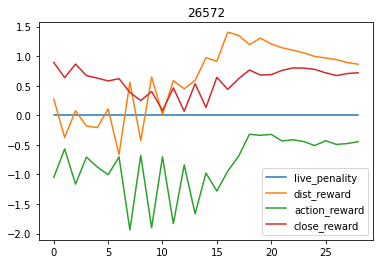

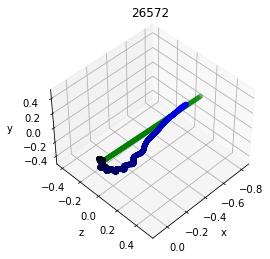

| eval  | E: 1175 | S: 26572 | R: 10.5322
| train | E: 1176 | S: 26572 | R: 17.4078 | D: 15.2 s | BR: 0.2418 | ALOSS: -7.4066 | CLOSS: 0.0870 | TLOSS: 0.0963 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1177 | S: 26590 | R: 6.3302 | D: 34.4 s | BR: 0.3027 | ALOSS: -7.4683 | CLOSS: 0.0839 | TLOSS: -0.6124 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1178 | S: 26617 | R: 6.6278 | D: 18.0 s | BR: 0.2769 | ALOSS: -7.1519 | CLOSS: 0.0818 | TLOSS: -0.2873 | TVAL: 0.0274 | AENT: -4.0000
| train | E: 1179 | S: 26636 | R: 17.5367 | D: 13.3 s | BR: 0.2776 | ALOSS: -7.1725 | CLOSS: 0.0835 | TLOSS: 0.1122 | TVAL: 0.0274 | AENT: -4.0000
| train | E: 1180 | S: 26657 | R: 15.2060 | D: 16.1 s | BR: 0.2454 | ALOSS: -7.2137 | CLOSS: 0.0883 | TLOSS: 0.1377 | TVAL: 0.0274 | AENT: -4.0000
| train | E: 1181 | S: 26677 | R: 15.1420 | D: 15.0 s | BR: 0.2977 | ALOSS: -7.4466 | CLOSS: 0.0756 | TLOSS: -0.1673 | TVAL: 0.0274 | AENT: -4.0000
| train | E: 1182 | S: 26700 | R: 13.1464 | D: 17.0 s | BR: 0.2381 | ALOSS:

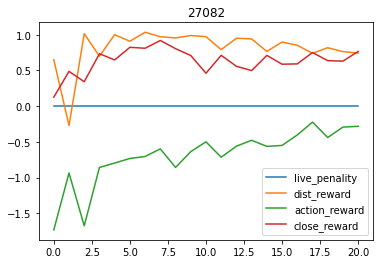

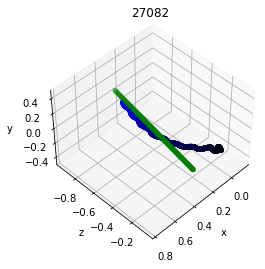

| eval  | E: 1200 | S: 27082 | R: 15.9644
| train | E: 1201 | S: 27082 | R: 9.6703 | D: 17.9 s | BR: 0.2208 | ALOSS: -7.3808 | CLOSS: 0.0845 | TLOSS: 0.7394 | TVAL: 0.0275 | AENT: -4.0000
| train | E: 1202 | S: 27103 | R: 14.6231 | D: 32.7 s | BR: 0.2613 | ALOSS: -7.3854 | CLOSS: 0.0816 | TLOSS: -0.1946 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1203 | S: 27130 | R: 13.5452 | D: 18.8 s | BR: 0.2655 | ALOSS: -7.2935 | CLOSS: 0.0899 | TLOSS: 0.1701 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1204 | S: 27149 | R: 16.1295 | D: 14.0 s | BR: 0.3191 | ALOSS: -7.5654 | CLOSS: 0.1464 | TLOSS: -0.1434 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1205 | S: 27171 | R: 5.4947 | D: 15.4 s | BR: 0.2534 | ALOSS: -7.1990 | CLOSS: 0.1391 | TLOSS: -0.1153 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1206 | S: 27193 | R: 2.5150 | D: 15.9 s | BR: 0.2315 | ALOSS: -7.3553 | CLOSS: 0.0872 | TLOSS: 0.0661 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1207 | S: 27214 | R: 16.5243 | D: 15.6 s | BR: 0.2781 | ALOSS: 

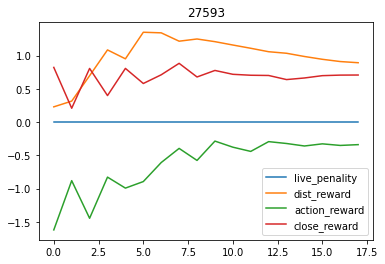

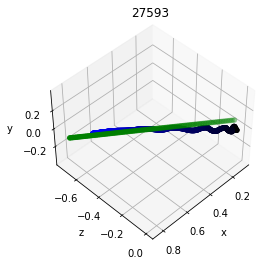

| eval  | E: 1223 | S: 27593 | R: 18.5973
| train | E: 1224 | S: 27593 | R: 15.2232 | D: 19.8 s | BR: 0.3015 | ALOSS: -7.3173 | CLOSS: 0.0836 | TLOSS: 0.3618 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1225 | S: 27612 | R: 7.7233 | D: 34.7 s | BR: 0.2446 | ALOSS: -7.5054 | CLOSS: 0.0747 | TLOSS: -0.2228 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 1226 | S: 27632 | R: 15.9094 | D: 18.5 s | BR: 0.2851 | ALOSS: -7.1827 | CLOSS: 0.0893 | TLOSS: -0.1252 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 1227 | S: 27651 | R: 15.0399 | D: 14.3 s | BR: 0.2936 | ALOSS: -7.4685 | CLOSS: 0.0770 | TLOSS: 0.0904 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 1228 | S: 27668 | R: 15.7388 | D: 15.1 s | BR: 0.1936 | ALOSS: -7.4651 | CLOSS: 0.0763 | TLOSS: 0.4020 | TVAL: 0.0276 | AENT: -4.0000
| train | E: 1229 | S: 27690 | R: 7.9397 | D: 17.8 s | BR: 0.2653 | ALOSS: -7.4433 | CLOSS: 0.0684 | TLOSS: -0.2052 | TVAL: 0.0277 | AENT: -4.0000
| train | E: 1230 | S: 27708 | R: 15.4569 | D: 13.8 s | BR: 0.2204 | ALOSS:

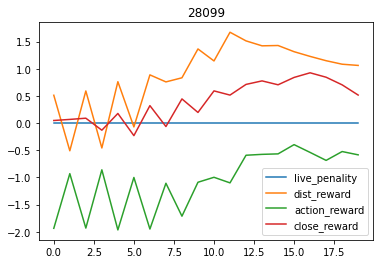

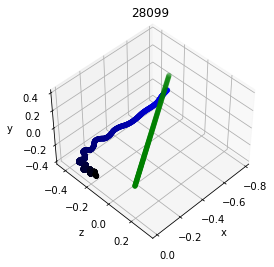

| eval  | E: 1248 | S: 28099 | R: 4.6166
| train | E: 1249 | S: 28099 | R: 16.2077 | D: 19.2 s | BR: 0.2161 | ALOSS: -7.3803 | CLOSS: 0.0791 | TLOSS: 0.1237 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1250 | S: 28118 | R: 15.1610 | D: 36.1 s | BR: 0.3000 | ALOSS: -7.1309 | CLOSS: 0.0890 | TLOSS: -0.0736 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1251 | S: 28136 | R: 16.6484 | D: 15.4 s | BR: 0.2438 | ALOSS: -7.6218 | CLOSS: 0.0777 | TLOSS: -0.2609 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1252 | S: 28155 | R: 15.7332 | D: 17.6 s | BR: 0.3059 | ALOSS: -7.3000 | CLOSS: 0.0733 | TLOSS: -0.0186 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1253 | S: 28174 | R: 15.7720 | D: 20.5 s | BR: 0.2973 | ALOSS: -7.1771 | CLOSS: 0.0796 | TLOSS: 0.2516 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1254 | S: 28202 | R: 9.7919 | D: 28.3 s | BR: 0.2554 | ALOSS: -7.5079 | CLOSS: 0.0854 | TLOSS: 0.1865 | TVAL: 0.0280 | AENT: -4.0000
| train | E: 1255 | S: 28221 | R: 9.3586 | D: 17.9 s | BR: 0.2178 | ALOSS: 

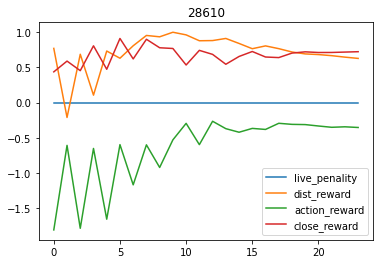

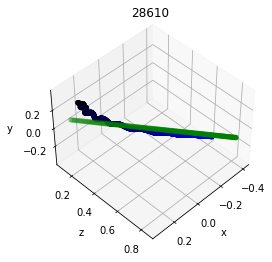

| eval  | E: 1274 | S: 28610 | R: 18.0260
| train | E: 1275 | S: 28610 | R: 3.4013 | D: 16.5 s | BR: 0.3165 | ALOSS: -7.3473 | CLOSS: 0.0837 | TLOSS: 0.3198 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1276 | S: 28628 | R: 12.8863 | D: 36.5 s | BR: 0.2870 | ALOSS: -7.5517 | CLOSS: 0.0753 | TLOSS: -0.4576 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1277 | S: 28648 | R: 16.0978 | D: 17.1 s | BR: 0.2963 | ALOSS: -7.2203 | CLOSS: 0.0694 | TLOSS: 0.0283 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1278 | S: 28669 | R: 17.6324 | D: 19.0 s | BR: 0.2832 | ALOSS: -7.4136 | CLOSS: 0.0755 | TLOSS: 0.2065 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1279 | S: 28687 | R: 18.0488 | D: 17.5 s | BR: 0.2588 | ALOSS: -7.1993 | CLOSS: 0.0900 | TLOSS: -0.2025 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1280 | S: 28706 | R: 17.1127 | D: 19.2 s | BR: 0.2261 | ALOSS: -7.4679 | CLOSS: 0.0731 | TLOSS: 0.4031 | TVAL: 0.0285 | AENT: -4.0000
| train | E: 1281 | S: 28723 | R: 14.3490 | D: 16.0 s | BR: 0.3076 | ALOSS:

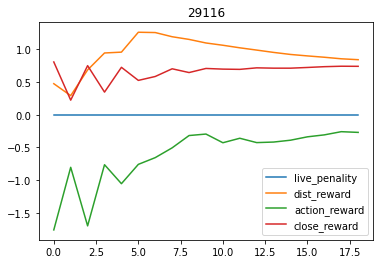

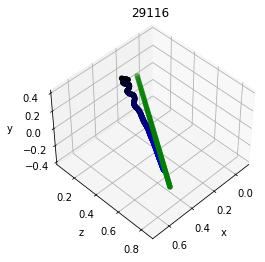

| eval  | E: 1300 | S: 29116 | R: 18.3537
| train | E: 1301 | S: 29116 | R: 14.7753 | D: 15.8 s | BR: 0.2912 | ALOSS: -7.4597 | CLOSS: 0.0700 | TLOSS: -0.0243 | TVAL: 0.0287 | AENT: -4.0000
| train | E: 1302 | S: 29138 | R: 12.7654 | D: 38.1 s | BR: 0.2745 | ALOSS: -7.5439 | CLOSS: 0.0751 | TLOSS: -0.2527 | TVAL: 0.0287 | AENT: -4.0000
| train | E: 1303 | S: 29155 | R: 10.0033 | D: 16.3 s | BR: 0.3262 | ALOSS: -7.6471 | CLOSS: 0.0803 | TLOSS: -0.3023 | TVAL: 0.0286 | AENT: -4.0000
| train | E: 1304 | S: 29173 | R: 16.7438 | D: 17.6 s | BR: 0.2949 | ALOSS: -7.5686 | CLOSS: 0.0795 | TLOSS: 0.1281 | TVAL: 0.0286 | AENT: -4.0000
| train | E: 1305 | S: 29195 | R: 10.5752 | D: 20.0 s | BR: 0.3232 | ALOSS: -7.4534 | CLOSS: 0.0749 | TLOSS: 0.4727 | TVAL: 0.0286 | AENT: -4.0000
| train | E: 1306 | S: 29213 | R: 12.9279 | D: 16.0 s | BR: 0.2474 | ALOSS: -7.5451 | CLOSS: 0.0765 | TLOSS: -0.0213 | TVAL: 0.0287 | AENT: -4.0000
| train | E: 1307 | S: 29231 | R: 9.8044 | D: 15.2 s | BR: 0.3031 | ALOS

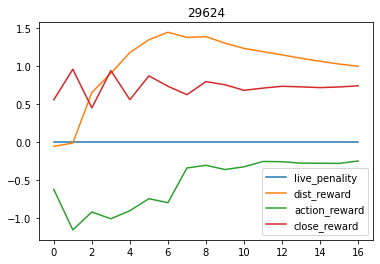

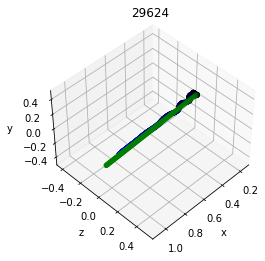

| eval  | E: 1326 | S: 29624 | R: 20.6454
| train | E: 1327 | S: 29624 | R: 12.3882 | D: 16.4 s | BR: 0.3296 | ALOSS: -7.3073 | CLOSS: 0.0654 | TLOSS: 0.1294 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1328 | S: 29645 | R: 6.9280 | D: 33.3 s | BR: 0.3013 | ALOSS: -7.3578 | CLOSS: 0.0650 | TLOSS: 0.1804 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1329 | S: 29660 | R: 16.4836 | D: 13.1 s | BR: 0.3139 | ALOSS: -7.5530 | CLOSS: 0.0620 | TLOSS: 0.1612 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1330 | S: 29678 | R: 12.8714 | D: 15.0 s | BR: 0.2482 | ALOSS: -7.4457 | CLOSS: 0.0661 | TLOSS: -0.0442 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1331 | S: 29695 | R: 15.3745 | D: 13.5 s | BR: 0.3491 | ALOSS: -7.3228 | CLOSS: 0.0795 | TLOSS: 0.6250 | TVAL: 0.0288 | AENT: -4.0000
| train | E: 1332 | S: 29714 | R: 12.2665 | D: 14.3 s | BR: 0.2624 | ALOSS: -7.7402 | CLOSS: 0.0916 | TLOSS: 0.4725 | TVAL: 0.0289 | AENT: -4.0000
| train | E: 1333 | S: 29733 | R: 11.9680 | D: 13.9 s | BR: 0.2901 | ALOSS: 

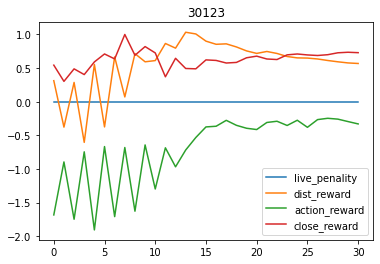

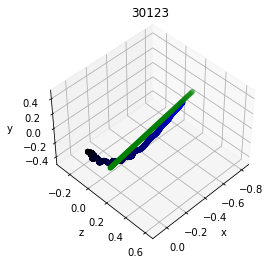

| eval  | E: 1352 | S: 30123 | R: 15.3568
| train | E: 1353 | S: 30123 | R: 15.7674 | D: 12.3 s | BR: 0.2856 | ALOSS: -7.5610 | CLOSS: 0.0861 | TLOSS: 0.4683 | TVAL: 0.0295 | AENT: -4.0000
| train | E: 1354 | S: 30138 | R: 16.7710 | D: 39.2 s | BR: 0.3054 | ALOSS: -7.3693 | CLOSS: 0.0703 | TLOSS: 0.2491 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 1355 | S: 30155 | R: 10.3340 | D: 15.6 s | BR: 0.2895 | ALOSS: -7.4662 | CLOSS: 0.0719 | TLOSS: -0.1808 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 1356 | S: 30177 | R: 11.3314 | D: 19.3 s | BR: 0.3519 | ALOSS: -7.4897 | CLOSS: 0.0614 | TLOSS: -0.1223 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 1357 | S: 30197 | R: 13.1013 | D: 16.7 s | BR: 0.2912 | ALOSS: -7.4005 | CLOSS: 0.0652 | TLOSS: 0.0975 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 1358 | S: 30216 | R: 13.8371 | D: 17.4 s | BR: 0.2237 | ALOSS: -7.2129 | CLOSS: 0.0853 | TLOSS: -0.1221 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 1359 | S: 30237 | R: 17.7234 | D: 17.7 s | BR: 0.3101 | ALOS

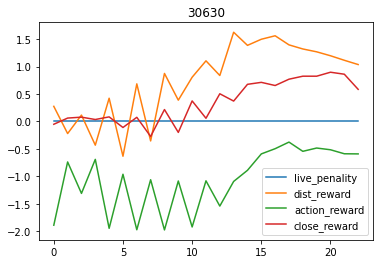

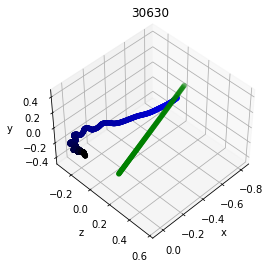

| eval  | E: 1377 | S: 30630 | R: 0.9510
| train | E: 1378 | S: 30630 | R: 11.4941 | D: 22.6 s | BR: 0.2946 | ALOSS: -7.5348 | CLOSS: 0.0616 | TLOSS: 0.2945 | TVAL: 0.0298 | AENT: -4.0000
| train | E: 1379 | S: 30652 | R: 16.2428 | D: 37.7 s | BR: 0.3357 | ALOSS: -7.6437 | CLOSS: 0.0819 | TLOSS: -0.5560 | TVAL: 0.0298 | AENT: -4.0000
| train | E: 1380 | S: 30670 | R: 15.4856 | D: 14.7 s | BR: 0.3540 | ALOSS: -7.4604 | CLOSS: 0.0808 | TLOSS: 0.5159 | TVAL: 0.0298 | AENT: -4.0000
| train | E: 1381 | S: 30698 | R: 12.9848 | D: 23.2 s | BR: 0.3593 | ALOSS: -7.4312 | CLOSS: 0.0738 | TLOSS: -0.5440 | TVAL: 0.0298 | AENT: -4.0000
| train | E: 1382 | S: 30715 | R: 15.7623 | D: 14.7 s | BR: 0.3446 | ALOSS: -7.6316 | CLOSS: 0.0651 | TLOSS: 0.3765 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1383 | S: 30734 | R: 15.2804 | D: 14.2 s | BR: 0.2808 | ALOSS: -7.5306 | CLOSS: 0.0803 | TLOSS: -0.1554 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1384 | S: 30750 | R: 16.3764 | D: 12.9 s | BR: 0.3024 | ALOSS

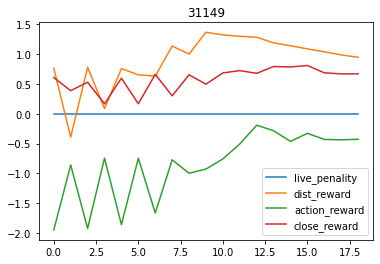

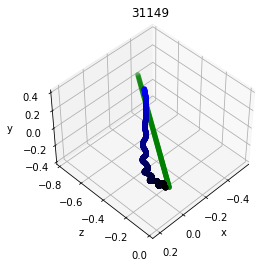

| eval  | E: 1403 | S: 31149 | R: 11.8934
| train | E: 1404 | S: 31149 | R: 3.8667 | D: 27.3 s | BR: 0.3015 | ALOSS: -7.5395 | CLOSS: 0.0708 | TLOSS: 0.0508 | TVAL: 0.0294 | AENT: -4.0000
| train | E: 1405 | S: 31170 | R: 1.8699 | D: 36.8 s | BR: 0.2925 | ALOSS: -7.4804 | CLOSS: 0.0678 | TLOSS: 0.1712 | TVAL: 0.0294 | AENT: -4.0000
| train | E: 1406 | S: 31190 | R: 15.2107 | D: 17.8 s | BR: 0.3302 | ALOSS: -7.4685 | CLOSS: 0.0694 | TLOSS: 0.4048 | TVAL: 0.0295 | AENT: -4.0000
| train | E: 1407 | S: 31208 | R: 17.1354 | D: 16.7 s | BR: 0.3307 | ALOSS: -7.5964 | CLOSS: 0.1532 | TLOSS: 0.3920 | TVAL: 0.0295 | AENT: -4.0000
| train | E: 1408 | S: 31230 | R: 12.1208 | D: 18.5 s | BR: 0.3270 | ALOSS: -7.3391 | CLOSS: 0.0732 | TLOSS: 0.6476 | TVAL: 0.0296 | AENT: -4.0000
| train | E: 1409 | S: 31251 | R: 14.9077 | D: 17.7 s | BR: 0.3270 | ALOSS: -7.4764 | CLOSS: 0.0827 | TLOSS: -0.1942 | TVAL: 0.0297 | AENT: -4.0000
| train | E: 1410 | S: 31272 | R: 9.7716 | D: 16.8 s | BR: 0.3292 | ALOSS: -7

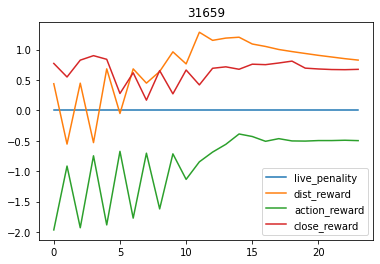

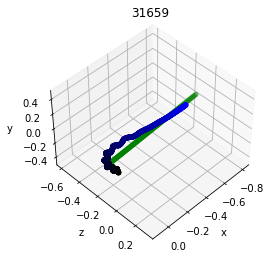

| eval  | E: 1428 | S: 31659 | R: 11.9188
| train | E: 1429 | S: 31659 | R: 11.9643 | D: 15.4 s | BR: 0.2654 | ALOSS: -7.4762 | CLOSS: 0.0702 | TLOSS: -0.4065 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1430 | S: 31683 | R: 14.7083 | D: 40.8 s | BR: 0.3286 | ALOSS: -7.5334 | CLOSS: 0.0872 | TLOSS: 0.5930 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1431 | S: 31701 | R: 12.6557 | D: 14.6 s | BR: 0.3311 | ALOSS: -7.2429 | CLOSS: 0.0686 | TLOSS: -0.8521 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1432 | S: 31721 | R: 12.3189 | D: 17.7 s | BR: 0.3183 | ALOSS: -7.4345 | CLOSS: 0.0636 | TLOSS: -0.0711 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1433 | S: 31741 | R: 12.0918 | D: 17.5 s | BR: 0.3322 | ALOSS: -7.4339 | CLOSS: 0.0789 | TLOSS: -0.0149 | TVAL: 0.0299 | AENT: -4.0000
| train | E: 1434 | S: 31762 | R: 5.6429 | D: 18.4 s | BR: 0.3463 | ALOSS: -7.4855 | CLOSS: 0.0745 | TLOSS: 0.5189 | TVAL: 0.0300 | AENT: -4.0000
| train | E: 1435 | S: 31783 | R: 5.3589 | D: 19.7 s | BR: 0.2833 | ALOSS

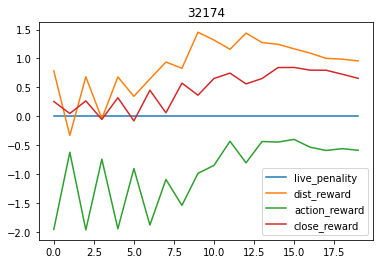

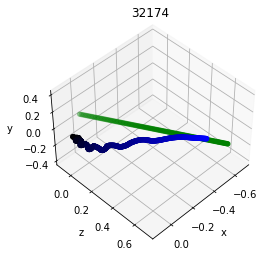

| eval  | E: 1453 | S: 32174 | R: 7.8028
| train | E: 1454 | S: 32174 | R: 14.9779 | D: 18.5 s | BR: 0.3566 | ALOSS: -7.5123 | CLOSS: 0.0615 | TLOSS: 0.2169 | TVAL: 0.0303 | AENT: -4.0000
| train | E: 1455 | S: 32192 | R: 15.2062 | D: 31.3 s | BR: 0.2745 | ALOSS: -7.6103 | CLOSS: 0.0663 | TLOSS: -0.4062 | TVAL: 0.0303 | AENT: -4.0000
| train | E: 1456 | S: 32212 | R: 12.2667 | D: 15.7 s | BR: 0.3303 | ALOSS: -7.5304 | CLOSS: 0.0701 | TLOSS: -0.1705 | TVAL: 0.0303 | AENT: -4.0000
| train | E: 1457 | S: 32231 | R: 15.4193 | D: 16.2 s | BR: 0.3326 | ALOSS: -7.5783 | CLOSS: 0.0676 | TLOSS: -0.0959 | TVAL: 0.0302 | AENT: -4.0000
| train | E: 1458 | S: 32252 | R: 15.4784 | D: 15.8 s | BR: 0.3982 | ALOSS: -7.5973 | CLOSS: 0.1056 | TLOSS: 0.0773 | TVAL: 0.0302 | AENT: -4.0000
| train | E: 1459 | S: 32272 | R: 8.2102 | D: 16.4 s | BR: 0.3057 | ALOSS: -7.5424 | CLOSS: 0.0952 | TLOSS: 0.0734 | TVAL: 0.0302 | AENT: -4.0000
| train | E: 1460 | S: 32293 | R: 7.0981 | D: 16.6 s | BR: 0.3221 | ALOSS: 

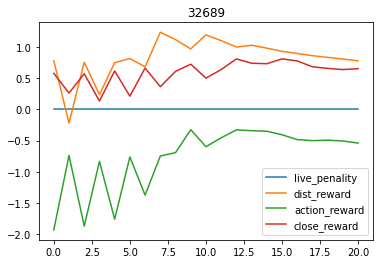

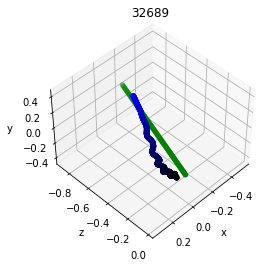

| eval  | E: 1478 | S: 32689 | R: 13.8771
| train | E: 1479 | S: 32689 | R: 10.4775 | D: 18.7 s | BR: 0.3524 | ALOSS: -7.6737 | CLOSS: 0.0727 | TLOSS: 0.3312 | TVAL: 0.0307 | AENT: -4.0000
| train | E: 1480 | S: 32707 | R: 15.1700 | D: 32.1 s | BR: 0.3527 | ALOSS: -7.7404 | CLOSS: 0.0771 | TLOSS: -0.2560 | TVAL: 0.0307 | AENT: -4.0000
| train | E: 1481 | S: 32727 | R: 17.7603 | D: 17.6 s | BR: 0.3509 | ALOSS: -7.4784 | CLOSS: 0.0951 | TLOSS: -0.5240 | TVAL: 0.0307 | AENT: -4.0000
| train | E: 1482 | S: 32748 | R: 14.1854 | D: 16.7 s | BR: 0.2694 | ALOSS: -7.5720 | CLOSS: 0.0658 | TLOSS: -0.1955 | TVAL: 0.0306 | AENT: -4.0000
| train | E: 1483 | S: 32764 | R: 15.4634 | D: 14.1 s | BR: 0.3757 | ALOSS: -7.4424 | CLOSS: 0.0598 | TLOSS: -0.2689 | TVAL: 0.0306 | AENT: -4.0000
| train | E: 1484 | S: 32780 | R: 14.5574 | D: 13.2 s | BR: 0.3485 | ALOSS: -7.4334 | CLOSS: 0.1177 | TLOSS: -0.7253 | TVAL: 0.0305 | AENT: -4.0000
| train | E: 1485 | S: 32798 | R: 11.5577 | D: 15.1 s | BR: 0.3299 | AL

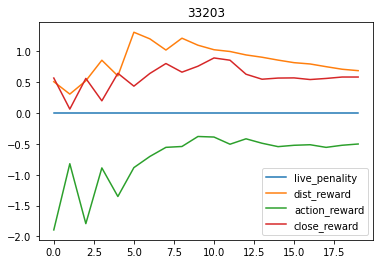

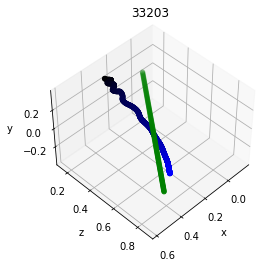

| eval  | E: 1504 | S: 33203 | R: 13.9435
| train | E: 1505 | S: 33203 | R: 16.9869 | D: 14.0 s | BR: 0.2823 | ALOSS: -7.4629 | CLOSS: 0.0788 | TLOSS: 0.1131 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1506 | S: 33223 | R: 16.3231 | D: 31.6 s | BR: 0.3352 | ALOSS: -7.5703 | CLOSS: 0.0620 | TLOSS: 0.0650 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1507 | S: 33242 | R: 8.9512 | D: 14.3 s | BR: 0.3440 | ALOSS: -7.4907 | CLOSS: 0.0632 | TLOSS: 0.0246 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1508 | S: 33262 | R: 5.0049 | D: 16.0 s | BR: 0.3103 | ALOSS: -7.7166 | CLOSS: 0.0635 | TLOSS: 0.0311 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1509 | S: 33280 | R: 14.5248 | D: 14.0 s | BR: 0.3289 | ALOSS: -7.7309 | CLOSS: 0.0717 | TLOSS: 0.4214 | TVAL: 0.0308 | AENT: -4.0000
| train | E: 1510 | S: 33302 | R: 12.9136 | D: 18.8 s | BR: 0.3379 | ALOSS: -7.5567 | CLOSS: 0.0624 | TLOSS: 0.0978 | TVAL: 0.0309 | AENT: -4.0000
| train | E: 1511 | S: 33320 | R: 15.1446 | D: 14.4 s | BR: 0.3596 | ALOSS: -7

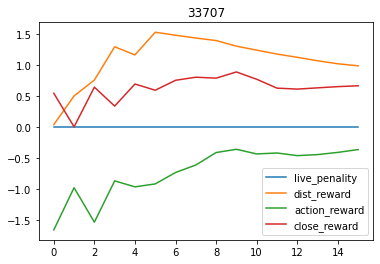

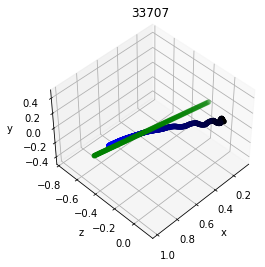

| eval  | E: 1529 | S: 33707 | R: 15.8972
| train | E: 1530 | S: 33707 | R: 15.6199 | D: 16.4 s | BR: 0.3668 | ALOSS: -7.5108 | CLOSS: 0.0708 | TLOSS: -0.2785 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1531 | S: 33727 | R: 10.8766 | D: 29.7 s | BR: 0.3840 | ALOSS: -7.4822 | CLOSS: 0.0583 | TLOSS: 0.0729 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1532 | S: 33745 | R: 16.9260 | D: 15.3 s | BR: 0.3238 | ALOSS: -7.2616 | CLOSS: 0.0665 | TLOSS: 0.1566 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1533 | S: 33767 | R: 9.8776 | D: 17.9 s | BR: 0.2981 | ALOSS: -7.6282 | CLOSS: 0.0691 | TLOSS: -0.0844 | TVAL: 0.0311 | AENT: -4.0000
| train | E: 1534 | S: 33792 | R: 13.0162 | D: 21.3 s | BR: 0.3652 | ALOSS: -7.5240 | CLOSS: 0.0674 | TLOSS: 0.2304 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1535 | S: 33812 | R: 12.5288 | D: 16.1 s | BR: 0.3338 | ALOSS: -7.5867 | CLOSS: 0.0667 | TLOSS: -0.2341 | TVAL: 0.0312 | AENT: -4.0000
| train | E: 1536 | S: 33836 | R: 10.0463 | D: 21.0 s | BR: 0.3175 | ALOSS

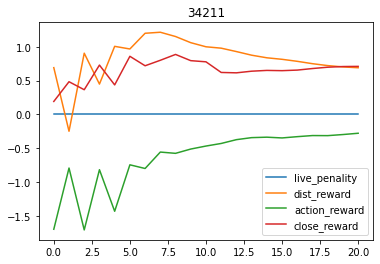

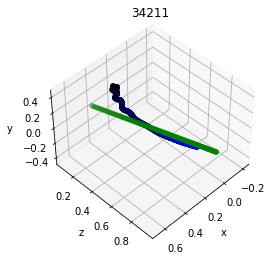

| eval  | E: 1553 | S: 34211 | R: 17.6880
| train | E: 1554 | S: 34211 | R: 13.7375 | D: 17.9 s | BR: 0.2780 | ALOSS: -7.5160 | CLOSS: 0.0711 | TLOSS: -0.0855 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 1555 | S: 34227 | R: 16.0683 | D: 32.1 s | BR: 0.3104 | ALOSS: -7.3456 | CLOSS: 0.0686 | TLOSS: 0.8447 | TVAL: 0.0313 | AENT: -4.0000
| train | E: 1556 | S: 34245 | R: 16.7282 | D: 15.7 s | BR: 0.3339 | ALOSS: -7.4407 | CLOSS: 0.0776 | TLOSS: -0.0819 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 1557 | S: 34266 | R: 17.7775 | D: 18.6 s | BR: 0.3082 | ALOSS: -7.6876 | CLOSS: 0.0813 | TLOSS: -0.0898 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 1558 | S: 34286 | R: 15.7624 | D: 15.8 s | BR: 0.3733 | ALOSS: -7.7189 | CLOSS: 0.0661 | TLOSS: -0.0194 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 1559 | S: 34306 | R: 17.4174 | D: 15.6 s | BR: 0.3355 | ALOSS: -7.5276 | CLOSS: 0.0691 | TLOSS: 0.2235 | TVAL: 0.0314 | AENT: -4.0000
| train | E: 1560 | S: 34330 | R: 15.1962 | D: 21.0 s | BR: 0.3421 | ALO

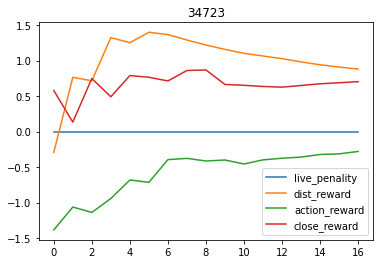

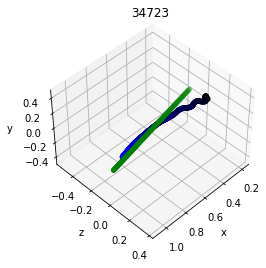

| eval  | E: 1577 | S: 34723 | R: 18.2756
| train | E: 1578 | S: 34723 | R: 16.0780 | D: 15.6 s | BR: 0.3198 | ALOSS: -7.3752 | CLOSS: 0.1151 | TLOSS: 0.5449 | TVAL: 0.0316 | AENT: -4.0000
| train | E: 1579 | S: 34745 | R: 13.5323 | D: 31.3 s | BR: 0.3220 | ALOSS: -7.7634 | CLOSS: 0.0655 | TLOSS: -0.1762 | TVAL: 0.0316 | AENT: -4.0000
| train | E: 1580 | S: 34768 | R: 14.4464 | D: 19.2 s | BR: 0.3190 | ALOSS: -7.7157 | CLOSS: 0.0605 | TLOSS: 0.3877 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1581 | S: 34784 | R: 12.9450 | D: 12.6 s | BR: 0.4055 | ALOSS: -7.4208 | CLOSS: 0.0566 | TLOSS: -0.3232 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1582 | S: 34805 | R: 15.2440 | D: 18.1 s | BR: 0.3460 | ALOSS: -7.4403 | CLOSS: 0.0838 | TLOSS: 0.2514 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1583 | S: 34828 | R: 11.1962 | D: 17.5 s | BR: 0.3569 | ALOSS: -7.4762 | CLOSS: 0.0684 | TLOSS: 0.0840 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1584 | S: 34857 | R: 13.1481 | D: 22.7 s | BR: 0.3530 | ALOSS

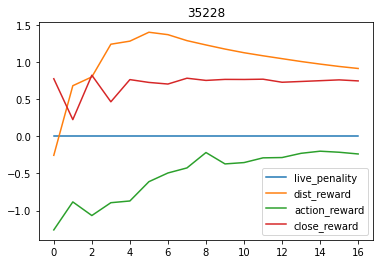

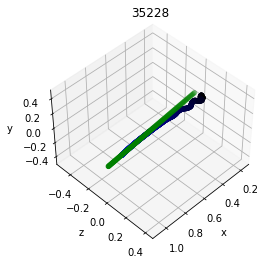

| eval  | E: 1601 | S: 35228 | R: 20.3576
| train | E: 1602 | S: 35228 | R: 8.1661 | D: 18.3 s | BR: 0.3044 | ALOSS: -7.6412 | CLOSS: 0.0614 | TLOSS: -0.2229 | TVAL: 0.0318 | AENT: -4.0000
| train | E: 1603 | S: 35249 | R: 1.5799 | D: 30.8 s | BR: 0.3360 | ALOSS: -7.5303 | CLOSS: 0.0744 | TLOSS: 0.0062 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1604 | S: 35270 | R: 16.6990 | D: 16.5 s | BR: 0.2909 | ALOSS: -7.5393 | CLOSS: 0.0774 | TLOSS: 0.0489 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1605 | S: 35289 | R: 11.5555 | D: 15.5 s | BR: 0.3500 | ALOSS: -7.6362 | CLOSS: 0.0658 | TLOSS: 0.0352 | TVAL: 0.0318 | AENT: -4.0000
| train | E: 1606 | S: 35307 | R: 16.6398 | D: 15.7 s | BR: 0.3848 | ALOSS: -7.6335 | CLOSS: 0.0649 | TLOSS: -0.2895 | TVAL: 0.0318 | AENT: -4.0000
| train | E: 1607 | S: 35333 | R: 11.0868 | D: 19.9 s | BR: 0.3626 | ALOSS: -7.6257 | CLOSS: 0.0687 | TLOSS: 0.1902 | TVAL: 0.0317 | AENT: -4.0000
| train | E: 1608 | S: 35351 | R: 15.8154 | D: 15.4 s | BR: 0.3751 | ALOSS: 

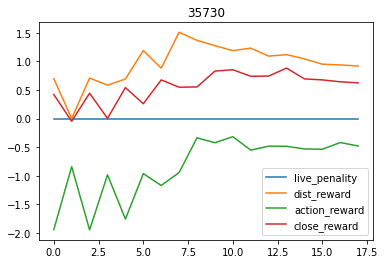

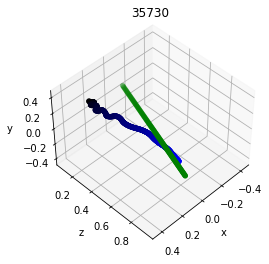

| eval  | E: 1626 | S: 35730 | R: 12.3327
| train | E: 1627 | S: 35730 | R: 7.7879 | D: 17.3 s | BR: 0.3544 | ALOSS: -7.5269 | CLOSS: 0.0758 | TLOSS: -0.1344 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1628 | S: 35752 | R: 10.3845 | D: 32.0 s | BR: 0.3251 | ALOSS: -7.4146 | CLOSS: 0.0662 | TLOSS: 0.3701 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1629 | S: 35773 | R: 7.5709 | D: 16.7 s | BR: 0.3361 | ALOSS: -7.5548 | CLOSS: 0.0640 | TLOSS: -0.3390 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1630 | S: 35791 | R: 8.2650 | D: 14.7 s | BR: 0.3511 | ALOSS: -7.5087 | CLOSS: 0.0674 | TLOSS: 0.3655 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1631 | S: 35812 | R: 15.3531 | D: 16.9 s | BR: 0.3576 | ALOSS: -7.5526 | CLOSS: 0.0603 | TLOSS: -0.3733 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1632 | S: 35831 | R: 17.9222 | D: 17.9 s | BR: 0.3664 | ALOSS: -7.7825 | CLOSS: 0.0575 | TLOSS: 0.4387 | TVAL: 0.0320 | AENT: -4.0000
| train | E: 1633 | S: 35852 | R: 7.3115 | D: 18.3 s | BR: 0.3584 | ALOSS: -

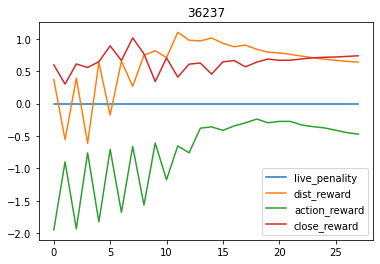

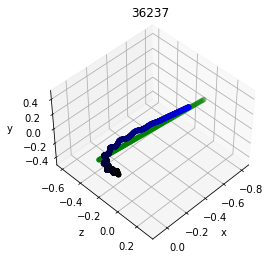

| eval  | E: 1650 | S: 36237 | R: 14.8775
| train | E: 1651 | S: 36237 | R: 16.5562 | D: 19.3 s | BR: 0.3550 | ALOSS: -7.5558 | CLOSS: 0.0588 | TLOSS: -0.2122 | TVAL: 0.0321 | AENT: -4.0000
| train | E: 1652 | S: 36266 | R: 12.3376 | D: 51.4 s | BR: 0.3555 | ALOSS: -7.6733 | CLOSS: 0.0579 | TLOSS: 0.2764 | TVAL: 0.0321 | AENT: -4.0000
| train | E: 1653 | S: 36289 | R: 19.3025 | D: 21.5 s | BR: 0.3572 | ALOSS: -7.6984 | CLOSS: 0.0686 | TLOSS: 0.1159 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 1654 | S: 36305 | R: 14.9499 | D: 15.3 s | BR: 0.3315 | ALOSS: -7.5993 | CLOSS: 0.1370 | TLOSS: 0.0615 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 1655 | S: 36330 | R: 15.7932 | D: 20.9 s | BR: 0.3938 | ALOSS: -7.3907 | CLOSS: 0.1109 | TLOSS: -0.2546 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 1656 | S: 36349 | R: 18.9948 | D: 15.5 s | BR: 0.3312 | ALOSS: -7.4536 | CLOSS: 0.0845 | TLOSS: 0.1258 | TVAL: 0.0322 | AENT: -4.0000
| train | E: 1657 | S: 36368 | R: 8.7306 | D: 17.6 s | BR: 0.3757 | ALOSS:

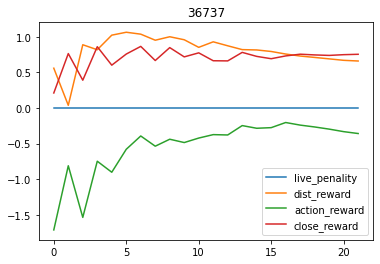

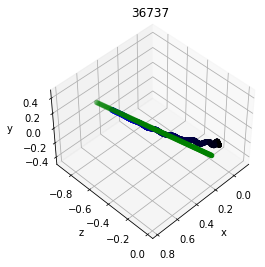

| eval  | E: 1674 | S: 36737 | R: 21.2166
| train | E: 1675 | S: 36737 | R: 15.5919 | D: 19.3 s | BR: 0.3594 | ALOSS: -7.5636 | CLOSS: 0.0629 | TLOSS: 0.2294 | TVAL: 0.0323 | AENT: -4.0000
| train | E: 1676 | S: 36757 | R: 16.1525 | D: 35.5 s | BR: 0.3344 | ALOSS: -7.5864 | CLOSS: 0.0758 | TLOSS: 0.1542 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1677 | S: 36777 | R: 14.9847 | D: 20.1 s | BR: 0.3100 | ALOSS: -7.5410 | CLOSS: 0.0628 | TLOSS: 0.3733 | TVAL: 0.0324 | AENT: -4.0000
| train | E: 1678 | S: 36800 | R: 2.9223 | D: 20.5 s | BR: 0.4039 | ALOSS: -7.6329 | CLOSS: 0.0629 | TLOSS: 0.0217 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1679 | S: 36818 | R: 16.2450 | D: 17.4 s | BR: 0.3785 | ALOSS: -7.5394 | CLOSS: 0.0587 | TLOSS: -0.1010 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1680 | S: 36836 | R: 9.0265 | D: 16.8 s | BR: 0.4464 | ALOSS: -7.5329 | CLOSS: 0.0584 | TLOSS: 0.0108 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1681 | S: 36853 | R: 16.2019 | D: 16.0 s | BR: 0.4085 | ALOSS: -

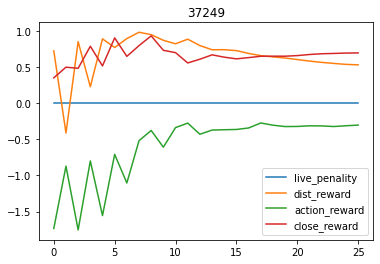

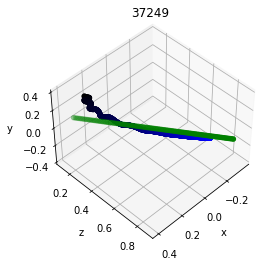

| eval  | E: 1699 | S: 37249 | R: 19.3284
| train | E: 1700 | S: 37249 | R: 16.1344 | D: 20.1 s | BR: 0.3600 | ALOSS: -7.4123 | CLOSS: 0.0632 | TLOSS: -0.0823 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1701 | S: 37267 | R: 3.0489 | D: 35.8 s | BR: 0.4054 | ALOSS: -7.5519 | CLOSS: 0.0617 | TLOSS: 0.4808 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1702 | S: 37288 | R: 1.6155 | D: 17.9 s | BR: 0.3522 | ALOSS: -7.4812 | CLOSS: 0.0706 | TLOSS: 0.3351 | TVAL: 0.0325 | AENT: -4.0000
| train | E: 1703 | S: 37313 | R: 7.7455 | D: 19.6 s | BR: 0.3742 | ALOSS: -7.4624 | CLOSS: 0.0686 | TLOSS: 0.3593 | TVAL: 0.0327 | AENT: -4.0000
| train | E: 1704 | S: 37335 | R: 18.7643 | D: 18.0 s | BR: 0.3815 | ALOSS: -7.5188 | CLOSS: 0.0592 | TLOSS: -0.0787 | TVAL: 0.0327 | AENT: -4.0000
| train | E: 1705 | S: 37359 | R: 13.5392 | D: 18.5 s | BR: 0.3458 | ALOSS: -7.5283 | CLOSS: 0.0962 | TLOSS: -0.0398 | TVAL: 0.0327 | AENT: -4.0000
| train | E: 1706 | S: 37376 | R: 12.7013 | D: 14.3 s | BR: 0.3025 | ALOSS: 

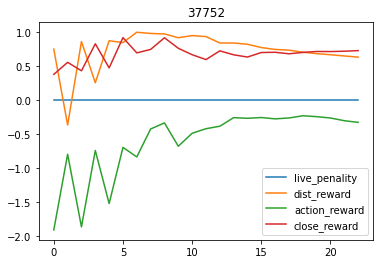

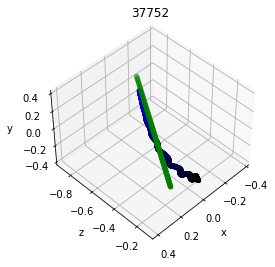

| eval  | E: 1724 | S: 37752 | R: 18.9549
| train | E: 1725 | S: 37752 | R: 11.4683 | D: 14.2 s | BR: 0.3874 | ALOSS: -7.7012 | CLOSS: 0.0660 | TLOSS: 0.3354 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1726 | S: 37775 | R: 6.9263 | D: 37.5 s | BR: 0.3815 | ALOSS: -7.7831 | CLOSS: 0.0662 | TLOSS: -0.3531 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1727 | S: 37793 | R: 14.5095 | D: 15.3 s | BR: 0.3473 | ALOSS: -7.5537 | CLOSS: 0.0730 | TLOSS: 0.5193 | TVAL: 0.0330 | AENT: -4.0000
| train | E: 1728 | S: 37818 | R: 14.5404 | D: 18.4 s | BR: 0.3513 | ALOSS: -7.7102 | CLOSS: 0.0572 | TLOSS: 0.0235 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1729 | S: 37836 | R: 11.2579 | D: 13.7 s | BR: 0.3621 | ALOSS: -7.7269 | CLOSS: 0.0655 | TLOSS: -0.0131 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1730 | S: 37859 | R: 9.7909 | D: 17.9 s | BR: 0.4054 | ALOSS: -7.7867 | CLOSS: 0.0621 | TLOSS: 0.2981 | TVAL: 0.0331 | AENT: -4.0000
| train | E: 1731 | S: 37878 | R: 16.1381 | D: 17.0 s | BR: 0.3348 | ALOSS: 

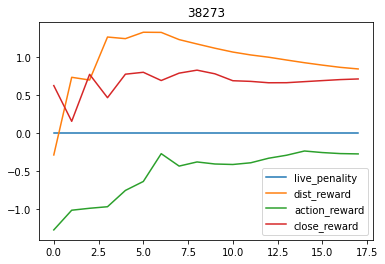

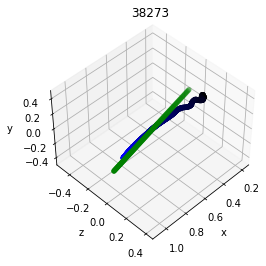

| eval  | E: 1748 | S: 38273 | R: 19.8313
| train | E: 1749 | S: 38273 | R: 13.6886 | D: 22.0 s | BR: 0.4059 | ALOSS: -7.5951 | CLOSS: 0.0674 | TLOSS: 0.0139 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1750 | S: 38302 | R: 6.7733 | D: 44.3 s | BR: 0.3961 | ALOSS: -7.5957 | CLOSS: 0.0658 | TLOSS: -0.3444 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1751 | S: 38324 | R: 13.8081 | D: 21.4 s | BR: 0.3886 | ALOSS: -7.7792 | CLOSS: 0.0529 | TLOSS: -0.1940 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 1752 | S: 38349 | R: 6.8812 | D: 21.3 s | BR: 0.3681 | ALOSS: -7.7132 | CLOSS: 0.0543 | TLOSS: -0.2927 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 1753 | S: 38369 | R: 13.6249 | D: 16.6 s | BR: 0.3875 | ALOSS: -7.5912 | CLOSS: 0.0577 | TLOSS: -0.4276 | TVAL: 0.0332 | AENT: -4.0000
| train | E: 1754 | S: 38390 | R: 2.9372 | D: 17.6 s | BR: 0.3373 | ALOSS: -7.6540 | CLOSS: 0.0635 | TLOSS: -0.2278 | TVAL: 0.0332 | AENT: -4.0000
| train | E: 1755 | S: 38412 | R: 18.7238 | D: 18.5 s | BR: 0.3770 | ALOSS

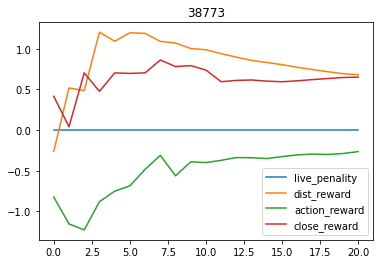

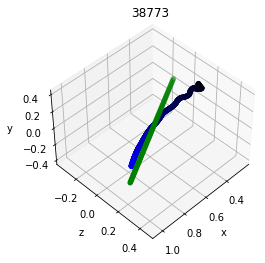

| eval  | E: 1772 | S: 38773 | R: 19.7815
| train | E: 1773 | S: 38773 | R: 18.9628 | D: 17.0 s | BR: 0.4235 | ALOSS: -7.6170 | CLOSS: 0.0606 | TLOSS: -0.0458 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1774 | S: 38794 | R: 15.5213 | D: 34.2 s | BR: 0.3873 | ALOSS: -7.6930 | CLOSS: 0.0504 | TLOSS: -0.1320 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1775 | S: 38814 | R: 14.6323 | D: 15.3 s | BR: 0.3608 | ALOSS: -7.8082 | CLOSS: 0.0589 | TLOSS: -0.2601 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1776 | S: 38840 | R: 11.3267 | D: 24.7 s | BR: 0.3972 | ALOSS: -7.6586 | CLOSS: 0.0602 | TLOSS: -0.0149 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1777 | S: 38859 | R: 11.1932 | D: 18.2 s | BR: 0.4187 | ALOSS: -7.6519 | CLOSS: 0.0561 | TLOSS: -0.2703 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 1778 | S: 38885 | R: 16.7160 | D: 22.2 s | BR: 0.3926 | ALOSS: -7.6088 | CLOSS: 0.0668 | TLOSS: 0.1358 | TVAL: 0.0333 | AENT: -4.0000
| train | E: 1779 | S: 38909 | R: 10.4279 | D: 23.5 s | BR: 0.3386 | AL

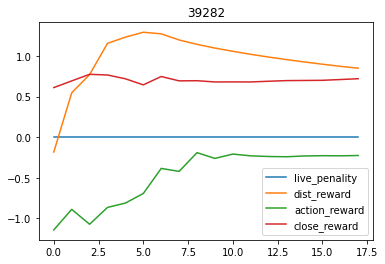

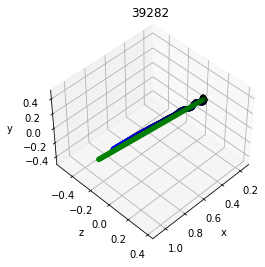

| eval  | E: 1796 | S: 39282 | R: 21.1280
| train | E: 1797 | S: 39282 | R: 6.0926 | D: 17.7 s | BR: 0.4111 | ALOSS: -7.7554 | CLOSS: 0.0649 | TLOSS: -0.3987 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1798 | S: 39302 | R: 17.7867 | D: 30.9 s | BR: 0.3387 | ALOSS: -7.9226 | CLOSS: 0.0659 | TLOSS: -0.3794 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1799 | S: 39321 | R: 17.9390 | D: 14.5 s | BR: 0.4336 | ALOSS: -7.4362 | CLOSS: 0.0718 | TLOSS: -0.6413 | TVAL: 0.0335 | AENT: -4.0000
| train | E: 1800 | S: 39347 | R: 5.0918 | D: 18.7 s | BR: 0.3923 | ALOSS: -7.7849 | CLOSS: 0.0579 | TLOSS: 0.4403 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1801 | S: 39366 | R: 14.0439 | D: 14.8 s | BR: 0.3887 | ALOSS: -7.5872 | CLOSS: 0.0534 | TLOSS: -0.4851 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1802 | S: 39386 | R: 15.5802 | D: 16.0 s | BR: 0.4374 | ALOSS: -7.4784 | CLOSS: 0.0613 | TLOSS: 0.4647 | TVAL: 0.0334 | AENT: -4.0000
| train | E: 1803 | S: 39404 | R: 13.7748 | D: 13.0 s | BR: 0.3710 | ALOSS

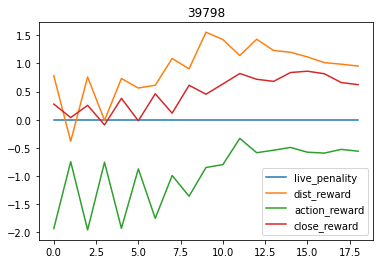

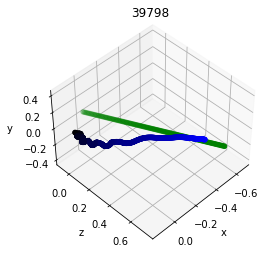

| eval  | E: 1820 | S: 39798 | R: 8.0967
| train | E: 1821 | S: 39798 | R: 15.6166 | D: 16.2 s | BR: 0.3878 | ALOSS: -7.4665 | CLOSS: 0.0611 | TLOSS: 0.2306 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1822 | S: 39817 | R: 6.6225 | D: 29.9 s | BR: 0.4295 | ALOSS: -7.4382 | CLOSS: 0.0627 | TLOSS: 0.1965 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1823 | S: 39835 | R: 16.3161 | D: 14.1 s | BR: 0.4135 | ALOSS: -7.7846 | CLOSS: 0.0530 | TLOSS: -0.6292 | TVAL: 0.0337 | AENT: -4.0000
| train | E: 1824 | S: 39857 | R: 15.3142 | D: 16.4 s | BR: 0.3363 | ALOSS: -7.5314 | CLOSS: 0.0576 | TLOSS: 0.0753 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1825 | S: 39883 | R: 11.2163 | D: 19.5 s | BR: 0.4276 | ALOSS: -7.4929 | CLOSS: 0.0587 | TLOSS: -0.0649 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1826 | S: 39902 | R: 6.9311 | D: 15.5 s | BR: 0.3884 | ALOSS: -7.8083 | CLOSS: 0.0533 | TLOSS: -0.0431 | TVAL: 0.0336 | AENT: -4.0000
| train | E: 1827 | S: 39920 | R: 16.2475 | D: 15.0 s | BR: 0.3857 | ALOSS: 

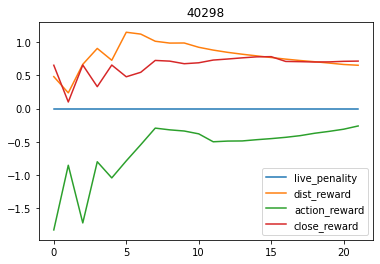

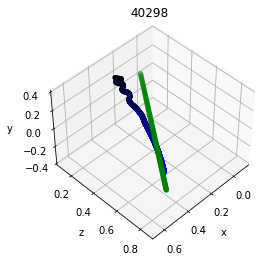

| eval  | E: 1844 | S: 40298 | R: 18.3077
| train | E: 1845 | S: 40298 | R: 17.9773 | D: 17.1 s | BR: 0.3451 | ALOSS: -7.7164 | CLOSS: 0.0659 | TLOSS: 0.2236 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1846 | S: 40315 | R: 16.2501 | D: 31.4 s | BR: 0.4140 | ALOSS: -7.6110 | CLOSS: 0.0608 | TLOSS: -0.3682 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1847 | S: 40340 | R: 14.1839 | D: 18.8 s | BR: 0.3907 | ALOSS: -7.4041 | CLOSS: 0.0614 | TLOSS: 0.5833 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1848 | S: 40360 | R: 12.7432 | D: 14.9 s | BR: 0.3949 | ALOSS: -7.5373 | CLOSS: 0.0634 | TLOSS: -0.0418 | TVAL: 0.0340 | AENT: -4.0000
| train | E: 1849 | S: 40381 | R: 16.3250 | D: 16.8 s | BR: 0.4344 | ALOSS: -7.7121 | CLOSS: 0.0507 | TLOSS: -0.3596 | TVAL: 0.0340 | AENT: -4.0000
| train | E: 1850 | S: 40402 | R: 10.2959 | D: 17.3 s | BR: 0.4045 | ALOSS: -7.6730 | CLOSS: 0.0697 | TLOSS: 0.3847 | TVAL: 0.0339 | AENT: -4.0000
| train | E: 1851 | S: 40428 | R: 15.3065 | D: 19.8 s | BR: 0.3655 | ALOS

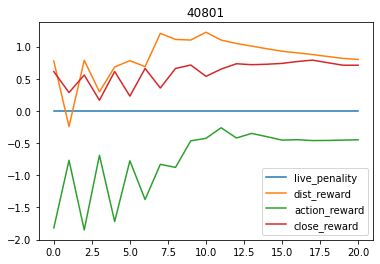

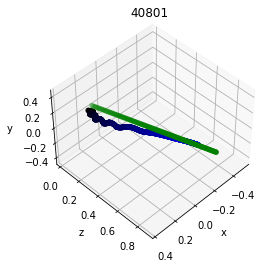

| eval  | E: 1868 | S: 40801 | R: 14.6249
| train | E: 1869 | S: 40801 | R: 18.3286 | D: 17.8 s | BR: 0.3938 | ALOSS: -7.5074 | CLOSS: 0.0658 | TLOSS: 0.4924 | TVAL: 0.0344 | AENT: -4.0000
| train | E: 1870 | S: 40821 | R: 8.6522 | D: 33.6 s | BR: 0.3694 | ALOSS: -7.8385 | CLOSS: 0.0479 | TLOSS: -0.5070 | TVAL: 0.0344 | AENT: -4.0000
| train | E: 1871 | S: 40841 | R: 11.6780 | D: 14.9 s | BR: 0.3475 | ALOSS: -7.8309 | CLOSS: 0.0622 | TLOSS: 0.2272 | TVAL: 0.0344 | AENT: -4.0000
| train | E: 1872 | S: 40860 | R: 16.1140 | D: 16.0 s | BR: 0.3602 | ALOSS: -7.6017 | CLOSS: 0.0875 | TLOSS: -0.4137 | TVAL: 0.0344 | AENT: -4.0000
| train | E: 1873 | S: 40882 | R: 6.7986 | D: 17.8 s | BR: 0.3566 | ALOSS: -7.7263 | CLOSS: 0.0580 | TLOSS: 0.2835 | TVAL: 0.0343 | AENT: -4.0000
| train | E: 1874 | S: 40905 | R: 17.3927 | D: 16.9 s | BR: 0.3465 | ALOSS: -7.5324 | CLOSS: 0.0626 | TLOSS: -0.1255 | TVAL: 0.0343 | AENT: -4.0000
| train | E: 1875 | S: 40924 | R: 14.0973 | D: 16.5 s | BR: 0.3945 | ALOSS:

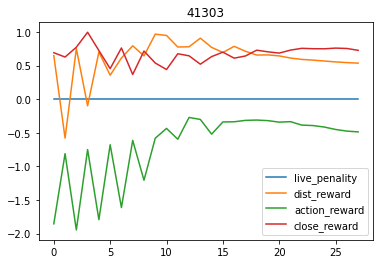

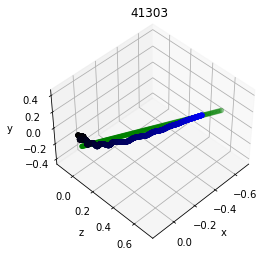

| eval  | E: 1892 | S: 41303 | R: 17.1869
| train | E: 1893 | S: 41303 | R: 11.3557 | D: 18.5 s | BR: 0.3846 | ALOSS: -7.5473 | CLOSS: 0.0514 | TLOSS: -0.0139 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1894 | S: 41321 | R: 15.2654 | D: 36.7 s | BR: 0.3491 | ALOSS: -7.7562 | CLOSS: 0.0543 | TLOSS: -0.0108 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1895 | S: 41338 | R: 15.3680 | D: 13.8 s | BR: 0.3954 | ALOSS: -7.6593 | CLOSS: 0.0507 | TLOSS: -0.0189 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1896 | S: 41364 | R: 5.0965 | D: 21.5 s | BR: 0.3818 | ALOSS: -7.4369 | CLOSS: 0.0640 | TLOSS: -0.2341 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1897 | S: 41380 | R: 15.0767 | D: 13.7 s | BR: 0.3498 | ALOSS: -7.5391 | CLOSS: 0.0567 | TLOSS: 0.3036 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1898 | S: 41404 | R: 15.1352 | D: 22.1 s | BR: 0.4267 | ALOSS: -7.6893 | CLOSS: 0.0505 | TLOSS: 0.0306 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1899 | S: 41421 | R: 16.0700 | D: 14.6 s | BR: 0.3877 | ALOS

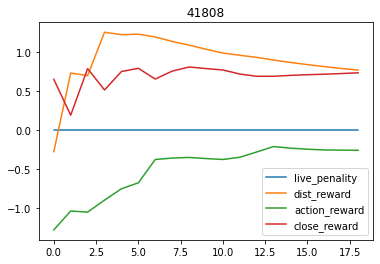

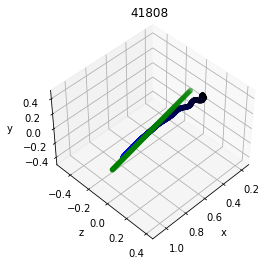

| eval  | E: 1917 | S: 41808 | R: 20.6815
| train | E: 1918 | S: 41808 | R: 5.9078 | D: 14.9 s | BR: 0.3888 | ALOSS: -7.6034 | CLOSS: 0.0563 | TLOSS: -0.0310 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1919 | S: 41835 | R: 8.8429 | D: 37.2 s | BR: 0.3874 | ALOSS: -7.6722 | CLOSS: 0.0971 | TLOSS: 0.1888 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1920 | S: 41856 | R: 18.4778 | D: 16.1 s | BR: 0.3657 | ALOSS: -7.7862 | CLOSS: 0.0601 | TLOSS: -0.1597 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1921 | S: 41882 | R: 15.1878 | D: 21.1 s | BR: 0.4088 | ALOSS: -7.7165 | CLOSS: 0.0531 | TLOSS: -0.1851 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1922 | S: 41901 | R: 16.5363 | D: 13.8 s | BR: 0.3804 | ALOSS: -7.5389 | CLOSS: 0.1260 | TLOSS: 0.0217 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1923 | S: 41921 | R: 14.7401 | D: 16.5 s | BR: 0.3435 | ALOSS: -7.7248 | CLOSS: 0.0692 | TLOSS: -0.0812 | TVAL: 0.0345 | AENT: -4.0000
| train | E: 1924 | S: 41945 | R: 13.4753 | D: 18.2 s | BR: 0.3714 | ALOSS

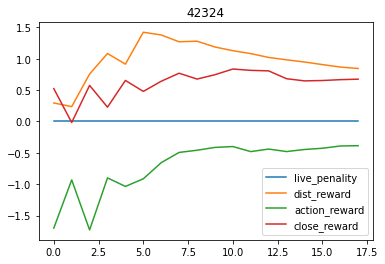

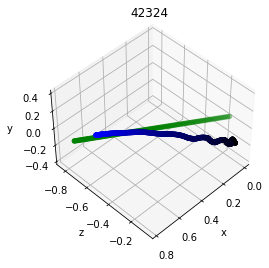

| eval  | E: 1941 | S: 42324 | R: 15.9247
| train | E: 1942 | S: 42324 | R: 16.1103 | D: 16.5 s | BR: 0.4091 | ALOSS: -7.4894 | CLOSS: 0.0563 | TLOSS: 0.1043 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1943 | S: 42343 | R: 16.7746 | D: 28.0 s | BR: 0.3759 | ALOSS: -7.3377 | CLOSS: 0.0509 | TLOSS: -0.2310 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1944 | S: 42365 | R: 17.3981 | D: 16.9 s | BR: 0.3632 | ALOSS: -7.5678 | CLOSS: 0.0542 | TLOSS: 0.2626 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1945 | S: 42387 | R: 6.6938 | D: 16.6 s | BR: 0.4025 | ALOSS: -7.6965 | CLOSS: 0.0525 | TLOSS: -0.3518 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1946 | S: 42409 | R: 16.0760 | D: 18.7 s | BR: 0.4313 | ALOSS: -7.5223 | CLOSS: 0.0537 | TLOSS: 0.2458 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1947 | S: 42430 | R: 15.9410 | D: 15.8 s | BR: 0.4326 | ALOSS: -7.6841 | CLOSS: 0.0544 | TLOSS: -0.1961 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1948 | S: 42453 | R: 9.1145 | D: 17.0 s | BR: 0.4083 | ALOSS:

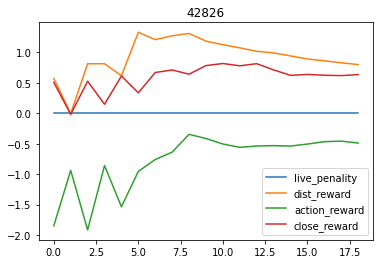

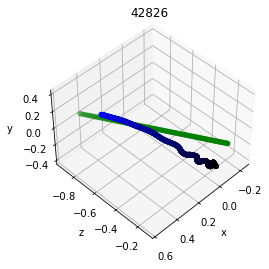

| eval  | E: 1965 | S: 42826 | R: 13.9976
| train | E: 1966 | S: 42826 | R: 18.8073 | D: 17.7 s | BR: 0.4041 | ALOSS: -7.6188 | CLOSS: 0.0489 | TLOSS: 0.2465 | TVAL: 0.0348 | AENT: -4.0000
| train | E: 1967 | S: 42843 | R: 16.5533 | D: 29.9 s | BR: 0.3657 | ALOSS: -7.6882 | CLOSS: 0.0531 | TLOSS: 0.0536 | TVAL: 0.0349 | AENT: -4.0000
| train | E: 1968 | S: 42864 | R: 9.2675 | D: 19.0 s | BR: 0.4434 | ALOSS: -7.7419 | CLOSS: 0.0524 | TLOSS: 0.6612 | TVAL: 0.0349 | AENT: -4.0000
| train | E: 1969 | S: 42882 | R: 14.7600 | D: 15.0 s | BR: 0.4340 | ALOSS: -7.6980 | CLOSS: 0.0837 | TLOSS: 0.1278 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 1970 | S: 42903 | R: 8.9335 | D: 18.6 s | BR: 0.3460 | ALOSS: -7.6230 | CLOSS: 0.0587 | TLOSS: -0.1176 | TVAL: 0.0351 | AENT: -4.0000
| train | E: 1971 | S: 42922 | R: 18.9857 | D: 16.0 s | BR: 0.3423 | ALOSS: -7.6069 | CLOSS: 0.0646 | TLOSS: 0.0059 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 1972 | S: 42945 | R: 7.0397 | D: 19.3 s | BR: 0.4333 | ALOSS: -7

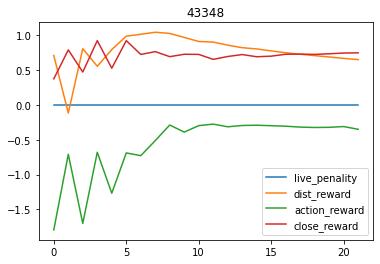

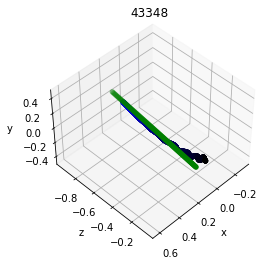

| eval  | E: 1990 | S: 43348 | R: 20.1269
| train | E: 1991 | S: 43348 | R: 18.5151 | D: 18.9 s | BR: 0.3944 | ALOSS: -7.7434 | CLOSS: 0.0676 | TLOSS: 0.2466 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1992 | S: 43368 | R: 16.4713 | D: 35.0 s | BR: 0.3781 | ALOSS: -7.9479 | CLOSS: 0.0529 | TLOSS: 0.4584 | TVAL: 0.0346 | AENT: -4.0000
| train | E: 1993 | S: 43389 | R: 16.2691 | D: 17.5 s | BR: 0.3938 | ALOSS: -7.5970 | CLOSS: 0.0585 | TLOSS: -0.4277 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1994 | S: 43412 | R: 18.0949 | D: 17.7 s | BR: 0.4328 | ALOSS: -7.6764 | CLOSS: 0.0572 | TLOSS: 0.2321 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1995 | S: 43437 | R: 10.8422 | D: 20.4 s | BR: 0.4240 | ALOSS: -7.4819 | CLOSS: 0.0595 | TLOSS: 0.3680 | TVAL: 0.0347 | AENT: -4.0000
| train | E: 1996 | S: 43461 | R: 16.3457 | D: 20.8 s | BR: 0.3465 | ALOSS: -7.6937 | CLOSS: 0.0548 | TLOSS: 0.7865 | TVAL: 0.0348 | AENT: -4.0000
| train | E: 1997 | S: 43478 | R: 17.0222 | D: 14.7 s | BR: 0.4122 | ALOSS:

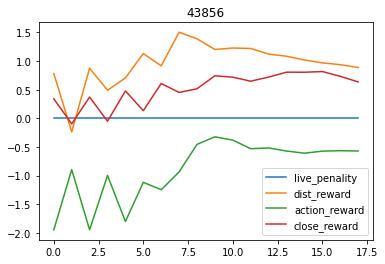

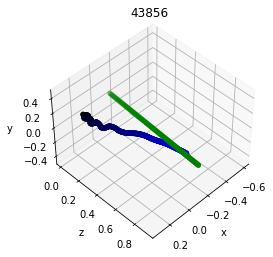

| eval  | E: 2014 | S: 43856 | R: 10.6201
| train | E: 2015 | S: 43856 | R: 15.3986 | D: 16.5 s | BR: 0.4498 | ALOSS: -7.5707 | CLOSS: 0.0571 | TLOSS: -0.0506 | TVAL: 0.0349 | AENT: -4.0000
| train | E: 2016 | S: 43882 | R: 14.0380 | D: 35.3 s | BR: 0.3879 | ALOSS: -7.7110 | CLOSS: 0.0484 | TLOSS: 0.1115 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 2017 | S: 43902 | R: 8.9281 | D: 15.6 s | BR: 0.3950 | ALOSS: -7.5527 | CLOSS: 0.0526 | TLOSS: 0.0940 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 2018 | S: 43925 | R: 16.6232 | D: 18.0 s | BR: 0.3880 | ALOSS: -7.5878 | CLOSS: 0.0562 | TLOSS: 0.7293 | TVAL: 0.0350 | AENT: -4.0000
| train | E: 2019 | S: 43948 | R: 10.4953 | D: 19.2 s | BR: 0.3653 | ALOSS: -7.8672 | CLOSS: 0.0477 | TLOSS: 0.1532 | TVAL: 0.0352 | AENT: -4.0000
| train | E: 2020 | S: 43971 | R: 13.4338 | D: 17.0 s | BR: 0.4127 | ALOSS: -7.5837 | CLOSS: 0.0471 | TLOSS: -0.2470 | TVAL: 0.0352 | AENT: -4.0000
| train | E: 2021 | S: 43993 | R: 12.8207 | D: 16.5 s | BR: 0.4258 | ALOSS:

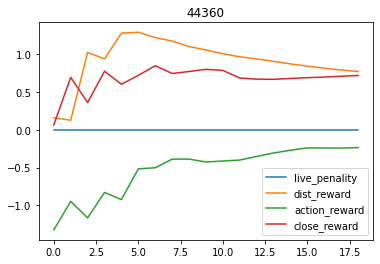

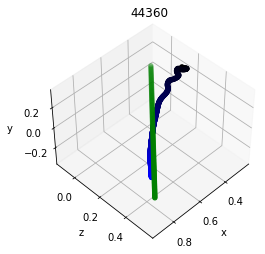

| eval  | E: 2038 | S: 44360 | R: 19.8268
| train | E: 2039 | S: 44360 | R: 14.4221 | D: 12.7 s | BR: 0.4667 | ALOSS: -7.7581 | CLOSS: 0.0474 | TLOSS: -0.4424 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2040 | S: 44378 | R: 17.3416 | D: 30.2 s | BR: 0.3919 | ALOSS: -7.4605 | CLOSS: 0.0855 | TLOSS: 0.1019 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 2041 | S: 44399 | R: 16.8823 | D: 17.6 s | BR: 0.4079 | ALOSS: -7.7087 | CLOSS: 0.0524 | TLOSS: -0.0921 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 2042 | S: 44423 | R: 13.7462 | D: 18.8 s | BR: 0.4274 | ALOSS: -7.7870 | CLOSS: 0.0527 | TLOSS: -0.2934 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 2043 | S: 44447 | R: 18.1604 | D: 20.3 s | BR: 0.3984 | ALOSS: -7.7084 | CLOSS: 0.0605 | TLOSS: 0.1252 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 2044 | S: 44473 | R: 18.6150 | D: 19.7 s | BR: 0.4074 | ALOSS: -7.6037 | CLOSS: 0.0556 | TLOSS: 0.1235 | TVAL: 0.0355 | AENT: -4.0000
| train | E: 2045 | S: 44494 | R: 8.7920 | D: 17.1 s | BR: 0.3708 | ALOSS

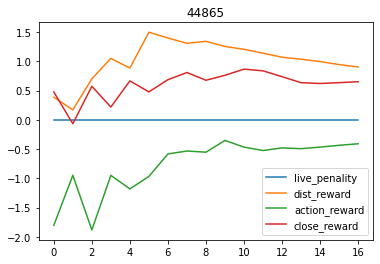

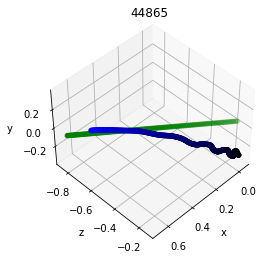

| eval  | E: 2061 | S: 44865 | R: 14.5768
| train | E: 2062 | S: 44865 | R: 7.3912 | D: 22.5 s | BR: 0.3899 | ALOSS: -7.5697 | CLOSS: 0.0454 | TLOSS: -0.1340 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2063 | S: 44884 | R: 14.9976 | D: 28.9 s | BR: 0.4282 | ALOSS: -7.6833 | CLOSS: 0.0451 | TLOSS: -0.0914 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2064 | S: 44912 | R: 11.0082 | D: 20.1 s | BR: 0.4418 | ALOSS: -7.7553 | CLOSS: 0.0735 | TLOSS: 0.2143 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2065 | S: 44930 | R: 15.9072 | D: 15.9 s | BR: 0.4138 | ALOSS: -7.8008 | CLOSS: 0.0478 | TLOSS: -0.4255 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2066 | S: 44962 | R: 4.9970 | D: 25.0 s | BR: 0.4719 | ALOSS: -7.6117 | CLOSS: 0.0506 | TLOSS: -0.4049 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2067 | S: 44982 | R: 17.8353 | D: 18.1 s | BR: 0.3631 | ALOSS: -7.8265 | CLOSS: 0.0638 | TLOSS: -0.2839 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2068 | S: 45002 | R: 9.9022 | D: 15.4 s | BR: 0.4479 | ALOSS

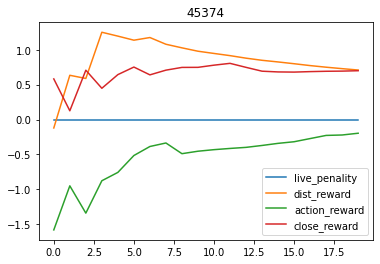

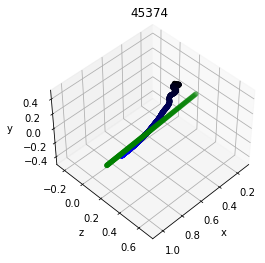

| eval  | E: 2084 | S: 45374 | R: 19.4659
| train | E: 2085 | S: 45374 | R: 17.0765 | D: 13.4 s | BR: 0.3680 | ALOSS: -7.6106 | CLOSS: 0.0512 | TLOSS: -0.3395 | TVAL: 0.0359 | AENT: -4.0000
| train | E: 2086 | S: 45400 | R: 4.4700 | D: 34.0 s | BR: 0.4383 | ALOSS: -7.7367 | CLOSS: 0.0554 | TLOSS: -0.4140 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2087 | S: 45428 | R: 15.2930 | D: 20.8 s | BR: 0.4386 | ALOSS: -7.7035 | CLOSS: 0.0445 | TLOSS: 0.0179 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2088 | S: 45446 | R: 11.9341 | D: 13.9 s | BR: 0.4503 | ALOSS: -7.7788 | CLOSS: 0.0533 | TLOSS: -0.7010 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2089 | S: 45471 | R: 13.7587 | D: 19.5 s | BR: 0.4108 | ALOSS: -7.5908 | CLOSS: 0.0541 | TLOSS: 0.2346 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2090 | S: 45495 | R: 10.0367 | D: 19.3 s | BR: 0.3906 | ALOSS: -7.6711 | CLOSS: 0.0472 | TLOSS: -0.3303 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2091 | S: 45513 | R: 17.2853 | D: 14.6 s | BR: 0.4172 | ALOS

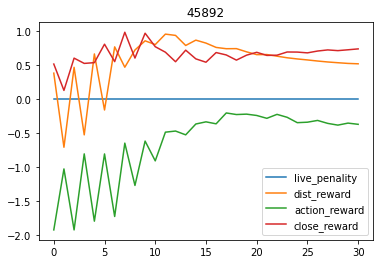

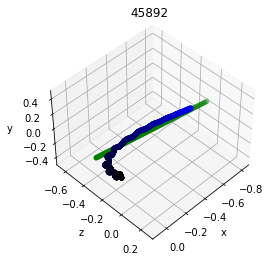

| eval  | E: 2108 | S: 45892 | R: 17.3436
| train | E: 2109 | S: 45892 | R: 17.6415 | D: 18.3 s | BR: 0.4307 | ALOSS: -7.6181 | CLOSS: 0.0495 | TLOSS: 0.0828 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2110 | S: 45916 | R: 9.8358 | D: 43.3 s | BR: 0.3982 | ALOSS: -7.7566 | CLOSS: 0.0528 | TLOSS: 0.2951 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2111 | S: 45934 | R: 10.2185 | D: 14.6 s | BR: 0.4707 | ALOSS: -7.5633 | CLOSS: 0.1025 | TLOSS: 0.1700 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2112 | S: 45954 | R: 15.5813 | D: 15.9 s | BR: 0.4061 | ALOSS: -7.5620 | CLOSS: 0.0632 | TLOSS: 0.3122 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2113 | S: 45975 | R: 17.1955 | D: 15.6 s | BR: 0.4204 | ALOSS: -7.9716 | CLOSS: 0.0526 | TLOSS: -0.3600 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2114 | S: 46006 | R: 10.1475 | D: 25.1 s | BR: 0.4259 | ALOSS: -7.7595 | CLOSS: 0.0484 | TLOSS: -0.1715 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2115 | S: 46029 | R: 11.3836 | D: 17.8 s | BR: 0.4298 | ALOSS:

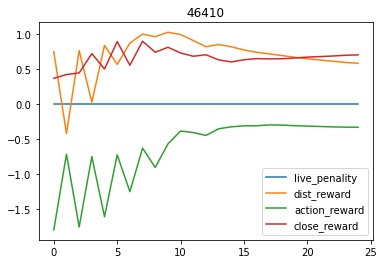

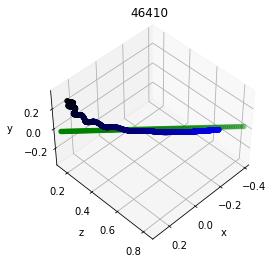

| eval  | E: 2133 | S: 46410 | R: 18.0558
| train | E: 2134 | S: 46410 | R: 10.7601 | D: 19.4 s | BR: 0.4206 | ALOSS: -7.5368 | CLOSS: 0.0551 | TLOSS: 0.0335 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2135 | S: 46430 | R: 18.0528 | D: 32.5 s | BR: 0.4112 | ALOSS: -7.7309 | CLOSS: 0.0512 | TLOSS: 0.6329 | TVAL: 0.0356 | AENT: -4.0000
| train | E: 2136 | S: 46448 | R: 17.7372 | D: 13.8 s | BR: 0.4265 | ALOSS: -7.5678 | CLOSS: 0.0505 | TLOSS: 0.2471 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2137 | S: 46470 | R: 17.0156 | D: 15.9 s | BR: 0.4309 | ALOSS: -7.6557 | CLOSS: 0.0600 | TLOSS: 0.2254 | TVAL: 0.0357 | AENT: -4.0000
| train | E: 2138 | S: 46489 | R: 6.6950 | D: 14.2 s | BR: 0.4158 | ALOSS: -7.5148 | CLOSS: 0.0549 | TLOSS: -0.1560 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2139 | S: 46509 | R: 16.7447 | D: 14.4 s | BR: 0.4255 | ALOSS: -7.7109 | CLOSS: 0.0429 | TLOSS: 0.4784 | TVAL: 0.0358 | AENT: -4.0000
| train | E: 2140 | S: 46532 | R: 13.7444 | D: 18.2 s | BR: 0.4387 | ALOSS: 

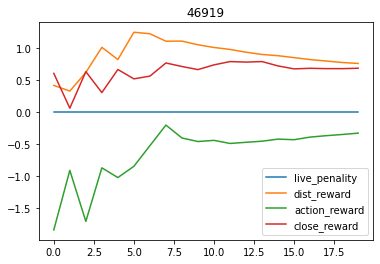

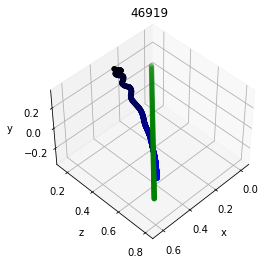

| eval  | E: 2157 | S: 46919 | R: 17.3120
| train | E: 2158 | S: 46919 | R: 10.5720 | D: 13.4 s | BR: 0.4280 | ALOSS: -7.8497 | CLOSS: 0.0854 | TLOSS: 0.3598 | TVAL: 0.0360 | AENT: -4.0000
| train | E: 2159 | S: 46945 | R: 13.1002 | D: 34.5 s | BR: 0.3984 | ALOSS: -7.6147 | CLOSS: 0.0465 | TLOSS: -0.0782 | TVAL: 0.0360 | AENT: -4.0000
| train | E: 2160 | S: 46966 | R: 5.4492 | D: 15.3 s | BR: 0.3848 | ALOSS: -7.8767 | CLOSS: 0.0516 | TLOSS: -0.1268 | TVAL: 0.0360 | AENT: -4.0000
| train | E: 2161 | S: 46991 | R: 15.9679 | D: 17.5 s | BR: 0.4151 | ALOSS: -7.7389 | CLOSS: 0.0492 | TLOSS: -0.2504 | TVAL: 0.0360 | AENT: -4.0000
| train | E: 2162 | S: 47010 | R: 12.2712 | D: 14.4 s | BR: 0.4292 | ALOSS: -7.4834 | CLOSS: 0.0497 | TLOSS: 0.0950 | TVAL: 0.0359 | AENT: -4.0000
| train | E: 2163 | S: 47033 | R: 19.7929 | D: 17.3 s | BR: 0.4728 | ALOSS: -7.6894 | CLOSS: 0.0577 | TLOSS: -0.1690 | TVAL: 0.0359 | AENT: -4.0000
| train | E: 2164 | S: 47055 | R: 7.6015 | D: 16.3 s | BR: 0.3912 | ALOSS

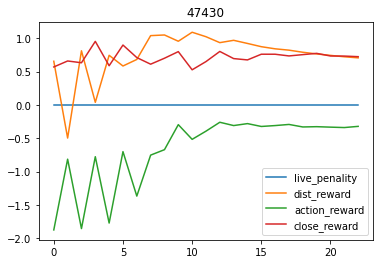

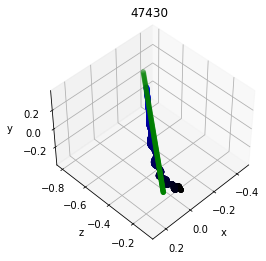

| eval  | E: 2179 | S: 47430 | R: 18.4372
| train | E: 2180 | S: 47430 | R: 18.0338 | D: 17.0 s | BR: 0.4236 | ALOSS: -7.7106 | CLOSS: 0.0527 | TLOSS: -0.2034 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2181 | S: 47447 | R: 16.2913 | D: 33.1 s | BR: 0.3874 | ALOSS: -7.7397 | CLOSS: 0.0522 | TLOSS: 0.1476 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2182 | S: 47464 | R: 15.5569 | D: 17.3 s | BR: 0.4748 | ALOSS: -7.7779 | CLOSS: 0.1305 | TLOSS: -0.0579 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2183 | S: 47480 | R: 15.5918 | D: 14.1 s | BR: 0.4120 | ALOSS: -7.8089 | CLOSS: 0.0812 | TLOSS: 0.1183 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2184 | S: 47497 | R: 12.8210 | D: 15.5 s | BR: 0.4613 | ALOSS: -7.8794 | CLOSS: 0.0493 | TLOSS: 0.4661 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2185 | S: 47515 | R: 16.1433 | D: 14.1 s | BR: 0.4190 | ALOSS: -7.5689 | CLOSS: 0.0489 | TLOSS: -0.3229 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2186 | S: 47537 | R: 15.6309 | D: 18.2 s | BR: 0.3883 | ALOS

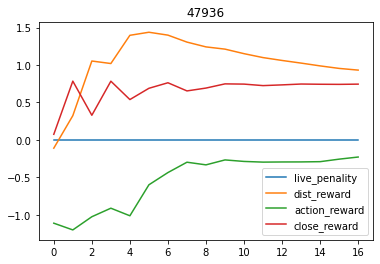

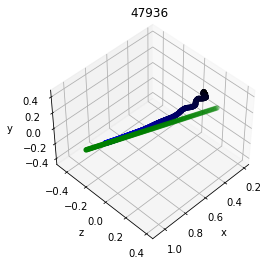

| eval  | E: 2204 | S: 47936 | R: 19.5552
| train | E: 2205 | S: 47936 | R: 16.6662 | D: 13.0 s | BR: 0.4517 | ALOSS: -7.6616 | CLOSS: 0.0511 | TLOSS: 0.0788 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2206 | S: 47957 | R: 14.7919 | D: 27.3 s | BR: 0.4713 | ALOSS: -7.6658 | CLOSS: 0.0547 | TLOSS: 0.2562 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2207 | S: 47982 | R: 12.9085 | D: 18.2 s | BR: 0.4152 | ALOSS: -7.6944 | CLOSS: 0.0493 | TLOSS: -0.0314 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2208 | S: 48002 | R: 16.6785 | D: 14.1 s | BR: 0.4398 | ALOSS: -7.6527 | CLOSS: 0.0936 | TLOSS: -0.1345 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2209 | S: 48027 | R: 13.7984 | D: 18.9 s | BR: 0.3993 | ALOSS: -7.6524 | CLOSS: 0.0745 | TLOSS: -0.3801 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2210 | S: 48045 | R: 13.7893 | D: 13.3 s | BR: 0.4365 | ALOSS: -7.7404 | CLOSS: 0.0680 | TLOSS: 0.1999 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2211 | S: 48065 | R: 10.3526 | D: 17.1 s | BR: 0.3968 | ALOS

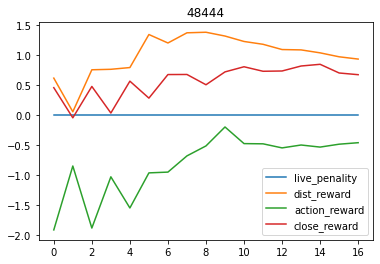

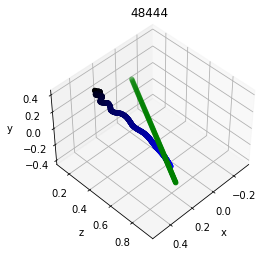

| eval  | E: 2228 | S: 48444 | R: 12.6590
| train | E: 2229 | S: 48444 | R: 3.0581 | D: 15.9 s | BR: 0.3980 | ALOSS: -7.9162 | CLOSS: 0.0432 | TLOSS: -0.0933 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2230 | S: 48460 | R: 14.3144 | D: 26.5 s | BR: 0.4435 | ALOSS: -7.5486 | CLOSS: 0.0443 | TLOSS: 0.1003 | TVAL: 0.0363 | AENT: -4.0000
| train | E: 2231 | S: 48483 | R: 19.3821 | D: 16.1 s | BR: 0.4097 | ALOSS: -7.7900 | CLOSS: 0.0482 | TLOSS: 0.6883 | TVAL: 0.0364 | AENT: -4.0000
| train | E: 2232 | S: 48506 | R: 8.8308 | D: 17.7 s | BR: 0.3990 | ALOSS: -7.7850 | CLOSS: 0.0504 | TLOSS: -0.2837 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2233 | S: 48524 | R: 15.8362 | D: 11.8 s | BR: 0.3739 | ALOSS: -7.6706 | CLOSS: 0.0483 | TLOSS: 0.2368 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2234 | S: 48548 | R: 17.4275 | D: 15.2 s | BR: 0.4408 | ALOSS: -7.5971 | CLOSS: 0.0533 | TLOSS: -0.1761 | TVAL: 0.0365 | AENT: -4.0000
| train | E: 2235 | S: 48565 | R: 16.6833 | D: 13.3 s | BR: 0.4505 | ALOSS:

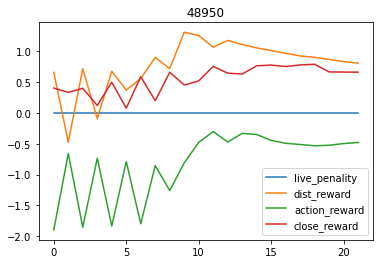

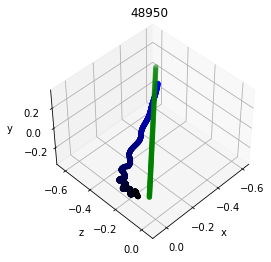

| eval  | E: 2252 | S: 48950 | R: 11.5310
| train | E: 2253 | S: 48950 | R: 15.5122 | D: 12.7 s | BR: 0.4421 | ALOSS: -7.8791 | CLOSS: 0.0475 | TLOSS: 0.2567 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 2254 | S: 48971 | R: 9.6120 | D: 33.6 s | BR: 0.4829 | ALOSS: -7.6266 | CLOSS: 0.0428 | TLOSS: 0.2245 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 2255 | S: 48995 | R: 5.6965 | D: 17.2 s | BR: 0.4529 | ALOSS: -7.5935 | CLOSS: 0.0469 | TLOSS: -0.5075 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 2256 | S: 49015 | R: 18.3919 | D: 16.8 s | BR: 0.4454 | ALOSS: -7.7890 | CLOSS: 0.0502 | TLOSS: -0.0764 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 2257 | S: 49044 | R: 8.0279 | D: 21.7 s | BR: 0.4468 | ALOSS: -7.6520 | CLOSS: 0.0443 | TLOSS: 0.4580 | TVAL: 0.0366 | AENT: -4.0000
| train | E: 2258 | S: 49061 | R: 17.2322 | D: 13.6 s | BR: 0.4937 | ALOSS: -7.6586 | CLOSS: 0.0467 | TLOSS: 0.2987 | TVAL: 0.0368 | AENT: -4.0000
| train | E: 2259 | S: 49086 | R: 13.3344 | D: 18.1 s | BR: 0.4465 | ALOSS: -

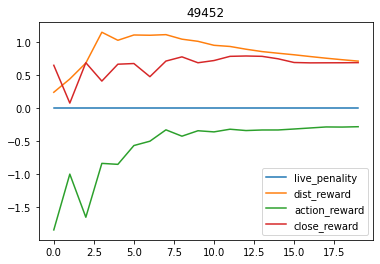

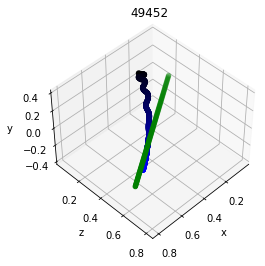

| eval  | E: 2275 | S: 49452 | R: 18.4379
| train | E: 2276 | S: 49452 | R: 13.5421 | D: 18.9 s | BR: 0.3951 | ALOSS: -7.5416 | CLOSS: 0.0510 | TLOSS: 0.0773 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 2277 | S: 49475 | R: 11.8823 | D: 33.0 s | BR: 0.4144 | ALOSS: -7.7349 | CLOSS: 0.0585 | TLOSS: 0.0839 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 2278 | S: 49493 | R: 16.9175 | D: 14.8 s | BR: 0.4938 | ALOSS: -7.5701 | CLOSS: 0.0594 | TLOSS: -0.5353 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 2279 | S: 49514 | R: 7.7265 | D: 16.5 s | BR: 0.4396 | ALOSS: -7.5952 | CLOSS: 0.0488 | TLOSS: 0.2122 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 2280 | S: 49536 | R: 18.4813 | D: 17.3 s | BR: 0.4756 | ALOSS: -7.7627 | CLOSS: 0.0426 | TLOSS: 0.0501 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 2281 | S: 49555 | R: 16.7758 | D: 16.0 s | BR: 0.4796 | ALOSS: -7.6022 | CLOSS: 0.0393 | TLOSS: 0.1702 | TVAL: 0.0369 | AENT: -4.0000
| train | E: 2282 | S: 49572 | R: 10.5497 | D: 14.3 s | BR: 0.4025 | ALOSS: 

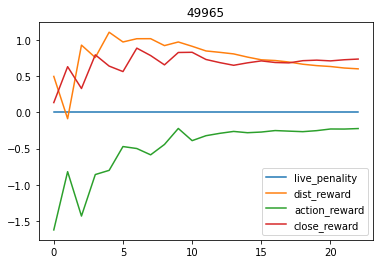

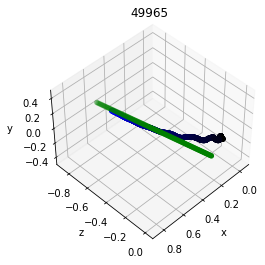

| eval  | E: 2300 | S: 49965 | R: 21.8073
| train | E: 2301 | S: 49965 | R: 12.2059 | D: 19.9 s | BR: 0.4673 | ALOSS: -7.6301 | CLOSS: 0.0477 | TLOSS: 0.0800 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 2302 | S: 49983 | R: 16.1679 | D: 31.8 s | BR: 0.4770 | ALOSS: -7.7710 | CLOSS: 0.0516 | TLOSS: 0.2182 | TVAL: 0.0367 | AENT: -4.0000
| train | E: 2303 | S: 50007 | R: 17.2647 | D: 17.1 s | BR: 0.4590 | ALOSS: -7.5655 | CLOSS: 0.0491 | TLOSS: 0.2669 | TVAL: 0.0368 | AENT: -4.0000


In [27]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        log_data = agent.train(gradient_steps,batch_size)
        logger.log_data(log_data,step)
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done)

In [ ]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [ ]:
network_folder

## Evaluation and Test

In [ ]:
evaluate_save_fluid=False
evaluate_save_data=True

In [ ]:
def evaluate_traj(theta,dist):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
        env.set_task(theta,dist)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            with utils.eval_mode(agent):
                action = agent.act(obs, sample=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
#         plot_infos(infos,title=str(theta))
        env.plot3d(title=str(theta))

In [ ]:
!./clean_visdata.sh
evaluate_traj(3.14,0.01)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [ ]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [ ]:
%matplotlib notebook

In [ ]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [ ]:
# fluid_json = json_folder+'fluid_param_0.5.json'
# rigid_json = json_folder+'rigids_4_30_test.json'
# frame_skip = 100
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
               
                   )
env.plot3d()

In [ ]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_ss.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

In [ ]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


# skeleton_dynamics.update()

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)

# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)
env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    with utils.eval_mode(agent):
        action = agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=False,test_mode=True)
    
    rela_vec_to_goal = env.goal_pos-env.body_xyz
    dist_to_path = np.linalg.norm(rela_vec_to_goal-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir))
    env.proj_pt_world = env.goal_pos-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir)
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t = t+dt
        env.goal_pos = traj.getPose(t).getPosition() 
        env.path_start  = env.body_xyz 
        env.path_dir = env.goal_pos-env.path_start
        env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
    plot_env(env,ax)
plt.close(fig)


In [ ]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**0.5) for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()